In [8]:
import numpy as np
import pandas as pd

from collections import defaultdict
from tqdm import tqdm

import random

import gym
import adaptive_tutor

In [9]:
import numpy as np
action_space = np.load('adaptive_tutor/action_space.npy', allow_pickle=True)

In [10]:
class TutorStatefulAgent:
    def __init__(
        self,
        learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        discount_factor: float = 0.95,
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_values), a learning rate and an epsilon.

        Args:
            learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            discount_factor: The discount factor for computing the Q-value
        """

        self.action_space = list(np.load('adaptive_tutor/action_space.npy', allow_pickle=True))
        self.q_values = defaultdict(lambda: np.ones(len(self.action_space)) * -1000)

        self.lr = learning_rate
        self.discount_factor = discount_factor

        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon

        self.training_error = []

    def _create_rating_bracket(self, row):
        if row<1100:
            return 'lt_1100'
        elif 1100<=row<1300:
            return '1100-1300'
        elif 1300<=row<1500:
            return '1300-1500'
        else:
            return 'gt_1500'
    
    def _get_agent_state(self, obs):
        return tuple([self._create_rating_bracket(val) for val in obs['themes_covered']])

    def get_action(self, obs: tuple[int, int, bool]) -> int:
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # with probability epsilon return a random action to explore the environment
        obs = self._get_agent_state(obs)
        if np.random.random() < self.epsilon:
            # print("Exploring")
            return random.choice(range(len(self.action_space)))

        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return (np.argmax(self.q_values[obs]))

    def update(
        self,
        obs: tuple[int, int, bool],
        action: int,
        reward: float,
        terminated: bool,
        next_obs: tuple[int, int, bool],
    ):
        """Updates the Q-value of an action."""
        obs = self._get_agent_state(obs)
        next_obs = self._get_agent_state(next_obs)
        future_q_value = (not terminated) * np.max(self.q_values[next_obs])
        temporal_difference = (
            reward + self.discount_factor * future_q_value - self.q_values[obs][action]
        )

        self.q_values[obs][action] = (
            self.q_values[obs][action] + self.lr * temporal_difference
        )
        self.training_error.append(temporal_difference)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - self.epsilon_decay)

In [11]:
# Hyperparameters
learning_rate = 0.1
n_episodes = 1000
start_epsilon = 1
epsilon_decay = start_epsilon / (n_episodes / 2) # Reduce the exploration over time
final_epsilon = 0.1

agent = TutorStatefulAgent(
    learning_rate=learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
)

In [12]:
# Load custom environment we created 
env = gym.make('adaptive_tutor/PuzzleTutorEnv-v0', render_mode=None) 

# Set to initial state
env.reset()

episode_rewards = []
episode_lengths = []
action_rewards = {action: 0 for action in action_space}

for episode in tqdm(range(n_episodes)):
    obs, info = env.reset()
    done = False
    terminated = False
    episode_reward = 0
    
    # Play one episode
    step_counter = 0
    while not terminated:
        step_counter+=1
        action = agent.get_action(obs)
        next_obs, reward, terminated, info = env.step(action)
        # print(action_space[action], reward)
        # Update the agent
        agent.update(obs, action, reward, terminated, next_obs)
        episode_reward += reward
        #print(action_space[action])
        # Update the current observation, and whether the environment is done
        done = terminated
        obs = next_obs
        action_rewards[action_space[action]] += reward
    
    print("Number of steps: ", step_counter)

    episode_rewards.append(episode_reward)
    episode_lengths.append(step_counter)
    print(f"Episode {episode + 1}: Reward = {episode_reward}, Length = {step_counter}")


    agent.decay_epsilon()

../maia_weights/maia_1100.pb
1
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


  0%|          | 0/1000 [00:00<?, ?it/s]

../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32344)>: stderr >>        _
<UciProtocol (pid=32344)>: stderr >> |   _ | |
<UciProtocol (pid=32344)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32344)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32344)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32344)>: stderr >> Initialized metal backend on device Apple M1
/Users/shikharrastogi/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:219: DeprecationWarning: WARN: Core environment is written in old step API which returns one bool instead of two. It is recommended to rewrite the environment with new step API. 
  logger.deprecation(
/Users/shikharrastogi/opt/anaconda3/envs/rl/lib/python3.9/site-packages/gym/utils/passive_env_checker.py:225: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(done, (bool, np.bool8)):
/Users/shikharrastogi/opt/ana

[   0    0    0    0    0 2384    0    0    0    0]
[   0 1762    0    0    0 2384    0    0    0    0]
[   0 1762    0    0    0 1688    0    0    0    0]
[   0 1762    0    0 1127 1688    0    0    0    0]
[   0 1762    0    0 1127 1688    0    0    0 2087]
[   0 1762    0    0 1127 1688    0    0    0 2087]
[   0 1762    0    0 1127 1688    0    0  882 2087]
[   0 1762    0    0 1127 1688    0    0  882 2087]
[   0 1762    0    0 1127 1688    0    0  882 2087]
[   0 1762    0    0 1127 1688    0    0  882 2186]
[   0 1639    0    0 1127 1688    0    0  882 2186]
[   0 1639    0    0 1127 1688    0    0  882 1457]
[   0 1639    0    0 1127 1688    0    0  882 1457]
[   0 1639    0  467 1127 1688    0    0  882 1457]
[   0 1639    0  467 1127 1688    0    0  882 1417]
[   0 1639    0  467 1127 1688    0    0  882 1412]
[   0 1093    0  467 1127 1688    0    0  882 1412]
[   0 1093    0  467 1127 1688    0    0  882 1412]
[   0 1093    0  467 1127 1688    0    0  441 1412]
[ 260 1093  

  0%|          | 1/1000 [01:02<17:14:15, 62.12s/it]

[1517 1708 1443 1138 1552 1736 1324 1277 1364 1855]
[1517 1708 1443 1138 1552 1736 1324 1277 1419 1855]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  311
Episode 1: Reward = -311, Length = 311
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32353)>: stderr >>        _
<UciProtocol (pid=32353)>: stderr >> |   _ | |
<UciProtocol (pid=32353)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32353)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32353)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32353)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0 857   0   0   0]
[   0    0    0    0 1289    0  857    0    0    0]
[   0    0    0    0 1289    0  857    0    0 2034]
[   0    0    0    0 1289    0  857    0    0 2034]
[   0    0    0    0 1289    0  428    0    0 2034]
[   0    0    0    0 1289    0  285    0    0 2034]
[   0    0    0    0 1289 1561  285    0    0 2034]
[   0    0    0    0 1289 1561  285    0    0 2034]
[   0    0    0    0 1289 1561  285 1081    0 2034]
[   0    0    0    0 1356 1561  285 1081    0 2034]
[   0    0    0    0 1356 1561  285 1081  541 2034]
[   0    0    0    0 1356 1561  517 1081  541 2034]
[   0    0    0    0 1356 1561  517 1081  541 1616]
[   0    0    0    0 1356 1424  517 1081  541 1616]
[   0    0    0  624 1356 1424  517 1081  541 1616]
[   0    0    0  624 1356 1424  517 1081  541 1616]
[   0    0    0  624 1356 1424  517 1081  541 1515]
[   0    0    0  624  904 1424  517 1081  541 1515]
[   0    0    0  624  904  949  517 1081  541 1515]


  0%|          | 2/1000 [01:45<14:09:31, 51.07s/it]

[ 797 1582  922 1422 1584 1566 1487 1295 1509 1528]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  223
Episode 2: Reward = -223, Length = 223
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32355)>: stderr >>        _
<UciProtocol (pid=32355)>: stderr >> |   _ | |
<UciProtocol (pid=32355)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32355)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32355)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32355)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1824    0]
[   0    0    0    0    0    0    0    0 1824  785]
[   0    0    0    0    0 1057    0    0 1824  785]
[   0    0    0    0    0  528    0    0 1824  785]
[1131    0    0    0    0  528    0    0 1824  785]
[1131    0    0    0    0  528  311    0 1824  785]
[1376    0    0    0    0  528  311    0 1824  785]
[1376    0    0    0    0  528  415    0 1824  785]
[1376    0    0    0    0  528  311    0 1824  785]
[1376    0    0    0    0  528  311    0 1824  785]
[1376    0    0    0    0  528  311    0 1824  785]
[1376    0    0 1327    0  528  311    0 1824  785]
[1376    0    0 1327    0  958  311    0 1824  785]
[1376    0    0 1327 1066  958  311    0 1824  785]
[ 917    0    0 1327 1066  958  311    0 1824  785]
[ 688    0    0 1327 1066  958  311    0 1824  785]
[ 688    0  584 1327 1066  958  311    0 1824  785]
[ 688    0  584 1327 1066  958  311    0  912  785]
[ 550    0  584 1327 1066  958  311    0  

  0%|          | 3/1000 [02:38<14:21:46, 51.86s/it]

[1417 1378 1749  936 1335 1726 1418 1478 1588 1781]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  267
Episode 3: Reward = -267, Length = 267
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32359)>: stderr >>        _
<UciProtocol (pid=32359)>: stderr >> |   _ | |
<UciProtocol (pid=32359)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32359)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32359)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32359)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0 1042    0    0    0    0    0    0    0    0]
[   0 1042    0    0    0    0    0 1706    0    0]
[   0 1042    0    0    0    0    0 1409    0    0]
[   0 1042    0    0    0    0    0  939    0    0]
[   0 1042    0    0    0    0    0  939    0 1442]
[   0 1042    0    0    0    0    0  939    0 1442]
[   0 1042    0    0 1875    0    0  939    0 1442]
[   0 1042    0    0 1875    0    0  939    0 1442]
[   0 1042    0    0 1875    0  841  939    0 1442]
[ 321 1042    0    0 1875    0  841  939    0 1442]
[ 321 1042    0    0 1875    0  841  869    0 1442]
[ 321 1042    0    0  937    0  841  869    0 1442]
[ 321 1042    0    0  937    0  841  695    0 1442]
[ 321 1042    0    0  937    0  841  786    0 1442]
[ 321 1042    0    0  937    0  841  786    0 1442]
[ 321 1042    0    0  937 1556  841  786    0 1442]
[ 321 1407    0    0  937 1556  841  786    0 1442]
[ 321 1407    0    0  937  778  841  786    0 1442]
[ 321 1407    0    0  937 1101  841  786  

  0%|          | 4/1000 [03:16<12:48:54, 46.32s/it]

[1105 1408 1551  594 1448 1407 1545 1427 1194 1548]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  199
Episode 4: Reward = -199, Length = 199
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32360)>: stderr >>        _
<UciProtocol (pid=32360)>: stderr >> |   _ | |
<UciProtocol (pid=32360)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32360)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32360)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32360)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1642    0    0    0    0    0]
[   0    0    0    0 1642    0    0    0    0 1534]
[   0    0    0    0 1642    0    0    0    0 1534]
[   0    0    0    0 1642  478    0    0    0 1534]
[   0    0    0    0 1642  478    0    0  695 1534]
[1391    0    0    0 1642  478    0    0  695 1534]
[1391    0    0    0  821  478    0    0  695 1534]
[ 695    0    0    0  821  478    0    0  695 1534]
[ 695    0    0    0  821  478 1066    0  695 1534]
[ 695    0    0    0  821  478  533    0  695 1534]
[ 463    0    0    0  821  478  533    0  695 1534]
[ 511    0    0    0  821  478  533    0  695 1534]
[ 511 1098    0    0  821  478  533    0  695 1534]
[ 511 1098    0    0  821  478  533    0 1271 1534]
[ 511  549    0    0  821  478  533    0 1271 1534]
[ 511  549    0    0  821  478  533    0 1271  767]
[ 511  549    0    0  821  478  533    0 1299  767]
[ 511  549    0    0 1003  478  533    0 1299  767]
[ 511  549    0    0 1014  478  533    0 1299  767]
[ 511  549  

  0%|          | 5/1000 [04:22<14:45:51, 53.42s/it]

[1859 1372 1374 1254 1558 1357 1871 1764 1572 1757]
[1859 1372 1374 1254 1558 1425 1871 1764 1572 1757]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  328
Episode 5: Reward = -328, Length = 328
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32370)>: stderr >>        _
<UciProtocol (pid=32370)>: stderr >> |   _ | |
<UciProtocol (pid=32370)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32370)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32370)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32370)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1432    0]
[   0    0 1417    0    0    0    0    0 1432    0]
[   0    0 1417    0    0    0    0    0 1133    0]
[   0    0 1417    0    0    0    0    0 1133    0]
[   0    0 1417    0  969    0    0    0 1133    0]
[   0    0 1417    0  969    0    0    0 1292    0]
[   0    0 1417    0  969 1487    0    0 1292    0]
[   0    0 1417    0  969 1487    0    0 1292    0]
[   0    0  708    0  969 1487    0    0 1292    0]
[   0    0  708    0  969 1487    0    0 1375    0]
[   0    0  708    0  969 1487    0    0 1375    0]
[   0    0  708    0  969 1487    0    0 1375 1652]
[   0    0  708    0  969 1487    0    0 1375 1652]
[   0    0  708    0  945 1487    0    0 1375 1652]
[   0    0  708    0  945 1487    0    0 1375 1652]
[   0    0  708    0  945 1487    0    0 1375 1317]
[   0    0  992    0  945 1487    0    0 1375 1317]
[   0    0  992    0  630 1487    0    0 1375 1317]
[   0    0 1138    0  630 1487    0    0 1375 1317]
[   0    0 1

  1%|          | 6/1000 [05:12<14:28:17, 52.41s/it]

[1308 1403 1494  827 1553 1544 1534 1268 1750 1879]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  259
Episode 6: Reward = -259, Length = 259
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32371)>: stderr >>        _
<UciProtocol (pid=32371)>: stderr >> |   _ | |
<UciProtocol (pid=32371)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32371)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32371)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32371)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1313    0    0    0    0    0]
[   0    0    0    0 1313    0    0    0    0    0]
[   0    0    0    0 1313    0    0    0    0  663]
[   0    0    0    0 1313 1429    0    0    0  663]
[   0    0    0    0 1313  714    0    0    0  663]
[   0    0    0    0 1313  714    0    0    0  663]
[   0    0    0    0 1313  714    0  728    0  663]
[   0    0    0    0 1313  714    0  364    0  663]
[   0    0    0    0 1313  714    0  364    0  663]
[   0    0    0    0 1313 1107    0  364    0  663]
[   0    0    0    0  656 1107    0  364    0  663]
[   0    0    0    0  656 1107    0  830    0  663]
[   0    0    0    0  656 1107    0  830    0 1030]
[1308    0    0    0  656 1107    0  830    0 1030]
[1308    0    0    0  656 1107    0  830    0 1030]
[1308 1025    0    0  656 1107    0  830    0 1030]
[1308 1025    0    0  887 1107    0  830    0 1030]
[1308 1025    0    0  887 1147    0  830    0 1030]
[1308 1025    0    0  887 1147  582  830    0 1030]
[1308 1025  

  1%|          | 7/1000 [06:10<14:57:32, 54.23s/it]

[1290 1561 1233 1086 1748 1532 1370 1772 1578 1555]
[1290 1561 1233 1086 1748 1532 1402 1772 1578 1555]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  297
Episode 7: Reward = -297, Length = 297
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32374)>: stderr >>        _
<UciProtocol (pid=32374)>: stderr >> |   _ | |
<UciProtocol (pid=32374)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32374)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32374)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32374)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1459]
[   0    0    0    0    0    0    0    0    0 1459]
[   0    0    0    0    0    0    0    0    0 1459]
[   0 2209    0    0    0    0    0    0    0 1459]
[1575 2209    0    0    0    0    0    0    0 1459]
[1575 2209    0    0    0    0    0    0    0 1459]
[1575 2209    0    0 1021    0    0    0    0 1459]
[1575 2209 1469    0 1021    0    0    0    0 1459]
[1575 2209 1469    0 1021    0 1113    0    0 1459]
[1575 2209 1469    0 1021    0 1113    0    0 1179]
[1575 2209 1469    0 1021    0 1113    0    0 1179]
[1575 2209 1469    0 1021    0 1113    0    0 1149]
[1678 2209 1469    0 1021    0 1113    0    0 1149]
[1678 2209 1469    0 1021 1104 1113    0    0 1149]
../maia_Weights/maia_1300.pb
2
Bot_Upgraded
[1678 2209 1469    0 1021 1104 1113    0    0 1307]
[1678 2209 1469    0 1021 1002 1113    0    0 1307]
[1678 2209 1469    0 1021 1002 1113    0    0 1307]
[1678 2209 1469    0 1021 1002 1113    0  871 1307]
[1678 2209  734    0

  1%|          | 8/1000 [06:57<14:15:59, 51.77s/it]

[1241 1512 1760  563 1433 1308 1603 1509 1734 1667]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  230
Episode 8: Reward = -230, Length = 230
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32375)>: stderr >>        _
<UciProtocol (pid=32375)>: stderr >> |   _ | |
<UciProtocol (pid=32375)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32375)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32375)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32375)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0 1296    0    0    0    0    0]
[   0    0    0    0 1296 1183    0    0    0    0]
[   0    0    0    0 1296 1183    0    0    0    0]
[   0    0    0    0 1296 1183    0  532    0    0]
[   0    0    0    0 1296 1639    0  532    0    0]
[   0    0    0    0 1296 1639    0  532 1125    0]
[   0    0 1382    0 1296 1639    0  532 1125    0]
[   0    0 1382    0 1296 1639    0  754 1125    0]
[ 750    0 1382    0 1296 1639    0  754 1125    0]
[ 750    0 1382    0 1223 1639    0  754 1125    0]
[ 750    0 1382    0 1223 1639    0  754 1130    0]
[ 750    0 1382    0 1223 1344    0  754 1130    0]
[ 750    0 1382    0 1223 1344    0  754  753    0]
[ 750  702 1382    0 1223 1344    0  754  753    0]
[ 750  954 1382    0 1223 1344    0  754  753    0]
[ 750  954 1382    0 1218 1344    0  754  753    0]
[ 750  954 1382 1071 1218 1344    0  754  753    0]
[ 750  954 1382 1071 1218 1344    0  754  753    0]
[ 750  954 1382 1071

  1%|          | 9/1000 [07:46<14:03:42, 51.08s/it]

[1288 1525 1396 1434 1719 1773 1644 1344 1400 1648]
[1288 1525 1396 1434 1719 1773 1644 1474 1400 1648]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  251
Episode 9: Reward = -251, Length = 251
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32376)>: stderr >>        _
<UciProtocol (pid=32376)>: stderr >> |   _ | |
<UciProtocol (pid=32376)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32376)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32376)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32376)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0 1234    0    0    0    0]
[ 603    0    0    0    0 1234    0    0    0    0]
[1149    0    0    0    0 1234    0    0    0    0]
[1149    0    0    0    0 1234    0  587    0    0]
[ 766    0    0    0    0 1234    0  587    0    0]
[ 766    0    0    0    0 1234    0  293    0    0]
[ 766    0    0    0    0 1234    0  293    0    0]
[ 766    0    0    0    0 1234    0  293    0 1482]
[ 766    0    0    0 1353 1234    0  293    0 1482]
[ 766    0    0    0 1353 1234    0  293    0 1482]
[ 574    0    0    0 1353 1234    0  293    0 1482]
[ 574    0    0    0 1353 1234    0  293    0 1482]
[ 574    0    0    0 1353 1234    0  293  346 1482]
[ 574    0    0    0 1353 1234    0  293  619 1482]
[ 574    0    0    0 1353 1234    0  293  619 1482]
[ 574    0  419    0 1353 1234    0  293  619 1482]
[ 574    0  419  521 1353 1234    0  293  619 1482]
[ 574    0  419  521 1353 1234    0  293  619 1482]
[ 574    0  419  521 1353 1234    0  293  619 1482]
[ 574    0  

  1%|          | 10/1000 [08:34<13:46:13, 50.07s/it]

[1480 1514  791  696 1538 1636 1355 1360 1449 1751]
[1480 1514  791  696 1538 1636 1458 1360 1449 1751]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  246
Episode 10: Reward = -246, Length = 246
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32387)>: stderr >>        _
<UciProtocol (pid=32387)>: stderr >> |   _ | |
<UciProtocol (pid=32387)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32387)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32387)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32387)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0 1305    0    0]
[  0   0   0   0   0   0   0 652   0   0]
[698   0   0   0   0   0   0 652   0   0]
[ 698    0 1076    0    0    0    0  652    0    0]
[ 698    0 1076    0    0    0    0  652    0    0]
[ 698    0 1076    0    0    0    0  652    0    0]
[ 793    0 1076    0    0    0    0  652    0    0]
[ 793    0 1076    0    0    0    0  652    0 1089]
[ 793    0 1076    0    0    0    0  652    0 1141]
[ 793    0 1076    0    0    0    0  435    0 1141]
[ 793    0 1076    0    0    0    0  435  714 1141]
[ 793    0 1116    0    0    0    0  435  714 1141]
[ 793    0 1116    0    0    0    0  435  714 1141]
[ 793    0 1116  540    0    0    0  435  714 1141]
[ 793    0  744  540    0    0    0  435  714 1141]
[ 793    0  744  540 1409    0    0  435  714 1141]
[ 793    0  744  540 1409    0    0  435  714 1059]
[ 793    0  558  540 1409    0    0  435  714 1059]
[ 595    0  558  540 1409    0    0  435  714 1059]
[ 595    0

  1%|          | 11/1000 [09:31<14:21:50, 52.29s/it]

[1430 1736 1398 1322 1597 1916 1750 1593 1385 1477]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  273
Episode 11: Reward = -273, Length = 273
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32446)>: stderr >>        _
<UciProtocol (pid=32446)>: stderr >> |   _ | |
<UciProtocol (pid=32446)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32446)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32446)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32446)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1007    0]
[   0    0    0    0    0    0    0    0 1007    0]
[1864    0    0    0    0    0    0    0 1007    0]
[1461    0    0    0    0    0    0    0 1007    0]
[1461    0    0    0    0    0    0  847 1007    0]
[1461    0    0    0    0    0    0  423 1007    0]
[1461    0    0    0    0    0  510  423 1007    0]
[1461    0    0    0    0    0  510  627 1007    0]
[1461    0    0    0    0    0  906  627 1007    0]
[1461    0    0    0    0    0  906  627 1007    0]
[1461    0    0    0 1324    0  906  627 1007    0]
[1461    0    0    0 1324    0  679  627 1007    0]
[1461    0    0    0 1324    0  679  627 1007    0]
[1461    0    0    0 1248    0  679  627 1007    0]
[1461    0    0    0 1248    0  679  627 1007 1841]
[1461    0    0    0 1248    0  679  627 1007 1841]
[1461    0    0    0 1248    0  679  470 1007 1841]
[1461    0    0    0 1248    0  679  376 1007 1841]
[1461    0    0    0 1248    0  679  376 1007 1841]
[ 974    0  

  1%|          | 12/1000 [10:14<13:35:33, 49.53s/it]

[1458 1513 1213  765 1691 1761 1301 1629 1363 1416]
[1458 1513 1213  765 1691 1761 1301 1629 1412 1416]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  206
Episode 12: Reward = -206, Length = 206
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32546)>: stderr >>        _
<UciProtocol (pid=32546)>: stderr >> |   _ | |
<UciProtocol (pid=32546)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32546)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32546)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32546)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0 1433    0    0    0    0]
[   0    0    0    0 1729 1433    0    0    0    0]
[1944    0    0    0 1729 1433    0    0    0    0]
[1944    0    0    0 1729 1433    0    0    0    0]
[1944    0    0    0 1729 1433    0    0    0  712]
[1944  900    0    0 1729 1433    0    0    0  712]
[1944  900    0    0 1729 1433    0    0    0  712]
[1944  900    0    0 1729 1433    0    0    0  712]
[1944  900    0    0 1729 1433  720    0    0  712]
[ 972  900    0    0 1729 1433  720    0    0  712]
[ 972  900    0    0 1729 1303  720    0    0  712]
[ 972  900    0    0 1729 1303  720    0    0  712]
[ 972  900    0    0 1729 1303  720  576    0  712]
[ 972  900    0    0 1729 1254  720  576    0  712]
[ 972  900    0    0 1729 1254  720  576    0 1085]
[ 972  450    0    0 1729 1254  720  576    0 1085]
[1029  450    0    0 1729 1254  720  576    0 1085]
[1172  450    0    0 1729 1254  720  576    0 1085]
[ 938  450    0    0

  1%|▏         | 13/1000 [11:16<14:34:23, 53.15s/it]

[1366 1212 1373  931 1625 1745 1535 1552 1726 1587]
[1366 1212 1467  931 1625 1745 1535 1552 1726 1587]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  257
Episode 13: Reward = -257, Length = 257
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32554)>: stderr >>        _
<UciProtocol (pid=32554)>: stderr >> |   _ | |
<UciProtocol (pid=32554)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32554)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32554)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32554)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0   0 693   0   0]
[  0   0   0   0   0   0   0 693   0   0]
[   0    0 1461    0    0    0    0  693    0    0]
[  0   0 730   0   0   0   0 693   0   0]
[   0    0  730    0    0    0    0  693    0 1542]
[   0    0  890    0    0    0    0  693    0 1542]
[  0   0 890   0   0   0   0 693   0 771]
[  0   0 890   0   0   0   0 693   0 771]
[   0    0  890    0    0    0    0 1040    0  771]
[   0    0  890    0    0  829    0 1040    0  771]
[   0  895  890    0    0  829    0 1040    0  771]
[  0 895 890   0   0 829   0 693   0 771]
[  0 895 890   0   0 552   0 693   0 771]
[1040  895  890    0    0  552    0  693    0  771]
[1040  895  890    0    0  552  273  693    0  771]
[1040  895  890    0    0  552  273  520    0  771]
[1040  895  890    0    0  552  273  520    0  771]
[1040  895  909    0    0  552  273  520    0  771]
[1040  447  909    0    0  552  273  520    0  771]
[1040  447  909    0    0  552  273  416    0  771]
[520 447 909   0   0 552 273 4

  1%|▏         | 14/1000 [12:07<14:23:45, 52.56s/it]

[1305 1513 1468 1332 1388 1780 1491  991 1570 1403]
[1305 1513 1468 1332 1463 1780 1491  991 1570 1403]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  231
Episode 14: Reward = -231, Length = 231
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32804)>: stderr >>        _
<UciProtocol (pid=32804)>: stderr >> |   _ | |
<UciProtocol (pid=32804)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32804)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32804)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32804)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0   0   0 910   0]
[  0   0   0   0   0   0   0   0 910   0]
[   0    0    0    0    0    0    0 1521  910    0]
[   0    0    0    0  848    0    0 1521  910    0]
[   0    0    0    0  848    0  957 1521  910    0]
[   0    0    0    0  848    0  957 1521  910 1968]
[   0    0    0    0  848    0  957 1521  910 1968]
[   0    0    0    0  848 1022  957 1521  910 1968]
[   0    0    0    0  848 1022  957 1521  910 1968]
[   0    0    0    0  848 1022  957 1521  910 1968]
[   0    0    0    0  848 1022 1317 1521  910 1968]
[   0    0    0    0  848  511 1317 1521  910 1968]
[   0    0    0    0  848  682 1317 1521  910 1968]
[   0    0    0    0  848  682 1317 1521  910 1968]
[   0    0    0 1073  848  682 1317 1521  910 1968]
[   0    0    0 1073  848  682 1410 1521  910 1968]
[   0    0    0 1290  848  682 1410 1521  910 1968]
[   0    0    0 1290  848  682 1410 1521 1603 1968]
[   0    0    0 1290 1194  682 1410 1521 1603 1968]
[   0    0    0 1290 1194  682 1

  2%|▏         | 15/1000 [13:02<14:35:18, 53.32s/it]

[1255 1494 1450 1375 1650 1391 1559 1492 1536 1558]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  254
Episode 15: Reward = -254, Length = 254
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32824)>: stderr >>        _
<UciProtocol (pid=32824)>: stderr >> |   _ | |
<UciProtocol (pid=32824)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32824)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32824)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32824)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1003    0]
[   0    0    0    0    0    0    0    0 1065    0]
[ 958    0    0    0    0    0    0    0 1065    0]
[ 958    0    0    0    0    0    0    0 1065    0]
[ 958    0    0    0    0    0    0    0 1065    0]
[ 958    0    0    0    0 1891    0    0 1065    0]
[ 958 1064    0    0    0 1891    0    0 1065    0]
[ 958 1064    0    0    0 1556    0    0 1065    0]
[ 958 1504    0    0    0 1556    0    0 1065    0]
[ 958 1002    0    0    0 1556    0    0 1065    0]
[ 958 1002 1805    0    0 1556    0    0 1065    0]
[ 958 1002 1805    0    0 1556    0    0 1065    0]
[ 958  752 1805    0    0 1556    0    0 1065    0]
[ 479  752 1805    0    0 1556    0    0 1065    0]
[ 479  752 1805    0    0 1556    0    0 1065 1047]
[ 479  752 1805    0    0 1556    0    0 1065 1047]
[ 479  752 1805    0    0 1556    0    0 1065 1133]
[ 479  752 1170    0    0 1556    0    0 1065 1133]
[ 479  752 1078    0    0 1556    0    0 1065 1133]
[ 479  752 1

  2%|▏         | 16/1000 [13:42<13:30:04, 49.40s/it]

[1301 1405 1494 1239 1379 1479 1439 1060 1547 1502]
[1301 1405 1494 1239 1466 1479 1439 1060 1547 1502]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  195
Episode 16: Reward = -195, Length = 195
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32830)>: stderr >>        _
<UciProtocol (pid=32830)>: stderr >> |   _ | |
<UciProtocol (pid=32830)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32830)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32830)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32830)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[468   0   0   0   0   0   0   0   0   0]
[468   0   0   0   0   0   0   0   0   0]
[468   0   0   0   0   0   0   0   0   0]
[468   0   0   0   0   0   0   0   0   0]
[468   0   0   0   0   0   0   0   0   0]
[468   0   0   0   0   0   0   0   0   0]
[ 468    0    0    0    0    0    0 1626    0    0]
[ 468    0    0    0    0    0    0 1626    0    0]
[ 468    0    0    0    0    0  245 1626    0    0]
[ 468    0    0    0    0    0  245 1626    0    0]
[ 312    0    0    0    0    0  245 1626    0    0]
[ 312    0    0    0    0  688  245 1626    0    0]
[ 312    0    0    0    0  688  245 1626    0    0]
[ 312    0    0    0    0  688  245 1626  839    0]
[ 312    0    0    0    0  688  245 1626  839    0]
[ 312    0    0    0    0  458  245 1626  839    0]
[ 312    0    0    0    0  458  245 1626  900    0]
[ 524    0    0    0    0  458  245 1626  900    0]
[ 524    0    0    0    0  458  245 1626  900    0]
[ 524    0    0    0    0  4

  2%|▏         | 17/1000 [14:44<14:29:46, 53.09s/it]

[1394 1506 1330 1352 1557 1642 1365 1529 1478 1756]
[1426 1506 1330 1352 1557 1642 1365 1529 1478 1756]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  290
Episode 17: Reward = -290, Length = 290
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32854)>: stderr >>        _
<UciProtocol (pid=32854)>: stderr >> |   _ | |
<UciProtocol (pid=32854)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32854)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32854)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32854)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0 472   0   0   0   0   0   0]
[  0   0   0 472   0   0   0   0   0   0]
[  0   0   0 472   0   0   0   0   0   0]
[   0    0    0  472    0    0    0 1305    0    0]
[   0    0    0  808    0    0    0 1305    0    0]
[   0    0    0  808    0    0    0 1305    0    0]
[   0    0    0  808    0    0    0 1305    0  888]
[   0    0    0  808    0    0  626 1305    0  888]
[   0    0    0  808    0  785  626 1305    0  888]
[   0    0    0  808    0  785  626 1305    0  938]
[1782    0    0  808    0  785  626 1305    0  938]
[1782    0    0  808    0  914  626 1305    0  938]
[1348    0    0  808    0  914  626 1305    0  938]
[1348    0  429  808    0  914  626 1305    0  938]
[1348    0  429 1002    0  914  626 1305    0  938]
[1348    0  429 1002    0  994  626 1305    0  938]
[1348    0  429 1002    0  994  626 1305    0 1043]
[1348    0  429 1002    0  795  626 1305    0 1043]
[1348    0  429 1002 1826  795  626 1305    0 1043]
[1348    0  429 1002

  2%|▏         | 18/1000 [15:47<15:16:55, 56.02s/it]

[1577 1582 1356 1371 1701 1437 1779 1441 1436 1294]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  298
Episode 18: Reward = -298, Length = 298
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32899)>: stderr >>        _
<UciProtocol (pid=32899)>: stderr >> |   _ | |
<UciProtocol (pid=32899)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32899)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32899)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32899)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0   0 647]
[  0   0   0   0 954   0   0   0   0 647]
[  0   0   0   0 954   0   0   0   0 647]
[  0   0   0   0 954   0   0   0   0 647]
[  0   0 363   0 954   0   0   0   0 647]
[  0   0 363   0 954   0   0   0   0 431]
[   0    0  363    0  954 1680    0    0    0  431]
[   0    0  363    0  954 1680    0 1029    0  431]
[   0    0  363    0  954 1680    0 1029  615  431]
[   0    0  242    0  954 1680    0 1029  615  431]
[   0    0  242    0 1022 1680    0 1029  615  431]
[   0 1322  242    0 1022 1680    0 1029  615  431]
[   0 1322  242    0 1022 1680    0 1029  615  700]
[   0 1322  242    0 1022 1228    0 1029  615  700]
[   0 1322  181    0 1022 1228    0 1029  615  700]
[   0 1322  181    0 1022 1131    0 1029  615  700]
[   0 1322  181    0 1022 1131    0 1029  615  832]
[   0 1322  181 1007 1022 1131    0 1029  615  832]
[   0 1322  181 1007 1022 1131    0 1029  621  832]
[   0 1322  181  503 1022 11

  2%|▏         | 19/1000 [16:31<14:17:38, 52.45s/it]

[1527 1416 1453  620 1395 1530 1305  996 1523 1543]
[1527 1416 1453  620 1468 1530 1305  996 1523 1543]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  218
Episode 19: Reward = -218, Length = 218
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32917)>: stderr >>        _
<UciProtocol (pid=32917)>: stderr >> |   _ | |
<UciProtocol (pid=32917)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32917)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32917)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32917)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0 1545    0    0    0    0]
[   0    0    0    0    0 1545    0    0    0    0]
[   0    0    0    0  479 1545    0    0    0    0]
[   0    0    0 1511  479 1545    0    0    0    0]
[   0    0    0 1511  479 1545    0    0    0    0]
[   0    0    0 1511  479 1545    0    0 1199    0]
[   0    0 1489 1511  479 1545    0    0 1199    0]
[   0    0 1489 1511  479  772    0    0 1199    0]
[   0    0 1489 1511  479  772    0    0 1199    0]
[   0    0 1489 1511  876  772    0    0 1199    0]
[   0    0 1489 1511  876  772    0    0 1199 1887]
[   0    0 1489 1511  876  772    0    0 1199 1271]
[   0    0 1489 1511  876  772  867    0 1199 1271]
[   0    0 1489 1511  876  772 1158    0 1199 1271]
[   0    0 1489 1511  876  772 1158 1257 1199 1271]
[   0    0 1489 1511 1115  772 1158 1257 1199 1271]
../maia_Weights/maia_1300.pb
2
Bot_Upgraded
[   0    0 1489  755 1115  772 1158 1257 1199 1271]
[   0    0 1489  755 1115  772 1158 1257  599 1271]
[   0    0 1489  755

  2%|▏         | 20/1000 [17:18<13:49:05, 50.76s/it]

[ 933  868 1441  833 1731 1429 1474 1542 1383 1794]
[ 933  868 1441  833 1731 1429 1474 1542 1413 1794]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  222
Episode 20: Reward = -222, Length = 222
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32933)>: stderr >>        _
<UciProtocol (pid=32933)>: stderr >> |   _ | |
<UciProtocol (pid=32933)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32933)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32933)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32933)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0 537   0   0   0   0]
[  0   0 360   0   0 537   0   0   0   0]
[1309    0  360    0    0  537    0    0    0    0]
[1309    0  360    0    0  537    0    0    0    0]
[1309    0  360    0    0  537    0    0    0    0]
[1309    0  360    0    0  537 1762    0    0    0]
[1309    0  360  169    0  537 1762    0    0    0]
[1309    0  360  169    0  537 1762    0    0    0]
[1175    0  360  169    0  537 1762    0    0    0]
[1175    0  360  169    0  537 1762    0    0    0]
[1175    0  360  127    0  537 1762    0    0    0]
[1175    0  360  127    0  537 1762    0    0    0]
[1175    0  360  127    0  537 1321    0    0    0]
[1175    0  360  127    0  537  880    0    0    0]
[1175    0  360  127    0 1070  880    0    0    0]
[1175    0  360  127    0 1070  880    0    0    0]
[1175    0  360  127    0 1070  880    0  450    0]
[1175    0  360  127    0 1070  880    0  450  511]
[1175    0  360  1

  2%|▏         | 21/1000 [18:04<13:25:16, 49.35s/it]

[1115 1563 1626  605 1570 1507 1371 1584 1381 1527]
[1115 1563 1626  605 1570 1507 1371 1584 1445 1527]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  219
Episode 21: Reward = -219, Length = 219
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=32967)>: stderr >>        _
<UciProtocol (pid=32967)>: stderr >> |   _ | |
<UciProtocol (pid=32967)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=32967)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=32967)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=32967)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1367]
[   0    0    0    0    0    0    0    0    0 1456]
[   0    0    0    0 1762    0    0    0    0 1456]
[   0    0    0    0 1762    0    0    0    0 1456]
[   0    0  581    0 1762    0    0    0    0 1456]
[   0    0  581    0  881    0    0    0    0 1456]
[   0    0  581    0  881 1165    0    0    0 1456]
[   0    0  387    0  881 1165    0    0    0 1456]
[   0    0  387    0  881 1165    0    0    0 1456]
[   0    0  387    0  881 1165    0    0    0 1456]
[   0    0  387    0  881 1165 1145    0    0 1456]
[   0    0  387    0  881 1165 1145    0    0 1426]
[   0    0  387    0  881  582 1145    0    0 1426]
[   0 1449  387    0  881  582 1145    0    0 1426]
[   0 1449  387    0  881  582 1145    0    0 1467]
[1261 1449  387    0  881  582 1145    0    0 1467]
[1261 1449  387    0  881  582 1145 1752    0 1467]
[1261 1449  387  868  881  582 1145 1752    0 1467]
[1404 1449  387  868  881  582 1145 1752    0 1467]
[ 936 1449  

  2%|▏         | 22/1000 [19:01<13:59:40, 51.51s/it]

[1407 1671  744 1616 1440 1276 1392 1421 1518 1865]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  266
Episode 22: Reward = -266, Length = 266
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33010)>: stderr >>        _
<UciProtocol (pid=33010)>: stderr >> |   _ | |
<UciProtocol (pid=33010)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33010)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33010)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33010)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1733]
[   0    0    0    0    0    0    0    0    0 1733]
[   0    0    0    0 1466    0    0    0    0 1733]
[   0    0    0    0 1466    0    0    0  929 1733]
[   0    0    0    0 1466    0    0    0  929 1733]
[   0    0    0    0 1466    0    0    0  929 1733]
[   0    0    0    0 1466    0    0    0  929 1733]
[   0  675    0    0 1466    0    0    0  929 1733]
[   0  675    0    0 1466    0    0    0  929 1578]
[   0  675  781    0 1466    0    0    0  929 1578]
[   0  675  781    0 1766    0    0    0  929 1578]
[   0  995  781    0 1766    0    0    0  929 1578]
[   0  995  781  700 1766    0    0    0  929 1578]
[   0  995  781  700 1766    0    0    0  929 1052]
[   0  995  781  700 1766    0    0    0  929 1052]
[   0  995  781  700 1766    0    0    0  929 1052]
[   0  995  781  700 1766    0    0    0  464 1052]
[   0  995  781  350 1766    0    0    0  464 1052]
[   0  995  781  350

  2%|▏         | 23/1000 [19:54<14:07:07, 52.02s/it]

[1365 1668 1490  715 1573 1616 1434 1633 1358 1687]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  252
Episode 23: Reward = -252, Length = 252
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33031)>: stderr >>        _
<UciProtocol (pid=33031)>: stderr >> |   _ | |
<UciProtocol (pid=33031)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33031)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33031)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33031)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 696   0]
[  0   0   0   0   0   0   0   0 696   0]
[1174    0    0    0    0    0    0    0  696    0]
[1174    0    0    0 1846    0    0    0  696    0]
[1174    0    0    0 1181    0    0    0  696    0]
[1174    0    0    0 1181    0    0    0  696    0]
[1174    0    0    0 1181 1892    0    0  696    0]
[1174    0    0    0 1181 1892    0    0  696    0]
[1174    0    0    0 1181 1892    0  402  696    0]
[1174    0    0    0 1181 1892    0  402  696 1252]
[1174    0    0    0 1181 1892    0  402  696 1532]
[ 587    0    0    0 1181 1892    0  402  696 1532]
[ 587    0    0    0 1181 1892    0  883  696 1532]
[ 587 1281    0    0 1181 1892    0  883  696 1532]
[ 587 1281    0    0 1181 1892    0  883  696 1532]
[ 587 1281    0    0 1181 1892    0  883 1116 1532]
[ 587 1281    0    0 1181 1892    0  883  744 1532]
[ 587 1281  653    0 1181 1892    0  883  744 1532]
[ 587 1281  653    0 1181 1892    0  883  744 1532]
[ 587 1534

  2%|▏         | 24/1000 [20:53<14:39:32, 54.07s/it]

[1459 1586 1322 1352 1746 1530 1319 1612 1350 1716]
[1459 1586 1322 1352 1746 1530 1402 1612 1350 1716]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  283
Episode 24: Reward = -283, Length = 283
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33056)>: stderr >>        _
<UciProtocol (pid=33056)>: stderr >> |   _ | |
<UciProtocol (pid=33056)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33056)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33056)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33056)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1134    0    0    0    0    0    0    0]
[   0 1897 1134    0    0    0    0    0    0    0]
[   0 1897 1134    0    0    0    0    0    0    0]
[1814 1897 1134    0    0    0    0    0    0    0]
[1814 1897 1426    0    0    0    0    0    0    0]
[1814 1897 1426    0    0    0    0    0 1221    0]
[1814 1897 1426    0    0    0    0    0 1244    0]
[1814 1897 1426    0    0    0    0    0 1244    0]
[1814 1897 1426    0 1327    0    0    0 1244    0]
[1814 1897 1426    0 1115    0    0    0 1244    0]
[1814 1897 1271    0 1115    0    0    0 1244    0]
[1814  948 1271    0 1115    0    0    0 1244    0]
[1814  632 1271    0 1115    0    0    0 1244    0]
[1814  632 1271    0 1115    0    0    0 1244    0]
[1814  632 1271    0 1115    0    0    0 1084    0]
[1814  474 1271    0 1115    0    0    0 1084    0]
[1814  474 1271    0 1115    0    0    0 1084    0]
[1814  474 1271    0 1115    0    0    0 1084    0]
[ 907  474 1271    0 1115    0    0    0 1084    0]
[ 907  474 1

  2%|▎         | 25/1000 [21:31<13:23:21, 49.44s/it]

[1520 1127 1713  565 1494 1071 1595 1486 1357 1484]
[1520 1127 1713  565 1494 1071 1595 1486 1424 1484]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  194
Episode 25: Reward = -194, Length = 194
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33060)>: stderr >>        _
<UciProtocol (pid=33060)>: stderr >> |   _ | |
<UciProtocol (pid=33060)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33060)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33060)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33060)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1894    0]
[  0   0   0   0   0   0   0   0 947   0]
[  0   0   0   0   0   0   0   0 947   0]
[  0   0   0   0   0   0   0   0 947   0]
[   0    0    0    0    0    0 2120    0  947    0]
[   0    0    0    0    0    0 2120    0  947  765]
[   0    0    0    0    0    0 2120  473  947  765]
[   0    0    0    0    0    0 2120  473  947  382]
[   0    0    0    0    0    0 2120  473  947  382]
[   0    0    0    0    0 1379 2120  473  947  382]
[   0    0    0    0    0  689 2120  473  947  382]
[   0  974    0    0    0  689 2120  473  947  382]
[   0  974    0    0    0  689 2120  473  947  382]
[   0  974    0    0    0  689 2120  473  947  382]
[   0  974    0    0    0  689 1060  473  947  382]
[   0  974    0    0    0  689 1060  473  947  743]
[   0  974    0    0    0  689 1060  473  947  743]
[   0  974    0    0    0  689 1060  644  947  743]
[   0  974    0    0    0  689 1060  483  947  743]
[   0  974    0  709    0  689 1060  483  

  3%|▎         | 26/1000 [22:19<13:13:40, 48.89s/it]

[1644 1637 1379 1309 1433 1452 1415 1291 1436 1739]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  237
Episode 26: Reward = -237, Length = 237
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33078)>: stderr >>        _
<UciProtocol (pid=33078)>: stderr >> |   _ | |
<UciProtocol (pid=33078)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33078)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33078)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33078)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1300    0]
[   0    0    0    0    0    0  500    0 1300    0]
[   0    0    0    0    0    0  500 1586 1300    0]
[   0    0    0    0    0    0  500  793 1300    0]
[   0    0    0    0    0    0  650  793 1300    0]
[   0    0    0    0    0    0  650  793 1300    0]
[   0    0    0    0    0    0  650  793 1300 1455]
[   0    0    0    0    0    0  650  793 1300 1455]
[   0    0    0    0    0    0  650  793 1300 1211]
[ 462    0    0    0    0    0  650  793 1300 1211]
[ 462    0    0    0    0    0  487  793 1300 1211]
[ 462    0    0    0    0    0  487  793 1300 1211]
[ 462    0    0    0    0    0  487  793 1111 1211]
[ 308    0    0    0    0    0  487  793 1111 1211]
[ 308    0  878    0    0    0  487  793 1111 1211]
[ 308    0  585    0    0    0  487  793 1111 1211]
[ 308    0  585    0    0    0  654  793 1111 1211]
[ 308    0  585    0    0    0  654  793 1111 1211]
[ 308    0  585    0

  3%|▎         | 27/1000 [23:20<14:10:55, 52.47s/it]

[ 942 1283 1531 1480 1433 1325 1454 1563 1509 1540]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  296
Episode 27: Reward = -296, Length = 296
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33119)>: stderr >>        _
<UciProtocol (pid=33119)>: stderr >> |   _ | |
<UciProtocol (pid=33119)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33119)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33119)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33119)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0 1837    0    0]
[   0    0    0    0    0    0    0 1266    0    0]
[   0    0    0    0    0    0    0 1266    0 1471]
[   0    0    0    0    0    0 1903 1266    0 1471]
[   0    0    0    0    0    0 1903 1266    0  735]
[   0    0    0 1172    0    0 1903 1266    0  735]
[   0    0    0 1172 1794    0 1903 1266    0  735]
[   0    0    0 1172 1794    0 1903 1266    0  735]
[   0    0    0 1172 1794 1338 1903 1266    0  735]
[   0    0    0  586 1794 1338 1903 1266    0  735]
[   0    0    0  586 1794 1338 1903 1266 1190  735]
[   0    0    0  586 1794 1338 1903 1266 1190  735]
[   0    0    0  586 1794 1338 1903  844 1190  735]
[   0    0    0  586 1794 1338 1903 1046 1190  735]
[   0    0    0  586 1730 1338 1903 1046 1190  735]
[   0    0    0  586 1730 1338 1903 1046 1190  490]
[   0    0    0  586 1153 1338 1903 1046 1190  490]
[   0    0 1778  586 1153 1338 1903 1046 1190  490]
[   0    0 1778  586  865 1338 1903 1046 1190  490]
[   0    0 1

  3%|▎         | 28/1000 [24:05<13:34:35, 50.28s/it]

[1479  661 1346  259 1688 1572 1282 1542 1553 1693]
[1479  661 1423  259 1688 1572 1282 1542 1553 1693]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  222
Episode 28: Reward = -222, Length = 222
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33143)>: stderr >>        _
<UciProtocol (pid=33143)>: stderr >> |   _ | |
<UciProtocol (pid=33143)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33143)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33143)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33143)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0 507   0   0   0]
[  0   0   0   0   0   0 507   0   0   0]
[  0   0   0   0   0   0 507   0   0   0]
[  0   0   0   0   0   0 507   0   0 977]
[  0   0   0   0   0   0 507   0   0 977]
[   0    0    0    0    0    0  507    0 1189  977]
[   0    0    0    0    0    0  338    0 1189  977]
[   0    0    0  694    0    0  338    0 1189  977]
[   0    0    0  694    0    0  253    0 1189  977]
[   0    0    0  694 1578    0  253    0 1189  977]
[   0    0    0  347 1578    0  253    0 1189  977]
[   0    0    0  347 1255    0  253    0 1189  977]
[   0    0    0  347 1255    0  253    0 1189  488]
[   0    0    0  740 1255    0  253    0 1189  488]
[   0    0    0  740 1255    0  253    0 1189  488]
[   0    0    0  740  837    0  253    0 1189  488]
[   0    0    0  740  837    0  253    0 1189  488]
[   0    0    0  555  837    0  253    0 1189  488]
[   0    0    0  444  837    0  253    0 1189  488]
[   0    0    0  4

  3%|▎         | 29/1000 [24:57<13:43:42, 50.90s/it]

[1407 1739 1336 1310 1481 1447 1396 1430 1656 1580]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  261
Episode 29: Reward = -261, Length = 261
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33205)>: stderr >>        _
<UciProtocol (pid=33205)>: stderr >> |   _ | |
<UciProtocol (pid=33205)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33205)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33205)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33205)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0 1275    0    0    0    0]
[   0    0    0    0    0 1275    0    0    0    0]
[   0    0    0    0  935 1275    0    0    0    0]
[   0    0    0    0  935 1275    0    0    0    0]
[   0    0    0    0  935 1275    0    0    0    0]
[   0    0    0    0 1108 1275    0    0    0    0]
[1017    0    0    0 1108 1275    0    0    0    0]
[1017    0    0    0 1108 1315    0    0    0    0]
[1017    0    0    0 1108 1315    0    0    0    0]
[1017 1821    0    0 1108 1315    0    0    0    0]
[1017 1821    0    0 1108 1315    0    0    0    0]
[1017 1821    0    0 1108 1315 2161    0    0    0]
[1017 1821    0    0 1108 1315 2161    0    0    0]
[1017 1821    0    0 1108 1315 2161    0    0    0]
[1017  910    0    0 1108 1315 2161    0    0    0]
[1017  910    0    0 1108  877 2161    0    0    0]
[1017  910    0    0 1108  657 2161    0    0    0]
[1017  910    0    0 1108  827 2161    0    0    0]
[1017  910    0    0 1108  827 1554    0    0    0]
[1017  910  

  3%|▎         | 30/1000 [25:45<13:25:57, 49.85s/it]

[ 600 1449 1387  764 1640 1534 1436 1548 1684 1380]
[ 600 1449 1405  764 1640 1534 1436 1548 1684 1380]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  234
Episode 30: Reward = -234, Length = 234
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33207)>: stderr >>        _
<UciProtocol (pid=33207)>: stderr >> |   _ | |
<UciProtocol (pid=33207)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33207)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33207)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33207)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1737    0    0    0    0    0    0    0    0    0]
[1737    0    0    0    0    0    0 1527    0    0]
[1737    0    0    0    0    0    0 1527    0    0]
[1737    0    0    0    0    0    0 1527    0    0]
[1737    0    0    0    0    0    0 1527    0 1787]
[1703    0    0    0    0    0    0 1527    0 1787]
[1703    0    0    0    0    0    0 1527    0 1787]
[1703    0    0 1668    0    0    0 1527    0 1787]
[1703  889    0 1668    0    0    0 1527    0 1787]
[1703  889    0 1668    0    0    0 1527    0 1787]
[1703  889    0 1668    0    0    0  763    0 1787]
[1703  889    0 1668    0    0    0  763    0 1787]
[1703  889    0 1668    0 1885    0  763    0 1787]
[1703 1172    0 1668    0 1885    0  763    0 1787]
[1703 1172    0 1668 1658 1885    0  763    0 1787]
[1703 1172    0 1668 1652 1885    0  763    0 1787]
[1703 1172  466 1668 1652 1885    0  763    0 1787]
[1703 1172  466 1668 1652 1885    0  763    0 1787]
[1703 1172  466 1668 1652 1885    0  831  

  3%|▎         | 31/1000 [26:34<13:23:05, 49.73s/it]

[1525 1170 1576 1265 1365 1419 1418 1544 1565 1661]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  249
Episode 31: Reward = -249, Length = 249
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33229)>: stderr >>        _
<UciProtocol (pid=33229)>: stderr >> |   _ | |
<UciProtocol (pid=33229)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33229)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33229)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33229)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1011]
[   0    0    0    0    0    0    0    0    0 1011]
[   0    0    0    0    0    0    0    0    0 1011]
[   0  919    0    0    0    0    0    0    0 1011]
[   0  919    0    0    0    0 1535    0    0 1011]
[   0  919    0    0    0    0 1535    0  988 1011]
[   0  919    0    0    0    0 1535    0  988 1032]
[   0  919    0    0    0  650 1535    0  988 1032]
[   0  919    0    0    0  650  767    0  988 1032]
[   0  919    0    0    0  650  767    0  988 1032]
[   0  919    0    0    0  650  767    0  988 1032]
[   0  919    0    0    0  650  767    0  988 1032]
[   0  937    0    0    0  650  767    0  988 1032]
[   0  937    0    0    0  650  767 1195  988 1032]
[   0  937    0    0  974  650  767 1195  988 1032]
[   0  937    0    0  974  650  767 1195  988 1166]
[   0  937    0    0  974  650  767 1195  988 1166]
[   0  937    0    0  974  650  767 1719  988 1166]
[ 312  937    0    0  974  650  767 1719  988 1166]
[ 312  937  

  3%|▎         | 32/1000 [27:16<12:46:16, 47.50s/it]

[1496 1183 1394  261 1406 1511 1423 1458 1619 1435]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  213
Episode 32: Reward = -213, Length = 213
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33232)>: stderr >>        _
<UciProtocol (pid=33232)>: stderr >> |   _ | |
<UciProtocol (pid=33232)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33232)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33232)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33232)>: stderr >> Initialized metal backend on device Apple M1


[   0 1406    0    0    0    0    0    0    0    0]
[   0 1439    0    0    0    0    0    0    0    0]
[   0 1458    0    0    0    0    0    0    0    0]
[   0 1458    0    0    0    0    0    0    0    0]
[   0 1573    0    0    0    0    0    0    0    0]
[   0 1573    0    0    0    0    0    0 1165    0]
[   0 1573    0    0    0    0    0    0 1165    0]
[   0 1573    0    0    0    0    0    0 1165    0]
[   0 1573    0    0    0    0    0    0 1165    0]
[   0 1573    0    0    0    0    0    0 1165  572]
[   0 1573    0    0    0    0    0    0 1165 1065]
[   0 1573    0    0    0    0    0    0 1165 1065]
[   0 1573    0    0    0    0    0    0 1165 1065]
[   0 1573    0    0    0    0    0    0 1165 1065]
[   0 1258    0    0    0    0    0    0 1165 1065]
[   0 1258    0    0    0    0    0    0 1165 1065]
[   0 1258    0    0    0  488    0    0 1165 1065]
[   0 1174    0    0    0  488    0    0 1165 1065]
[   0 1174    0    0    0  488    0    0 1165 1065]
[   0 1174  

  3%|▎         | 33/1000 [28:22<14:13:12, 52.94s/it]

[1269 1776 1350 1157 1506 1848 1631 1423 1842 1814]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  322
Episode 33: Reward = -322, Length = 322
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33237)>: stderr >>        _
<UciProtocol (pid=33237)>: stderr >> |   _ | |
<UciProtocol (pid=33237)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33237)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33237)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33237)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1020    0]
[   0    0    0    0    0    0    0    0 1020 1244]
[   0    0    0    0    0    0    0  599 1020 1244]
[   0    0    0    0    0    0    0  857 1020 1244]
[   0    0    0    0    0    0    0  571 1020 1244]
[   0    0    0    0    0 1955    0  571 1020 1244]
[   0    0    0    0    0 1955  979  571 1020 1244]
[1206    0    0    0    0 1955  979  571 1020 1244]
[1206    0    0    0    0 1955  979  428 1020 1244]
[1206    0    0    0    0 1955  979  428 1020 1493]
[1206    0    0    0    0 1955  979  428 1269 1493]
[1206    0    0    0    0 1955  489  428 1269 1493]
[1206    0    0  931    0 1955  489  428 1269 1493]
[1206    0    0  931    0 1955  489  428 1269 1493]
[1206    0    0  931    0 1955  489  428 1269 1493]
[1206    0    0  931    0 1955  489  428 1269 1493]
[1206  837    0  931    0 1955  489  428 1269 1493]
[1206  837    0  931    0 1955  489  428  846 1493]
[1206  837    0  931    0 1955  489  428  

  3%|▎         | 34/1000 [29:11<13:54:06, 51.81s/it]

[1444 1415 1472 1064 1782 1353 1813 1444 1185 1601]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  238
Episode 34: Reward = -238, Length = 238
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33240)>: stderr >>        _
<UciProtocol (pid=33240)>: stderr >> |   _ | |
<UciProtocol (pid=33240)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33240)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33240)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33240)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 619   0]
[  0   0   0   0   0   0   0   0 619   0]
[  0   0   0   0   0   0   0   0 619   0]
[   0    0    0    0    0    0    0    0  619 1044]
[   0    0    0    0    0    0    0    0  413 1044]
[   0    0    0    0    0    0    0    0  413 1044]
[   0    0    0    0    0    0 1028    0  413 1044]
[   0    0    0    0    0    0 1028    0  805 1044]
[ 598    0    0    0    0    0 1028    0  805 1044]
[ 943    0    0    0    0    0 1028    0  805 1044]
[ 943    0    0    0    0    0 1068    0  805 1044]
[ 943    0 1184    0    0    0 1068    0  805 1044]
[ 941    0 1184    0    0    0 1068    0  805 1044]
[ 941    0 1184    0    0 1234 1068    0  805 1044]
[ 941    0 1184    0    0 1234 1068    0  805 1044]
[ 941    0 1184    0    0 1234 1068    0  805 1008]
[ 941    0 1184    0    0 1234 1068    0  805 1008]
[ 941    0 1184    0    0  617 1068    0  805 1008]
[ 941    0 1184    0    0  688 1068    0  805 1008]
[ 941    0 1289    0

  4%|▎         | 35/1000 [29:55<13:16:25, 49.52s/it]

[1404 1581 1704  907 1543 1337 1290 1573 1393 1523]
[1404 1581 1704  907 1543 1337 1290 1573 1428 1523]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  217
Episode 35: Reward = -217, Length = 217
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33243)>: stderr >>        _
<UciProtocol (pid=33243)>: stderr >> |   _ | |
<UciProtocol (pid=33243)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33243)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33243)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33243)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1740    0]
[   0    0    0    0 1179    0    0    0 1740    0]
[   0    0    0    0 1179    0    0    0 1576    0]
[   0 1070    0    0 1179    0    0    0 1576    0]
[   0 1070  663    0 1179    0    0    0 1576    0]
[   0 1070  663    0 1179    0    0    0 1576    0]
[   0 1070  663    0 1179 1885    0    0 1576    0]
[   0 1070  442    0 1179 1885    0    0 1576    0]
[   0 1070  442 1149 1179 1885    0    0 1576    0]
[   0 1070  442 1149  589 1885    0    0 1576    0]
[   0 1070  442 1149  589 1885    0    0 1576    0]
[   0 1318  442 1149  589 1885    0    0 1576    0]
[   0 1318  442 1149  589 1885    0    0 1576  875]
[   0 1318  442  574  589 1885    0    0 1576  875]
[   0 1318  442  674  589 1885    0    0 1576  875]
[   0 1318  442  674  589  942    0    0 1576  875]
[   0 1318  442  674  589  942  985    0 1576  875]
[   0 1318  442  505  589  942  985    0 1576  875]
[   0  879  442  505  589  942  985    0 1

  4%|▎         | 36/1000 [30:54<14:01:52, 52.40s/it]

[1421 1524 1378 1362 1392 1486 1685 1239 1681 1800]
[1421 1524 1378 1420 1392 1486 1685 1239 1681 1800]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  287
Episode 36: Reward = -287, Length = 287
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33294)>: stderr >>        _
<UciProtocol (pid=33294)>: stderr >> |   _ | |
<UciProtocol (pid=33294)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33294)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33294)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33294)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0 824   0   0   0   0]
[  0   0   0   0   0 824   0   0   0   0]
[  0   0   0   0   0 824   0   0   0 544]
[   0 1889    0    0    0  824    0    0    0  544]
[   0 1880    0    0    0  824    0    0    0  544]
[   0 1880    0 1525    0  824    0    0    0  544]
[   0 1880    0 1525    0  824    0    0    0  544]
[   0 1880    0 1525    0  824    0    0    0  544]
[   0 1880    0 1525    0  824    0  821    0  544]
[   0 1880    0 1525    0  824    0  769    0  544]
[   0 1880    0 1525    0  824    0  769  731  544]
[   0 1880    0 1525    0  824    0  769  731  544]
[   0 1880    0 1525    0  824  761  769  731  544]
[   0 1880    0 1525  883  824  761  769  731  544]
[   0 1880    0 1525  588  824  761  769  731  544]
[   0 1880    0 1525  588  824  761  769  731  362]
[   0 1880    0 1525  588  824  380  769  731  362]
[   0 1880    0 1525  588  824  380  769  731  362]
[   0 1880    0  762  588  824  380  769  731  362]
[   0 1880    0  762

  4%|▎         | 37/1000 [31:43<13:39:59, 51.09s/it]

[1300 1668 1510 1593 1548 1689 1409 1257 1385 1557]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  233
Episode 37: Reward = -233, Length = 233
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33303)>: stderr >>        _
<UciProtocol (pid=33303)>: stderr >> |   _ | |
<UciProtocol (pid=33303)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33303)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33303)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33303)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0 985   0   0   0]
[   0    0    0    0    0    0  985    0 1187    0]
[   0    0    0    0    0    0  985    0 1187    0]
[   0    0    0  672    0    0  985    0 1187    0]
[   0    0    0  672    0    0  985    0 1187    0]
[   0    0    0  892    0    0  985    0 1187    0]
[   0    0    0  892    0    0  492    0 1187    0]
[   0    0    0  892    0    0  492    0 1187    0]
[   0    0    0  892  583    0  492    0 1187    0]
[ 889    0    0  892  583    0  492    0 1187    0]
[ 889    0    0  892  583    0  688    0 1187    0]
[ 889    0    0  892  291    0  688    0 1187    0]
[ 889    0    0  892  291    0  669    0 1187    0]
[ 444    0    0  892  291    0  669    0 1187    0]
[ 444    0    0  892  291    0  669    0 1187    0]
[ 444    0    0  892  668    0  669    0 1187    0]
[ 444    0    0  892  501    0  669    0 1187    0]
[ 444    0    0  892  400    0  669    0 1187    0]
[ 444    0    0  892  400    0  669    0 1187    0]
[ 444    0    0  892  

  4%|▍         | 38/1000 [32:32<13:32:13, 50.66s/it]

[1571 1645 1193  982 1876 1614 1394 1680 1554 1407]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  242
Episode 38: Reward = -242, Length = 242
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33307)>: stderr >>        _
<UciProtocol (pid=33307)>: stderr >> |   _ | |
<UciProtocol (pid=33307)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33307)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33307)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33307)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1400    0]
[   0    0    0    0    0    0    0 1532 1400    0]
[   0    0    0    0    0    0    0 1532 1400    0]
[   0    0    0    0    0    0    0  766 1400    0]
[   0    0    0    0    0    0  538  766 1400    0]
[   0    0    0    0    0    0  538  766 1400    0]
[   0    0    0    0    0    0  269  766 1400    0]
[   0    0    0    0    0    0  269 1315 1400    0]
[   0    0    0    0    0    0  503 1315 1400    0]
[   0    0    0    0    0    0  503 1315 1400    0]
[   0    0    0    0    0    0  503 1228 1400    0]
[   0    0 2498    0    0    0  503 1228 1400    0]
[   0    0 2498    0    0    0  503 1228 1400    0]
[   0    0 2498    0    0    0  781 1228 1400    0]
[   0    0 2498    0  886    0  781 1228 1400    0]
[   0    0 2498    0  886    0  781 1228 1400    0]
[   0    0 2498    0  886 1289  781 1228 1400    0]
[   0    0 2498    0  886 1289  781 1228 1400    0]
[   0    0 2498    0  590 1289  781 1228 1400    0]
[   0    0 2

  4%|▍         | 39/1000 [33:15<12:55:08, 48.40s/it]

[1118 1544 1614  221 1342 1726 1566 1614 1777 1311]
[1118 1544 1614  221 1485 1726 1566 1614 1777 1311]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  212
Episode 39: Reward = -212, Length = 212
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33310)>: stderr >>        _
<UciProtocol (pid=33310)>: stderr >> |   _ | |
<UciProtocol (pid=33310)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33310)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33310)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33310)>: stderr >> Initialized metal backend on device Apple M1


[1069    0    0    0    0    0    0    0    0    0]
[1069    0    0    0 1353    0    0    0    0    0]
[1069    0    0    0 1353    0    0    0    0    0]
[1069    0    0    0 1384    0    0    0    0    0]
[1069    0 1181    0 1384    0    0    0    0    0]
[1069 1187 1181    0 1384    0    0    0    0    0]
[ 534 1187 1181    0 1384    0    0    0    0    0]
[ 534 1187 1181    0 1384 1222    0    0    0    0]
[ 534 1187 1181    0  922 1222    0    0    0    0]
[ 534 1187 1181    0  922 1222    0    0    0    0]
[ 534 1187 1181    0  922 1222    0    0    0    0]
[ 534 1187 1181    0  922 1222    0  527    0    0]
[ 356 1187 1181    0  922 1222    0  527    0    0]
[ 356 1187 1181    0  922 1222 1636  527    0    0]
[ 356 1187  946    0  922 1222 1636  527    0    0]
[ 356 1187  946    0 1020 1222 1636  527    0    0]
[ 356 1187  946    0 1020 1222 1636  527 1087    0]
[ 598 1187  946    0 1020 1222 1636  527 1087    0]
[ 598 1187  631    0 1020 1222 1636  527 1087    0]
[ 598 1187  

  4%|▍         | 40/1000 [34:01<12:41:33, 47.60s/it]

[1673 1535 1414  985 1313 1637 1041 1553 1371 1762]
[1673 1535 1414  985 1313 1637 1041 1553 1412 1762]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  224
Episode 40: Reward = -224, Length = 224
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33314)>: stderr >>        _
<UciProtocol (pid=33314)>: stderr >> |   _ | |
<UciProtocol (pid=33314)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33314)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33314)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33314)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0 1190    0    0    0]
[   0    0    0    0    0    0 1190    0    0    0]
[   0 1807    0    0    0    0 1190    0    0    0]
[   0 1807    0    0    0    0 1190    0    0    0]
[   0 1807  919    0    0    0 1190    0    0    0]
[   0 1807  919    0    0    0 1511    0    0    0]
[   0 1807  919    0    0 1156 1511    0    0    0]
[   0 1807  919    0    0 1133 1511    0    0    0]
[   0 1807  919    0    0  755 1511    0    0    0]
[   0 1807  919    0    0  983 1511    0    0    0]
[   0 1807  919    0    0  983 1511    0 1432    0]
[   0 1807  919  485    0  983 1511    0 1432    0]
[   0 1807  919  485    0  787 1511    0 1432    0]
[   0 1807  919  485    0  655 1511    0 1432    0]
[   0 1807  919  485    0  655 1511    0 1596    0]
[   0 1807  919  485    0  655 1372    0 1596    0]
[   0 1807  797  485    0  655 1372    0 1596    0]
[   0 1807  597  485    0  655 1372    0 1596    0]
[   0 1807  597  485  959  655 1372    0 1596    0]
[   0 1807  

  4%|▍         | 41/1000 [34:42<12:11:05, 45.74s/it]

[1172 1330 1315  626 1507 1579 1599 1472 1441 1455]
[1172 1330 1405  626 1507 1579 1599 1472 1441 1455]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  210
Episode 41: Reward = -210, Length = 210
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33315)>: stderr >>        _
<UciProtocol (pid=33315)>: stderr >> |   _ | |
<UciProtocol (pid=33315)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33315)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33315)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33315)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0 1714    0    0    0    0]
[   0    0    0    0    0 1714    0    0 1236    0]
[   0    0    0    0    0 1714    0    0 1236    0]
[   0    0    0    0    0 1714    0    0  618    0]
[   0    0    0    0    0 1714    0    0 1110    0]
[   0    0    0    0    0 1714    0    0 1110 1447]
[   0    0    0    0    0 1714 2189    0 1110 1447]
[1851    0    0    0    0 1714 2189    0 1110 1447]
[1922    0    0    0    0 1714 2189    0 1110 1447]
[1922    0    0  495    0 1714 2189    0 1110 1447]
[1922    0    0  495    0  857 2189    0 1110 1447]
[1922    0    0  330    0  857 2189    0 1110 1447]
[1922    0    0  330 1047  857 2189    0 1110 1447]
[1922    0    0  330 1047  857 2189    0 1118 1447]
[1922    0    0  330 1047  995 2189    0 1118 1447]
[1922    0    0  330  523  995 2189    0 1118 1447]
[1922    0    0  720  523  995 2189    0 1118 1447]
[1922    0    0  720  523  995 2189 1754 1118 1447]
[1922    0    0  720  765  995 2189 1754 1

  4%|▍         | 42/1000 [35:51<13:59:50, 52.60s/it]

[1669 1738 1382 1224 1269 1661 1672 1284 1648 1847]
[1669 1738 1454 1224 1269 1661 1672 1284 1648 1847]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  335
Episode 42: Reward = -335, Length = 335
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33319)>: stderr >>        _
<UciProtocol (pid=33319)>: stderr >> |   _ | |
<UciProtocol (pid=33319)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33319)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33319)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33319)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0 889   0   0   0   0]
[   0    0    0 1689    0  889    0    0    0    0]
[   0    0    0 1689    0  889    0    0    0    0]
[ 598    0    0 1689    0  889    0    0    0    0]
[ 598    0    0 1689    0  889    0    0    0    0]
[ 598    0    0 1689    0  889    0    0  147    0]
[ 598  928    0 1689    0  889    0    0  147    0]
[ 598  928    0 1689    0  889    0    0  378    0]
[ 598  928    0 1689    0  592    0    0  378    0]
[ 598  928    0 1689    0  592 1232    0  378    0]
[ 598  928    0  844    0  592 1232    0  378    0]
[ 598  928    0  844 1081  592 1232    0  378    0]
[ 598  928    0  844 1081  592 1232    0  378    0]
[ 598  928    0  844 1081  592 1232  532  378    0]
[ 598  928    0  563 1081  592 1232  532  378    0]
[ 598  928    0  563 1081  592 1232  939  378    0]
[ 835  928    0  563 1081  592 1232  939  378 

  4%|▍         | 43/1000 [36:41<13:47:57, 51.91s/it]

[1440 1767 1283 1111  949 1485 1413 1557 1583 1660]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  239
Episode 43: Reward = -239, Length = 239
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33337)>: stderr >>        _
<UciProtocol (pid=33337)>: stderr >> |   _ | |
<UciProtocol (pid=33337)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33337)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33337)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33337)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0 872   0   0   0   0   0]
[   0    0    0    0  872    0    0    0    0 1354]
[   0    0    0    0  872    0    0    0    0 1354]
[   0    0    0    0  872    0    0    0 1191 1354]
[   0    0    0    0  872    0    0 1461 1191 1354]
[   0    0    0    0  872    0    0  730 1191 1354]
[   0    0    0    0  872    0    0  730 1191 1354]
[   0  960    0    0  872    0    0  730 1191 1354]
[   0  960    0    0  872    0    0  730 1191 1354]
[   0  960    0    0  872    0    0  730 1191 1354]
[   0  960    0    0  872    0    0  884 1191 1354]
[   0  960    0    0  872    0    0  884 1191 1354]
[   0  960    0    0  872  269    0  884 1191 1354]
[   0  960    0    0  872  269    0  884 1191 1354]
[   0  960    0    0  872  269    0  884 1191 1354]
[   0  960    0    0  872  417    0  884 1191 1354]
[   0  960    0    0  872  417    0  884 1191 1354]
[   0  960    0    0  872  417    0  884 1191 1354]
[   0  960    0    0  872  517    0  884 1191 1354]
[   0  960    0    0  

  4%|▍         | 44/1000 [37:32<13:41:47, 51.58s/it]

[1246 1480 1605  876 1489 1220 1553 1389 1444 1645]
[1246 1480 1605  876 1489 1220 1553 1451 1444 1645]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  249
Episode 44: Reward = -249, Length = 249
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33348)>: stderr >>        _
<UciProtocol (pid=33348)>: stderr >> |   _ | |
<UciProtocol (pid=33348)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33348)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33348)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33348)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0 1408    0    0    0]
[   0    0    0    0    0    0 1408    0    0    0]
[   0    0    0    0    0    0 1408    0    0    0]
[   0    0    0    0    0    0 1408    0    0    0]
[   0    0    0    0    0    0 1408    0    0  461]
[   0    0    0    0    0    0 1408    0    0  461]
[   0 1827    0    0    0    0 1408    0    0  461]
[   0 1827    0    0    0    0  704    0    0  461]
[  0 913   0   0   0   0 704   0   0 461]
[  0 913   0   0   0   0 704   0   0 660]
[   0  913    0    0    0 1032  704    0    0  660]
[   0  913    0    0    0 1032  704    0    0  660]
[   0  913    0    0    0 1032  704    0    0  660]
[   0  913    0    0  245 1032  704    0    0  660]
[   0  913    0    0  245 1425  704    0    0  660]
[   0  913    0    0  245 1425  704    0    0  660]
[   0  925    0    0  245 1425  704    0    0  660]
[   0  925    0    0  245 1425 1150    0    0  660]
[   0  925    0    0  245 1425 1150    0    0  660]
[   0  925    0    0  245 1425  

  4%|▍         | 45/1000 [38:16<13:03:06, 49.20s/it]

[ 791 1564 1458 1311 1667 1442 1560 1353 1375 1618]
[ 791 1564 1458 1311 1667 1442 1560 1427 1375 1618]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  220
Episode 45: Reward = -220, Length = 220
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33353)>: stderr >>        _
<UciProtocol (pid=33353)>: stderr >> |   _ | |
<UciProtocol (pid=33353)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33353)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33353)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33353)>: stderr >> Initialized metal backend on device Apple M1


[1274    0    0    0    0    0    0    0    0    0]
[1274    0  963    0    0    0    0    0    0    0]
[1274    0  963    0    0    0    0    0    0 1393]
[1274    0  963    0    0    0    0    0  845 1393]
[1274    0  963    0    0    0    0    0  422 1393]
[1274    0  963    0    0    0    0    0  422 1393]
[1274    0  963    0    0    0    0 2161  422 1393]
[1274    0  901    0    0    0    0 2161  422 1393]
[1274    0  600    0    0    0    0 2161  422 1393]
[1274    0  450    0    0    0    0 2161  422 1393]
[1274    0  450    0    0    0    0 2161  422 1393]
[1274    0  450    0  912    0    0 2161  422 1393]
[1274    0  450    0  912    0    0 2161  422  696]
[1274  500  450    0  912    0    0 2161  422  696]
[1274  500  450    0  912    0    0 1080  422  696]
[1274  500  450    0  912    0    0 1080  422 1046]
[1274  500  450 1339  912    0    0 1080  422 1046]
[1274  500  450 1339  912 1841    0 1080  422 1046]
[1274  333  450 1339  912 1841    0 1080  422 1046]
[1274  333  

  5%|▍         | 46/1000 [39:10<13:25:54, 50.69s/it]

[1348 1066 1599 1373 1346 1784 1692 1571 1565 1763]
[1348 1066 1599 1373 1520 1784 1692 1571 1565 1763]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  271
Episode 46: Reward = -271, Length = 271
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33356)>: stderr >>        _
<UciProtocol (pid=33356)>: stderr >> |   _ | |
<UciProtocol (pid=33356)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33356)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33356)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33356)>: stderr >> Initialized metal backend on device Apple M1


[1173    0    0    0    0    0    0    0    0    0]
[1173    0    0    0    0    0    0    0 1399    0]
[1173    0    0    0    0    0    0    0  699    0]
[1173    0    0    0    0    0 1533    0  699    0]
[1173    0    0    0    0    0 1533    0  699    0]
[1173    0    0    0    0    0 1407    0  699    0]
[1173    0    0    0    0 1716 1407    0  699    0]
[1173    0    0    0    0 1715 1407    0  699    0]
[1173    0    0    0    0 1470 1407    0  699    0]
[1173    0 1070    0    0 1470 1407    0  699    0]
[1173    0 1070    0    0 1470 1407  987  699    0]
[1173    0 1070    0    0 1470 1407  987  699    0]
[1173    0 1070    0    0 1470 1407  987  699    0]
[1173    0 1070    0  528 1470 1407  987  699    0]
[1173    0 1070    0  528 1470 1407  987  699    0]
[1173    0 1090    0  528 1470 1407  987  699    0]
[1173    0 1090    0  528 1470 1407  987  466    0]
[1173 2022 1090    0  528 1470 1407  987  466    0]
[ 586 2022 1090    0  528 1470 1407  987  466    0]
[ 586 2022 1

  5%|▍         | 47/1000 [39:52<12:45:45, 48.21s/it]

[1382 1450 1159  746 1588 1577 1540 1465 1410 1419]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  208
Episode 47: Reward = -208, Length = 208
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33368)>: stderr >>        _
<UciProtocol (pid=33368)>: stderr >> |   _ | |
<UciProtocol (pid=33368)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33368)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33368)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33368)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0 1730    0    0]
[   0 1067    0    0    0    0    0 1730    0    0]
[   0 1067  909    0    0    0    0 1730    0    0]
[   0 1067  909    0    0    0    0 1730    0    0]
[   0 1067  909    0    0    0    0 1546    0    0]
[   0 1067  909    0 1475    0    0 1546    0    0]
[   0 1067  909    0 1475    0    0 1546  648    0]
[   0 1067  909    0 1475    0    0 1546  648    0]
[   0 1067  909    0 1475    0    0 1546  648    0]
[   0  533  909    0 1475    0    0 1546  648    0]
[   0  533  454    0 1475    0    0 1546  648    0]
[   0  533  454    0 1475    0    0 1030  648    0]
[   0  533  454    0 1475    0    0 1030  648    0]
[ 895  533  454    0 1475    0    0 1030  648    0]
[ 895  533  454    0 1475    0    0 1030  324    0]
[ 895  533  454    0 1475    0    0  773  324    0]
[ 895  533  454    0 1467    0    0  773  324    0]
[ 895  533  303    0 1467    0    0  773  324    0]
[ 895  533  303    0

  5%|▍         | 48/1000 [40:52<13:39:06, 51.62s/it]

[1416 1691 1548 1251 1542 1293 1366 1551 1637 1700]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  282
Episode 48: Reward = -282, Length = 282
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33405)>: stderr >>        _
<UciProtocol (pid=33405)>: stderr >> |   _ | |
<UciProtocol (pid=33405)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33405)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33405)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33405)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0   0 966]
[  0   0   0   0   0   0   0   0   0 966]
[   0    0    0    0    0    0    0    0 1000  966]
[   0    0    0    0    0    0    0    0 1000  966]
[   0    0  465    0    0    0    0    0 1000  966]
[   0    0  465    0 1278    0    0    0 1000  966]
[   0    0  465    0 1278    0    0    0 1048  966]
[   0    0  465    0 1278    0    0    0 1048  966]
[   0    0  465    0 1278    0    0    0 1048  966]
[   0    0  465    0 1278    0    0    0 1048  966]
[   0    0  465    0 1278    0    0    0 1048  966]
[   0    0  465    0 1278    0    0    0  698  966]
[  0   0 465   0 639   0   0   0 698 966]
[  0   0 465   0 426   0   0   0 698 966]
[  0   0 349   0 426   0   0   0 698 966]
[  0   0 349 215 426   0   0   0 698 966]
[  0   0 349 215 626   0   0   0 698 966]
[  0   0 349 215 626   0 430   0 698 966]
[  0   0 349 215 626   0 430   0 698 966]
[891   0 349 2

  5%|▍         | 49/1000 [41:43<13:34:53, 51.41s/it]

[1037 1299 1211  775 1497 1562 1495 1552 1462 1590]
[1037 1426 1211  775 1497 1562 1495 1552 1462 1590]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  243
Episode 49: Reward = -243, Length = 243
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33502)>: stderr >>        _
<UciProtocol (pid=33502)>: stderr >> |   _ | |
<UciProtocol (pid=33502)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33502)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33502)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33502)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2499    0]
[   0    0    0    0    0    0    0    0 2499    0]
[1858    0    0    0    0    0    0    0 2499    0]
[1858    0    0    0    0    0    0    0 2499  723]
[1858    0    0    0    0    0    0    0 2499  723]
[1858    0    0    0    0    0  630    0 2499  723]
[1858    0    0    0    0    0  630    0 2499  723]
[1858 1481    0    0    0    0  630    0 2499  723]
[1858 1481  662    0    0    0  630    0 2499  723]
[1858 1481  662    0  934    0  630    0 2499  723]
[1858 1481  662    0  934    0  630    0 2499 1149]
[1858 1346  662    0  934    0  630    0 2499 1149]
[1858 1346  662    0  934 1398  630    0 2499 1149]
[1858 1346  662    0  934 1454  630    0 2499 1149]
[1858 1346  662 2110  934 1454  630    0 2499 1149]
[1858 1346  662 2110  934 1454 1153    0 2499 1149]
../maia_Weights/maia_1300.pb
2
Bot_Upgraded
[1858 1346  662 2110  934 1454 1153    0 2499 1149]
[1858 1346  441 2110  934 1454 1153    0 2499 1149]
[1858 1346  582 2110

  5%|▌         | 50/1000 [42:31<13:16:31, 50.31s/it]

[1419  763 1508 1574 1414 1454 1388 1608 1360 1455]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  218
Episode 50: Reward = -218, Length = 218
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33510)>: stderr >>        _
<UciProtocol (pid=33510)>: stderr >> |   _ | |
<UciProtocol (pid=33510)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33510)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33510)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33510)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1258]
[   0    0    0    0    0    0    0    0    0 1258]
[   0    0    0    0    0    0    0    0    0 1258]
[   0    0    0    0    0    0    0    0    0 1258]
[   0    0    0    0    0    0    0    0 1568 1258]
[   0  955    0    0    0    0    0    0 1568 1258]
[   0  967    0    0    0    0    0    0 1568 1258]
[   0  960    0    0    0    0    0    0 1568 1258]
[   0  960    0    0    0    0    0    0 1568 1258]
[   0  960    0    0    0    0    0    0 1568 1258]
[   0  960    0    0    0    0    0    0 1568 1258]
[   0  960    0    0    0    0    0  737 1568 1258]
[ 830  960    0    0    0    0    0  737 1568 1258]
[ 830  960    0    0    0    0    0  491 1568 1258]
[ 830  960    0    0    0    0    0  491 1349 1258]
[ 830  960    0    0    0 1415    0  491 1349 1258]
[ 830  960    0    0    0 1415    0  491  899 1258]
[ 830  960    0    0    0 1415    0  368  899 1258]
[ 830  960    0    0    0 1415    0  368  899 1258]
[ 986  960  

  5%|▌         | 51/1000 [43:21<13:15:24, 50.29s/it]

[1264 1441 1398 1123  678 1423 1501 1498 1402 1431]
[1264 1441 1418 1123  678 1423 1501 1498 1402 1431]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  246
Episode 51: Reward = -246, Length = 246
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33541)>: stderr >>        _
<UciProtocol (pid=33541)>: stderr >> |   _ | |
<UciProtocol (pid=33541)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33541)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33541)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33541)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1371    0    0    0    0    0    0    0    0    0]
[1371    0    0    0    0    0    0 1018    0    0]
[1371    0    0    0    0    0    0 1018    0    0]
[1371    0    0    0    0    0    0 1018    0    0]
[1371    0    0    0    0    0    0  509    0    0]
[1371    0  558    0    0    0    0  509    0    0]
[1371    0  558    0    0    0    0  509    0    0]
[1371    0  558    0    0    0    0  509    0 1042]
[1371  634  558    0    0    0    0  509    0 1042]
[1371  634  558    0    0    0    0 1027    0 1042]
[1371  634  558    0    0    0    0 1027  951 1042]
[1371  634  558    0    0    0  545 1027  951 1042]
[1371  634  692    0    0    0  545 1027  951 1042]
[1371  634  692    0    0  669  545 1027  951 1042]
[1371  317  692    0    0  669  545 1027  951 1042]
[1371  317  692    0    0  669  363 1027  951 1042]
[1371  317  692    0    0  669  363  770  951 1042]
[1371  317  692    0    0  669  363 1110  951 1042]
[1447  317  692    0    0  669  363 1110  

  5%|▌         | 52/1000 [44:16<13:37:19, 51.73s/it]

[1648 1442 1788 1237 1476 1584 1192 1744 1371 1532]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  262
Episode 52: Reward = -262, Length = 262
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33592)>: stderr >>        _
<UciProtocol (pid=33592)>: stderr >> |   _ | |
<UciProtocol (pid=33592)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33592)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33592)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33592)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0 1479    0    0    0]
[  0   0   0   0   0   0 739   0   0   0]
[  0   0   0   0   0   0 739   0   0   0]
[  0   0   0   0   0   0 739   0   0   0]
[  0   0   0   0   0   0 835   0   0   0]
[   0    0    0    0    0    0  835    0    0 1069]
[   0    0    0  617    0    0  835    0    0 1069]
[   0    0    0  617    0    0  626    0    0 1069]
[   0    0    0  617    0    0  626    0    0 1069]
[   0    0    0  617    0    0  501    0    0 1069]
[   0    0    0  617    0 1393  501    0    0 1069]
[   0    0    0  617    0 1393  501  950    0 1069]
[   0    0    0  411    0 1393  501  950    0 1069]
[   0    0    0  411  578 1393  501  950    0 1069]
[   0    0    0  411  578 1393  501  950    0 1069]
[   0    0    0  411  578 1393  501  950    0  534]
[   0    0    0  308  578 1393  501  950    0  534]
[   0    0    0  308  578 1393  501  950    0  534]
[   0    0    0  308  578 1393  501  950 1223  534]
[   0    0    0  308  578 1393

  5%|▌         | 53/1000 [45:02<13:09:16, 50.01s/it]

[1258 1436 1426  949 1263 1438 1507 1508 1502 1485]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  232
Episode 53: Reward = -232, Length = 232
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33606)>: stderr >>        _
<UciProtocol (pid=33606)>: stderr >> |   _ | |
<UciProtocol (pid=33606)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33606)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33606)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33606)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0 966   0   0   0   0   0   0   0]
[   0    0 1345    0    0    0    0    0    0    0]
[   0    0 1345    0    0    0  890    0    0    0]
[   0    0 1345    0  566    0  890    0    0    0]
[   0    0 1345    0  566    0  890 2150    0    0]
[   0    0 1224    0  566    0  890 2150    0    0]
[   0    0 1224    0  566    0  890 2150    0 1676]
[   0    0 1224    0  566    0  890 2150 1765 1676]
[   0    0 1224    0  566    0  890 1855 1765 1676]
[   0    0 1224    0  566  979  890 1855 1765 1676]
[1581    0 1224    0  566  979  890 1855 1765 1676]
[1581    0 1224    0 1102  979  890 1855 1765 1676]
[1581    0 1224    0  735  979  890 1855 1765 1676]
[1581    0 1224    0  735  979  890 1236 1765 1676]
[1581    0 1224    0  735  979  890 1218 1765 1676]
[1581    0 1224  502  735  979  890 1218 1765 1676]
[1581    0  918  502  735  979  890 1218 1765 1676]
[1581    0  918  502  735  979  890 1218 1765 1676]
[1581    0  918  502  735  979  445 1218 1765 1676]


  5%|▌         | 54/1000 [45:53<13:14:38, 50.40s/it]

[1596 1297 1422 1127 1738 1337 1704 1740 1579 1293]
[1596 1465 1422 1127 1738 1337 1704 1740 1579 1293]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  254
Episode 54: Reward = -254, Length = 254
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33645)>: stderr >>        _
<UciProtocol (pid=33645)>: stderr >> |   _ | |
<UciProtocol (pid=33645)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33645)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33645)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33645)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0 934   0   0   0]
[533   0   0   0   0   0 934   0   0   0]
[ 533    0    0    0    0    0  934    0 1945    0]
[ 533    0    0    0    0    0 1151    0 1945    0]
[ 533    0    0 2043    0    0 1151    0 1945    0]
[ 533    0    0 2043    0    0 1151 1593 1945    0]
[ 533    0    0 2043    0 2120 1151 1593 1945    0]
[ 533    0    0 2043    0 1060 1151 1593 1945    0]
[ 533    0    0 2074    0 1060 1151 1593 1945    0]
[ 533    0    0 1383    0 1060 1151 1593 1945    0]
[ 533    0    0 1383    0 1060 1151 1593 1945  871]
[ 533    0    0 1383    0 1060 1151 1593 1945  929]
[ 533    0    0 1376    0 1060 1151 1593 1945  929]
[ 533    0    0 1100    0 1060 1151 1593 1945  929]
[ 533    0    0 1100 1198 1060 1151 1593 1945  929]
[ 533    0    0 1100 1198 1322 1151 1593 1945  929]
[ 533    0    0 1100 1198 1322 1151  796 1945  929]
[ 533    0    0  917 1198 1322 1151  796 1945  929]
[ 533    0    0  786 1198 1322 1151  796 1945  929]
[ 533    0    0  786 1032 1322 1

  6%|▌         | 55/1000 [46:31<12:14:53, 46.66s/it]

[ 963 1401 1406 1485 1464 1730 1380  811 1600 1452]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  190
Episode 55: Reward = -190, Length = 190
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33648)>: stderr >>        _
<UciProtocol (pid=33648)>: stderr >> |   _ | |
<UciProtocol (pid=33648)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33648)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33648)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33648)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1869]
[ 966    0    0    0    0    0    0    0    0 1869]
[ 966    0    0    0    0    0    0    0    0 1869]
[ 966    0    0    0    0    0    0    0    0 1869]
[1314    0    0    0    0    0    0    0    0 1869]
[1314    0    0    0    0    0    0    0    0 1869]
[1314    0    0    0    0    0    0    0  691 1869]
[1314    0    0    0    0    0    0    0  691 1586]
[1314    0    0    0    0    0    0    0  691 1057]
[1314    0    0    0    0    0    0    0  691 1057]
[1314    0    0    0    0    0    0    0  991 1057]
[1314    0    0    0    0    0    0  726  991 1057]
[1314    0    0    0    0    0    0  892  991 1057]
[1314    0    0    0    0    0    0  669  991 1057]
[1314    0    0    0    0    0    0  535  991 1057]
[1314    0 1244    0    0    0    0  535  991 1057]
[1314    0 1244    0    0    0 1079  535  991 1057]
[1314    0 1244    0    0    0 1277  535  991 1057]
[1314    0 1244    0    0    0 1249  535  

  6%|▌         | 56/1000 [47:21<12:29:23, 47.63s/it]

[1415 1478 1400  952 1684 1604 1573 1625 1227 1579]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  249
Episode 56: Reward = -249, Length = 249
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33654)>: stderr >>        _
<UciProtocol (pid=33654)>: stderr >> |   _ | |
<UciProtocol (pid=33654)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33654)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33654)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33654)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0 912   0   0   0   0]
[   0    0    0    0    0  912 1187    0    0    0]
[   0    0    0    0    0  912 1187    0    0    0]
[   0    0    0    0    0  912 1187    0    0    0]
[   0    0    0    0    0  912 1187    0    0    0]
[   0    0    0    0    0  912 1187    0    0    0]
[   0  296    0    0    0  912 1187    0    0    0]
[   0  296    0    0    0  456 1187    0    0    0]
[   0  296    0    0    0  456 1187    0    0    0]
[   0  296    0    0    0  456 1187    0    0    0]
[   0  296  712    0    0  456 1187    0    0    0]
[   0  296  712    0    0  456 1187    0    0 1704]
[   0  296  712    0    0  456 1187    0    0 1704]
[   0  296  712    0    0  456 1187    0    0 1704]
[   0  296  712    0    0  456 1187    0    0 1704]
[   0  296  712    0    0  456 1230    0    0 1704]
[   0  296  712    0 1486  456 1230    0    0 1704]
[   0  296  712    0  743  456 1230    0    0 1704]
[   0  197  712    0  743  456 1230    0    0 1704]
[   0  197  712    0  

  6%|▌         | 57/1000 [48:05<12:09:46, 46.43s/it]

[ 889 1253 1519 1191 1321 1622 1500 1527 1514 1600]
[ 889 1253 1519 1191 1422 1622 1500 1527 1514 1600]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  220
Episode 57: Reward = -220, Length = 220
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33655)>: stderr >>        _
<UciProtocol (pid=33655)>: stderr >> |   _ | |
<UciProtocol (pid=33655)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33655)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33655)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33655)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[969   0   0   0   0   0   0   0   0   0]
[ 969    0 1280    0    0    0    0    0    0    0]
[ 969    0 1280    0    0    0 1269    0    0    0]
[ 969    0 1280    0    0    0 1269    0  428    0]
[ 969    0  640    0    0    0 1269    0  428    0]
[ 969    0  640    0    0    0 1269 1770  428    0]
[ 484    0  640    0    0    0 1269 1770  428    0]
[ 323    0  640    0    0    0 1269 1770  428    0]
[ 323    0  640    0    0    0 1269 1770  428    0]
[ 323    0  640    0    0    0 1269 1770  428    0]
[ 323    0  640    0    0    0 1269 1770  428    0]
[ 323    0  640    0    0    0 1269 1770  428 1247]
[ 242    0  640    0    0    0 1269 1770  428 1247]
[ 242    0  640    0    0    0 1269 1770  428 1247]
[ 242    0  640  149    0    0 1269 1770  428 1247]
[ 242    0  640  149    0    0 1269 1770  623 1247]
[ 242    0  640  149    0    0 1269  885  623 1247]
[ 242    0  640  149    0    0 1269  885  623 1247]
[ 242   

  6%|▌         | 58/1000 [48:57<12:37:16, 48.23s/it]

[1513 1624 1320 1305 1643 1393 1426 1472 1610 1370]
[1513 1624 1320 1305 1643 1422 1426 1472 1610 1370]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  257
Episode 58: Reward = -257, Length = 257
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33668)>: stderr >>        _
<UciProtocol (pid=33668)>: stderr >> |   _ | |
<UciProtocol (pid=33668)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33668)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33668)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33668)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0 1130    0    0]
[   0    0    0    0    0    0    0 1130    0    0]
[   0    0    0    0    0 1626    0 1130    0    0]
[1259    0    0    0    0 1626    0 1130    0    0]
[1259    0    0    0    0 1626    0 1130    0  917]
[1259    0    0    0    0 1626    0 1130    0  611]
[1259    0    0    0    0 1626    0 1130    0  611]
[1259    0    0    0    0 1626    0 1130    0  611]
[1259    0    0    0    0 1626    0 1130    0  924]
[1259    0    0    0    0 1218    0 1130    0  924]
[1259    0    0    0    0 1218    0 1130    0  924]
[1259    0    0    0    0 1218  935 1130    0  924]
[1259    0    0    0    0 1218  935 1389    0  924]
[1259    0    0    0    0 1218  935 1389    0  924]
[1259 1255    0    0    0 1218  935 1389    0  924]
[1259 1255    0    0    0  812  935 1389    0  924]
[1259 1255    0    0    0  812  935 1389    0 1022]
[1259 1255 1248    0    0  812  935 1389    0 1022]
[1259 1255 1248    0 1015  812  935 1389    0 1022]
[1259 1255 1

  6%|▌         | 59/1000 [49:49<12:53:23, 49.31s/it]

[1538 1672 1449 1251 1575 1369 1386 1563 1398 1710]
[1538 1672 1449 1251 1575 1369 1386 1563 1416 1710]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  256
Episode 59: Reward = -256, Length = 256
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33669)>: stderr >>        _
<UciProtocol (pid=33669)>: stderr >> |   _ | |
<UciProtocol (pid=33669)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33669)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33669)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33669)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0 1106    0    0    0    0]
[   0    0    0    0    0 1106    0  991    0    0]
[   0    0    0    0    0 1106    0  991    0    0]
[   0    0    0    0    0 1106    0  495    0    0]
[   0    0    0    0    0 1106    0  495    0    0]
[   0    0    0    0 1568 1106    0  495    0    0]
[   0    0    0    0 1568 1106    0  495    0    0]
[   0    0    0    0 1568 1106 1196  495    0    0]
[   0    0    0    0 1568  553 1196  495    0    0]
[   0    0    0    0 1568  368 1196  495    0    0]
[   0    0    0    0 1568  650 1196  495    0    0]
[   0    0    0  713 1568  650 1196  495    0    0]
[   0    0 1609  713 1568  650 1196  495    0    0]
[   0    0 1609  713 1478  650 1196  495    0    0]
[   0    0 1609  929 1478  650 1196  495    0    0]
[   0    0 1609  697 1478  650 1196  495    0    0]
[1261    0 1609  697 1478  650 1196  495    0    0]
[1261    0 1531  697 1478  650 1196  495    0    0

  6%|▌         | 60/1000 [50:29<12:09:00, 46.53s/it]

[1480  686 1431 1368 1538 1507 1103 1491 1571 1726]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  202
Episode 60: Reward = -202, Length = 202
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33670)>: stderr >>        _
<UciProtocol (pid=33670)>: stderr >> |   _ | |
<UciProtocol (pid=33670)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33670)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33670)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33670)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0 1365    0    0    0    0]
[   0    0 1025    0    0 1365    0    0    0    0]
[ 830    0 1025    0    0 1365    0    0    0    0]
[ 830    0 1025    0    0 1365    0 1239    0    0]
[ 830    0 1025    0    0 1365    0 1239    0    0]
[ 830    0 1025    0    0 1365    0 1208    0    0]
[ 830    0 1025    0    0 1365    0 1208    0    0]
[ 830    0 1025    0    0 1365    0 1208    0    0]
[ 830    0 1025    0    0 1365    0 1208    0    0]
[ 830    0 1025    0    0 1365    0 1190    0    0]
[ 830    0 1025    0    0 1365    0 1190    0  473]
[ 830    0 1025    0    0 1365    0 1190    0  473]
[ 830    0 1025    0    0 1365    0 1190    0  473]
[ 830    0 1334    0    0 1365    0 1190    0  473]
[ 830    0 1334    0    0 1365    0 1018    0  473]
[ 415    0 1334    0    0 1365    0 1018    0  473]
[ 415    0  889    0    0 1365    0 1018    0  473]
[ 415    0  889    0    0  682    0 1018    0  473]
[ 590    0  889    0    0  682    0 1018    0  473]
[ 590    0  

  6%|▌         | 61/1000 [51:20<12:31:20, 48.01s/it]

[1602 1318 1686 1090 1464 1923 1396 1448 1116 1528]
[1602 1318 1686 1090 1464 1923 1486 1448 1116 1528]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  255
Episode 61: Reward = -255, Length = 255
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33673)>: stderr >>        _
<UciProtocol (pid=33673)>: stderr >> |   _ | |
<UciProtocol (pid=33673)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33673)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33673)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33673)>: stderr >> Initialized metal backend on device Apple M1


[  0 652   0   0   0   0   0   0   0   0]
[  0 652   0   0   0   0   0 903   0   0]
[  0 652   0   0   0   0   0 903   0   0]
[   0  652    0    0    0    0    0  903    0 1474]
[  0 652   0   0   0   0   0 903   0 737]
[  0 652   0   0   0   0   0 451   0 737]
[  0 652   0   0   0   0   0 451   0 737]
[  0 326   0   0   0   0   0 451   0 737]
[  0 326   0   0   0   0   0 451 684 737]
[   0  326    0    0    0 1124    0  451  684  737]
[   0  326    0 1173    0 1124    0  451  684  737]
[   0  326    0 1173    0 1124    0  712  684  737]
[   0  556    0 1173    0 1124    0  712  684  737]
[ 516  556    0 1173    0 1124    0  712  684  737]
[ 707  556    0 1173    0 1124    0  712  684  737]
[ 771  556    0 1173    0 1124    0  712  684  737]
[ 771  556    0 1173    0 1124    0  712  684  737]
[ 771  556    0 1173    0 1124    0  819  684  737]
[ 616  556    0 1173    0 1124    0  819  684  737]
[ 616  556    0 1173    0 1124    0  819  684  877]
[ 616  556    0 1173    0 1124    0  819

  6%|▌         | 62/1000 [52:08<12:30:08, 47.98s/it]

[1335 1490 1139 1452 1606 1459 1400 1590 1392 1491]
[1401 1490 1139 1452 1606 1459 1400 1590 1392 1491]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  233
Episode 62: Reward = -233, Length = 233
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33688)>: stderr >>        _
<UciProtocol (pid=33688)>: stderr >> |   _ | |
<UciProtocol (pid=33688)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33688)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33688)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33688)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0   0 829]
[  0   0   0   0   0   0   0   0   0 829]
[  0   0   0   0   0   0   0   0   0 829]
[  0   0   0   0   0   0   0   0 601 829]
[   0    0    0    0    0    0 1604    0  601  829]
[   0    0    0    0    0    0 1468    0  601  829]
[   0    0    0  529    0    0 1468    0  601  829]
[   0    0    0  529    0    0 1453    0  601  829]
[   0    0    0  529    0    0 1453    0  601 1144]
[   0    0    0  529    0    0 1453    0  601 1234]
[   0    0    0  353    0    0 1453    0  601 1234]
[   0    0  932  353    0    0 1453    0  601 1234]
[   0    0  932  353    0    0 1453    0  601 1234]
[   0    0  932  353    0    0 1453    0  601  925]
[ 979    0  932  353    0    0 1453    0  601  925]
[ 979    0  932  264    0    0 1453    0  601  925]
[ 979    0  466  264    0    0 1453    0  601  925]
[ 979    0  466  264    0    0 1453    0 1007  925]
[ 979    0  466  352    0    0 1453    0 1007  925]
[ 979    0  466  352    0    0

  6%|▋         | 63/1000 [52:54<12:17:22, 47.22s/it]

[1111 1348 1565 1504 1554 1401 1510 1128 1486 1434]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  224
Episode 63: Reward = -224, Length = 224
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33691)>: stderr >>        _
<UciProtocol (pid=33691)>: stderr >> |   _ | |
<UciProtocol (pid=33691)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33691)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33691)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33691)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0 684   0   0   0]
[  0   0   0   0   0   0 684   0   0   0]
[  0   0   0   0   0   0 684   0   0   0]
[  0   0   0   0   0   0 684   0   0   0]
[  0   0   0   0   0   0 684   0 786   0]
[  0   0   0   0   0   0 684   0 724   0]
[  0   0   0   0   0   0 684   0 765   0]
[  0   0   0 536   0   0 684   0 765   0]
[  0   0   0 536   0   0 684   0 765   0]
[  0   0   0 357   0   0 684   0 765   0]
[  0   0   0 357   0   0 684   0 765   0]
[  0   0   0 357   0   0 684   0 931   0]
[  0   0   0 357   0 412 684   0 931   0]
[  0   0   0 357   0 412 684   0 798   0]
[   0    0 2119  357    0  412  684    0  798    0]
[   0    0 2119  268    0  412  684    0  798    0]
[   0    0 2119  268    0  275  684    0  798    0]
[   0    0 2119  268    0  206  684    0  798    0]
[   0    0 2119  268    0  206  822    0  798    0]
[   0    0 2119  268    0  206  548    0  798    0]
[   0    0 2119  268    0  206  548 1390  798    0]
[   0    0 2119  268    0  206  548 1014  798   

  6%|▋         | 64/1000 [53:56<13:28:35, 51.83s/it]

[1333 1705 1395 1175 1605 1659 1549 1518 1862 1420]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  302
Episode 64: Reward = -302, Length = 302
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33693)>: stderr >>        _
<UciProtocol (pid=33693)>: stderr >> |   _ | |
<UciProtocol (pid=33693)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33693)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33693)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33693)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0 998   0   0   0   0]
[  0   0   0   0   0 998   0   0   0   0]
[  0   0   0   0   0 998   0   0   0   0]
[  0   0   0   0   0 998   0   0   0   0]
[   0    0    0    0    0  998    0    0 2121    0]
[   0    0    0    0    0  998    0    0 2121 1722]
[   0    0    0    0    0 1010    0    0 2121 1722]
[   0    0    0    0    0 1010 2103    0 2121 1722]
[   0    0    0    0    0  673 2103    0 2121 1722]
[   0    0    0    0    0  673 2103    0 2121 1722]
[   0    0    0    0    0  673 2103    0 2121 1722]
[   0    0    0    0 1316  673 2103    0 2121 1722]
[1442    0    0    0 1316  673 2103    0 2121 1722]
[1442    0    0    0 1316  673 2103    0 2121 1321]
[1442    0    0    0 1316  673 2103    0 2121  880]
[1442    0    0    0 1316  673 2103    0 2121  880]
[1442    0    0    0 1316  673 2103    0 2121 1094]
[1442    0    0    0 1316  673 2103    0 1060 1094]
[1442    0    0    0 1316  673 2103  530 1060 1094]
[1442    0    0    0 1316  673 2103  530 1060 1094]


  6%|▋         | 65/1000 [54:47<13:22:23, 51.49s/it]

[1437 1625 1558 1198 1451 1638 1338 1134 1782 1660]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  253
Episode 65: Reward = -253, Length = 253
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33694)>: stderr >>        _
<UciProtocol (pid=33694)>: stderr >> |   _ | |
<UciProtocol (pid=33694)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33694)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33694)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33694)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1684]
[   0    0    0    0    0    0    0    0    0 1393]
[   0    0    0    0    0    0    0    0    0 1393]
[   0    0    0    0    0    0    0    0    0 1393]
[   0 1615    0    0    0    0    0    0    0 1393]
[   0 1249    0    0    0    0    0    0    0 1393]
[ 988 1249    0    0    0    0    0    0    0 1393]
[ 988 1249    0    0    0    0    0    0    0 1513]
[ 988 1249    0    0    0    0    0    0    0 1513]
[ 988 1249 1357    0    0    0    0    0    0 1513]
[ 988 1249 1357    0    0    0    0    0    0 1513]
[ 988 1249 1357    0    0    0    0    0    0 1513]
[ 929 1249 1357    0    0    0    0    0    0 1513]
[ 929 1249 1357    0    0    0    0  499    0 1513]
[ 929 1249 1357    0    0    0    0  499    0 1421]
[ 929 1249 1357    0    0    0    0  499    0 1136]
[ 929 1249 1357    0    0    0    0  499    0 1136]
[ 946 1249 1357    0    0    0    0  499    0 1136]
[ 946 1249 1357    0    0    0    0  333    0 1136]
[ 946 1249 1

  7%|▋         | 66/1000 [55:32<12:51:17, 49.55s/it]

[1713 1296 1188 1422 1246 1405 1415 1439 1587 1700]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  233
Episode 66: Reward = -233, Length = 233
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33696)>: stderr >>        _
<UciProtocol (pid=33696)>: stderr >> |   _ | |
<UciProtocol (pid=33696)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33696)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33696)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33696)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0 1623    0    0    0    0]
[   0    0    0    0    0 1623 1275    0    0    0]
[   0    0    0    0    0 1623  637    0    0    0]
[  0   0   0   0   0 811 637   0   0   0]
[  0   0   0   0   0 811 637   0   0   0]
[  0   0   0   0   0 724 637   0   0   0]
[  0   0   0   0   0 724 637   0   0   0]
[  0   0   0   0   0 724 637   0 539   0]
[  0   0   0   0   0 724 637   0 539   0]
[  0   0   0   0   0 724 637   0 539   0]
[  0   0   0 955   0 724 637   0 539   0]
[  0   0   0 955   0 724 637   0 539   0]
[  0   0   0 955 898 724 637   0 539   0]
[  0   0   0 955 898 724 637 886 539   0]
[   0    0    0  955  898  724  637  886  539 1116]
[   0    0    0  955 1072  724  637  886  539 1116]
[   0    0    0  955 1072  724  637  886  539 1648]
[ 266    0    0  955 1072  724  637  886  539 1648]
[ 266    0    0  955 1072  724  425  886  539 1648]
[ 177    0    0  955 1072  724  425  886  539 1648]
[ 177    0    0  955 1072 

  7%|▋         | 67/1000 [56:22<12:51:29, 49.61s/it]

[1386 1510 1433 1338 1393 1421 1673 1745 1506 1736]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  254
Episode 67: Reward = -254, Length = 254
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33701)>: stderr >>        _
<UciProtocol (pid=33701)>: stderr >> |   _ | |
<UciProtocol (pid=33701)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33701)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33701)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33701)>: stderr >> Initialized metal backend on device Apple M1


[  0   0 699   0   0   0   0   0   0   0]
[   0    0  699    0    0    0 1586    0    0    0]
[   0    0  699    0 1032    0 1586    0    0    0]
[   0    0  699    0 1032    0 1586    0    0    0]
[   0  699  699    0 1032    0 1586    0    0    0]
[   0  699  699    0 1032    0 1586    0    0    0]
[   0  699  699    0 1032    0  793    0    0    0]
[   0  886  699    0 1032    0  793    0    0    0]
[   0  664  699    0 1032    0  793    0    0    0]
[   0  664  699    0 1032    0  793    0    0    0]
[ 844  664  699    0 1032    0  793    0    0    0]
[ 422  664  699    0 1032    0  793    0    0    0]
[ 422  664  699    0 1032    0  793    0    0    0]
[ 422  664  699    0 1032    0  793    0 2306    0]
[ 422  664  699    0 1032    0  793    0 1153    0]
[ 422  664  699    0 1169    0  793    0 1153    0]
[ 422  664  699    0 1169    0  793 1188 1153    0]
[ 422  664  699    0 1169    0  528 1188 1153    0]
[ 422  664  699    0 1169    0  528  594 1153    0]
[ 422  664  699    0 1

  7%|▋         | 68/1000 [57:21<13:34:01, 52.40s/it]

[1331  976 1340 1280 1410 1655 1632 1456 1468 1650]
[1455  976 1340 1280 1410 1655 1632 1456 1468 1650]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  294
Episode 68: Reward = -294, Length = 294
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33702)>: stderr >>        _
<UciProtocol (pid=33702)>: stderr >> |   _ | |
<UciProtocol (pid=33702)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33702)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33702)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33702)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0 1325    0    0    0    0]
[   0    0    0    0    0 1194    0    0    0    0]
[1156    0    0    0    0 1194    0    0    0    0]
[1156    0    0    0    0 1123    0    0    0    0]
[1156    0    0    0 1435 1123    0    0    0    0]
[1156    0    0    0  717 1123    0    0    0    0]
[1156    0    0    0 1106 1123    0    0    0    0]
[1156    0    0    0 1283 1123    0    0    0    0]
[1156    0    0    0 1283 1123    0    0    0    0]
[1156 1257    0    0 1283 1123    0    0    0    0]
[1156 1257    0 1813 1283 1123    0    0    0    0]
[1156 1257  652 1813 1283 1123    0    0    0    0]
[1156 1219  652 1813 1283 1123    0    0    0    0]
[1156 1219  652 1813 1283 1123 1499    0    0    0]
[1156 1219  652 1813 1283  842 1499    0    0    0]
[1136 1219  652 1813 1283  842 1499    0    0    0]
[1120 1219  652 1813 1283  842 1499    0    0    0]
[1120 1219  652 1813 1378  842 1499    0    0    0]
[1120 1219  652 1813 1378  842 1499  832    0    0]
[1120 1219  

  7%|▋         | 69/1000 [58:09<13:12:51, 51.10s/it]

[1634 1543 1703 1123 1596 1359 1445 1244 1162 1723]
[1634 1543 1703 1123 1596 1462 1445 1244 1162 1723]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  241
Episode 69: Reward = -241, Length = 241
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33703)>: stderr >>        _
<UciProtocol (pid=33703)>: stderr >> |   _ | |
<UciProtocol (pid=33703)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33703)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33703)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33703)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1590]
[1150    0    0    0    0    0    0    0    0 1590]
[1150    0    0    0    0    0    0    0    0 1542]
[1150    0    0    0    0    0    0    0    0 1542]
[1150    0    0    0  638    0    0    0    0 1542]
[1150    0    0    0  638    0    0    0    0 1542]
[1150    0    0    0  425    0    0    0    0 1542]
[1150    0    0    0  319    0    0    0    0 1542]
[1150  907    0    0  319    0    0    0    0 1542]
[1150  907    0    0  319    0    0    0    0 1542]
[1150  907    0    0  319    0    0    0    0 1542]
[1150  907    0    0  319    0    0    0    0 1542]
[1150  907    0    0  319    0    0    0    0 1542]
[1150  907    0    0  319    0    0    0  803 1542]
[1150  907    0    0  319    0    0    0  803 1542]
[1150  907    0    0  319    0    0    0  803 1401]
[1150  907    0    0  319    0    0    0  803 1401]
[1150  453    0    0  319    0    0    0  803 1401]
[1150  453    0    0  319    0    0    0  803 1401]
[1150  453  

  7%|▋         | 70/1000 [58:57<12:58:35, 50.23s/it]

[1022 1635  608  692 1380 1468 1596 1703 1651 1798]
[1022 1635  608  692 1426 1468 1596 1703 1651 1798]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  246
Episode 70: Reward = -246, Length = 246
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33717)>: stderr >>        _
<UciProtocol (pid=33717)>: stderr >> |   _ | |
<UciProtocol (pid=33717)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33717)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33717)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33717)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1829    0    0    0    0    0]
[   0    0    0    0 1829    0    0    0 1255    0]
[1433    0    0    0 1829    0    0    0 1255    0]
[1433    0    0    0 1829    0    0    0 1255    0]
[1433  632    0    0 1829    0    0    0 1255    0]
[1433  632 1069    0 1829    0    0    0 1255    0]
[1433  632 1069    0 1829    0    0    0 1255    0]
[1433  421 1069    0 1829    0    0    0 1255    0]
[ 716  421 1069    0 1829    0    0    0 1255    0]
[ 716  421 1069    0 1829    0    0    0 1125    0]
[ 716  421 1069    0 1829    0    0    0 1125  531]
[ 716  421 1069    0 1829    0    0    0 1125  884]
[ 716  421 1069 1626 1829    0    0    0 1125  884]
[ 716  421 1069  813 1829    0    0    0 1125  884]
[ 716  421 1069  813 1829    0    0    0 1125  884]
[ 716  421 1069  813 1934    0    0    0 1125  884]
[ 716  421 1069  813 1934    0    0    0 1125  884]
[ 756  421 1069  813 1934    0    0    0 1125  884]
[ 756  421 1069  813 1934    0    0    0  750  884]
[ 756  421 1

  7%|▋         | 71/1000 [1:00:05<14:20:30, 55.58s/it]

[1505 1195 1348 1591 1817 1874 1835 1384 1805 1489]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  343
Episode 71: Reward = -343, Length = 343
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33738)>: stderr >>        _
<UciProtocol (pid=33738)>: stderr >> |   _ | |
<UciProtocol (pid=33738)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33738)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33738)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33738)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0 1796    0    0    0    0    0]
[   0  952    0    0 1796    0    0    0    0    0]
[   0  952    0    0 1796    0    0    0    0  610]
[   0 1364    0    0 1796    0    0    0    0  610]
[   0 1364    0  929 1796    0    0    0    0  610]
[   0 1364    0  619 1796    0    0    0    0  610]
[   0 1364    0  874 1796    0    0    0    0  610]
[   0 1364    0  874 1796    0    0  808    0  610]
[   0 1364    0  874 1796    0    0  808    0  835]
[   0 1364    0  874 1796    0    0  808    0  557]
[   0 1120    0  874 1796    0    0  808    0  557]
[   0 1120    0  699 1796    0    0  808    0  557]
[   0 1120    0  699 1745    0    0  808    0  557]
[   0 1120    0  691 1745    0    0  808    0  557]
[1721 1120    0  691 1745    0    0  808    0  557]
[1721  840    0  691 1745    0    0  808    0  557]
[1721  840    0  691 1745    0    0  808 1825  557]
[1721  840    0  691 1745    0    0  808 1862  557]
[1721  840 1176  691 1745    0    0  808 1

  7%|▋         | 72/1000 [1:00:48<13:20:33, 51.76s/it]

[1410 1465 1407 1086 1227  835 1523 1484 1603 1522]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  217
Episode 72: Reward = -217, Length = 217
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33739)>: stderr >>        _
<UciProtocol (pid=33739)>: stderr >> |   _ | |
<UciProtocol (pid=33739)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33739)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33739)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33739)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1429]
[1083    0    0    0    0    0    0    0    0 1429]
[1083    0    0    0    0    0    0    0    0 1429]
[1083    0    0    0    0    0    0    0    0 1429]
[1083    0    0    0    0 1614    0    0    0 1429]
[1083    0 1167    0    0 1614    0    0    0 1429]
[1083    0  583    0    0 1614    0    0    0 1429]
[1083    0  583    0    0 1543    0    0    0 1429]
[1083    0  583    0    0 1543    0  696    0 1429]
[1083    0  583    0    0 1445    0  696    0 1429]
[1083    0  583    0    0 1445    0  696    0 1429]
[1083    0  583 1103    0 1445    0  696    0 1429]
[1083    0  583 1103    0 1445    0  696    0 1429]
[ 541    0  583 1103    0 1445    0  696    0 1429]
[ 541    0  583 1103    0 1445    0  696 1316 1429]
[ 541    0  583 1103    0 1246    0  696 1316 1429]
[ 541    0  583 1103    0 1246    0  696 1316 1200]
[ 541    0  583 1103    0  997    0  696 1316 1200]
[ 541    0  787 1103    0  997    0  696 1

  7%|▋         | 73/1000 [1:01:42<13:32:12, 52.57s/it]

[ 883 1352 1317 1428 1473 1580 1469 1582 1859 1809]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  277
Episode 73: Reward = -277, Length = 277
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33746)>: stderr >>        _
<UciProtocol (pid=33746)>: stderr >> |   _ | |
<UciProtocol (pid=33746)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33746)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33746)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33746)>: stderr >> Initialized metal backend on device Apple M1


[1820    0    0    0    0    0    0    0    0    0]
[1820    0    0    0    0    0    0 1760    0    0]
[1820    0    0    0    0    0    0 1760    0    0]
[1820 1247    0    0    0    0    0 1760    0    0]
[1820  623    0    0    0    0    0 1760    0    0]
[1820  623    0    0    0    0    0 1760 1046    0]
[1820  623    0    0    0    0    0 1760 1046 1332]
[1820  623    0    0    0    0    0 1760 1046 1332]
[1820  623    0    0    0    0    0 1760 1046 1332]
[1820  415    0    0    0    0    0 1760 1046 1332]
[1820  415    0    0    0    0    0 1760 1362 1332]
[1820  415    0    0    0    0    0 1760 1362 1332]
[1820  415    0    0    0    0  842 1760 1362 1332]
[1820  311    0    0    0    0  842 1760 1362 1332]
[1248  311    0    0    0    0  842 1760 1362 1332]
[ 832  311    0    0    0    0  842 1760 1362 1332]
[ 832  311    0    0    0    0  561 1760 1362 1332]
[ 832  311    0    0    0    0  561 1193 1362 1332]
[ 832  311  409    0    0    0  561 1193 1362 1332]
[ 832  311  

  7%|▋         | 74/1000 [1:02:32<13:18:34, 51.74s/it]

[1315 1566 1361 1070 1416 1405 1516 1402 1611 1724]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  249
Episode 74: Reward = -249, Length = 249
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33750)>: stderr >>        _
<UciProtocol (pid=33750)>: stderr >> |   _ | |
<UciProtocol (pid=33750)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33750)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33750)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33750)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0 973   0   0   0   0   0   0   0   0]
[  0 973   0   0   0   0   0   0   0   0]
[  0 973   0   0   0   0   0   0   0   0]
[  0 973   0   0   0   0   0   0   0   0]
[  0 973   0   0   0   0   0   0   0   0]
[  0 973   0   0   0   0   0   0   0   0]
[  0 973   0   0   0 752   0   0   0   0]
[   0  973    0    0    0 1274    0    0    0    0]
[   0  973    0    0    0 1274    0    0    0    0]
[   0  973    0    0  514 1274    0    0    0    0]
[   0  973    0    0  514 1274    0    0    0    0]
[   0  973    0    0  514 1274    0    0    0    0]
[   0  648    0    0  514 1274    0    0    0    0]
[  0 648   0   0 514 956   0   0   0   0]
[  0 648   0   0 514 956   0   0   0   0]
[  0 648   0   0 514 956   0   0   0   0]
[  0 486   0   0 514 956   0   0   0   0]
[  0 486   0   0 514 956   0   0   0   0]
[  0 486   0   0 514 956   0   0 472   0]
[  0 486   0   0 514 956   0   0 472   0]
[  0 486   0   0 514 956   0   0 378   0]
[   0  486 130

  8%|▊         | 75/1000 [1:03:16<12:39:55, 49.29s/it]

[1438 1468 1004 1269 1640 1455 1467  997 1882 1329]
[1438 1468 1004 1420 1640 1455 1467  997 1882 1329]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  223
Episode 75: Reward = -223, Length = 223
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33752)>: stderr >>        _
<UciProtocol (pid=33752)>: stderr >> |   _ | |
<UciProtocol (pid=33752)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33752)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33752)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33752)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0 859   0   0   0   0]
[   0    0    0    0 2134  859    0    0    0    0]
[   0    0    0    0 2134  859    0    0 1291    0]
[   0    0    0    0 2134  916    0    0 1291    0]
[   0    0    0    0 2134  916    0    0 1291    0]
[   0    0    0    0 2134  916    0    0 1291    0]
[   0    0    0    0 2134  916    0    0 1291    0]
[   0    0    0    0 2134 1162    0    0 1291    0]
[   0    0    0    0 1067 1162    0    0 1291    0]
[   0    0 1223    0 1067 1162    0    0 1291    0]
[   0    0 1247    0 1067 1162    0    0 1291    0]
[   0    0 1247    0 1140 1162    0    0 1291    0]
[   0    0 1247    0 1140 1162    0    0 1291    0]
[   0    0 1247    0  912 1162    0    0 1291    0]
[   0    0 1269    0  912 1162    0    0 1291    0]
[   0    0 1254    0  912 1162    0    0 1291    0]
[   0    0 1254    0  912 1162    0    0 1291    0]
[   0    0 1254    0  912 1276    0    0 1291    0]
[   0   

  8%|▊         | 76/1000 [1:03:59<12:10:23, 47.43s/it]

[1320 1413 1536  942 1520 1359 1318 1608 1410 1593]
[1418 1413 1536  942 1520 1359 1318 1608 1410 1593]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  216
Episode 76: Reward = -216, Length = 216
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33797)>: stderr >>        _
<UciProtocol (pid=33797)>: stderr >> |   _ | |
<UciProtocol (pid=33797)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33797)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33797)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33797)>: stderr >> Initialized metal backend on device Apple M1


[   0 1187    0    0    0    0    0    0    0    0]
[   0 1187    0    0    0    0    0    0    0    0]
[   0 1187    0    0    0    0    0    0    0    0]
[   0 1413    0    0    0    0    0    0    0    0]
[  0 942   0   0   0   0   0   0   0   0]
[  0 942   0   0   0   0   0   0   0   0]
[  0 942   0   0   0   0   0   0   0   0]
[  0 942   0   0   0   0   0   0   0   0]
[  0 942   0   0   0   0   0   0   0   0]
[  0 942   0   0   0   0   0   0   0   0]
[  0 942 825   0   0   0   0   0   0   0]
[  0 942 825   0   0   0   0   0   0   0]
[  0 942 825   0   0   0   0   0   0   0]
[  0 942 825   0   0   0   0   0   0   0]
[  0 927 825   0   0   0   0   0   0   0]
[   0  927  825    0    0    0 1193    0    0    0]
[   0  927  825    0    0    0 1193  866    0    0]
[   0  927  825    0    0    0 1193  866    0    0]
[   0 1106  825    0    0    0 1193  866    0    0]
[   0  921  825    0    0    0 1193  866    0    0]
[   0  921  825    0    0    0 1193  866    0    0]
[   0  921  825   

  8%|▊         | 77/1000 [1:04:51<12:29:11, 48.70s/it]

[1442 1629 1527 1226 1474 1460 1361 1397 1799 1723]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  251
Episode 77: Reward = -251, Length = 251
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33819)>: stderr >>        _
<UciProtocol (pid=33819)>: stderr >> |   _ | |
<UciProtocol (pid=33819)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33819)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33819)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33819)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0 927   0   0   0   0]
[   0    0    0    0    0  927    0    0    0 1974]
[   0    0    0    0    0  927 1173    0    0 1974]
[   0    0    0    0    0  927 1173    0    0 1652]
[   0    0    0    0    0  927 1173    0    0 1652]
[   0    0    0    0    0  921 1173    0    0 1652]
[   0    0    0    0    0  921 1173    0    0 1652]
[   0    0    0    0    0  921 1173    0    0 1652]
[   0    0    0    0    0  921 1173    0    0 1652]
[   0    0    0    0    0  921 1340    0    0 1652]
[   0    0 1373    0    0  921 1340    0    0 1652]
[   0    0 1373    0    0  976 1340    0    0 1652]
[   0    0 1373    0    0  976 1340    0  454 1652]
[   0    0 1373    0    0  976 1340    0  633 1652]
[   0  519 1373    0    0  976 1340    0  633 1652]
[   0  519 1373    0    0  900 1340    0  633 1652]
[   0  519 1373    0    0  900 1340    0  707 1652]
[ 359  519 1373    0    0  900 1340    0  707 1652]
[ 359  519 1373    0    0  900 1340    0  707 1652]
[ 359  519 1373  380  

  8%|▊         | 78/1000 [1:05:34<12:02:12, 47.00s/it]

[1458 1459 1501  827 1342 1289 1371 1516 1640 1635]
[1458 1459 1501  827 1435 1289 1371 1516 1640 1635]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  211
Episode 78: Reward = -211, Length = 211
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33838)>: stderr >>        _
<UciProtocol (pid=33838)>: stderr >> |   _ | |
<UciProtocol (pid=33838)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33838)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33838)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33838)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0 953   0   0   0   0   0]
[   0    0 1034    0  953    0    0    0    0    0]
[   0    0 1034    0  953    0    0    0    0 1543]
[ 994    0 1034    0  953    0    0    0    0 1543]
[ 994    0 1034    0  476    0    0    0    0 1543]
[ 994    0 1034    0  476    0    0    0    0 1543]
[ 994    0 1034    0  476    0 1046    0    0 1543]
[ 994    0 1034    0  476    0 1192    0    0 1543]
[ 994    0 1034    0  476    0  794    0    0 1543]
[ 497    0 1034    0  476    0  794    0    0 1543]
[ 497    0 1034    0  476    0  794    0    0 1428]
[ 497    0 1034    0  476    0  794    0    0 1428]
[ 497    0 1034    0  476    0  794    0    0 1428]
[ 497 1083 1034    0  476    0  794    0    0 1428]
[ 497 1083 1034    0  978    0  794    0    0 1428]
[ 331 1083 1034    0  978    0  794    0    0 1428]
[ 331 1083 1034    0  978    0  794    0    0 1441]
[ 331 1083 1034    0  978    0  972    0    0 1441]
[ 331 1083 1034    0  978    0  972    0    0 1441]
[ 331 1083 1034    0  

  8%|▊         | 79/1000 [1:06:25<12:21:23, 48.30s/it]

[1497 1380 1590  596 1650 1454 1523 1448 1601 1372]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  249
Episode 79: Reward = -249, Length = 249
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33874)>: stderr >>        _
<UciProtocol (pid=33874)>: stderr >> |   _ | |
<UciProtocol (pid=33874)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33874)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33874)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33874)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0   0 986]
[  0   0   0   0   0   0   0   0   0 986]
[  0   0   0   0   0   0   0 819   0 986]
[  0   0   0   0   0   0   0 819 902 986]
[  0   0   0   0   0   0   0 819 902 986]
[   0    0    0    0    0    0    0  819 1224  986]
[   0    0    0  964    0    0    0  819 1224  986]
[   0    0    0  964    0    0    0  840 1224  986]
[   0    0    0  964    0 1558    0  840 1224  986]
[   0    0    0  964    0 1558    0  840 1224  986]
[   0  605    0  964    0 1558    0  840 1224  986]
[   0  605    0  964    0 1558    0  840 1266  986]
[   0  605    0  964    0 1558    0  864 1266  986]
[   0  605    0 1042    0 1558    0  864 1266  986]
[   0  605    0 1042    0 1558    0  864 1266  986]
[   0  605    0 1042    0 1550    0  864 1266  986]
[   0  605    0 1042    0 1550  481  864 1266  986]
[   0  605    0 1042    0 1550  320  864 1266  986]
[   0  772    0 1042    0 1550  320  864 1266  986]
[   0  772    0 1042    0 1406  320  864

  8%|▊         | 80/1000 [1:07:17<12:38:10, 49.45s/it]

[1439 1696 1206  592 1704 1485 1336 1440 1529 1334]
[1439 1696 1206  592 1704 1485 1336 1440 1529 1407]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  215
Episode 80: Reward = -215, Length = 215
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33907)>: stderr >>        _
<UciProtocol (pid=33907)>: stderr >> |   _ | |
<UciProtocol (pid=33907)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33907)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33907)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33907)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1193    0    0    0    0    0]
[   0    0    0    0 1193    0    0    0    0    0]
[   0    0    0    0 1193    0    0    0 1194    0]
[   0    0    0    0 1193    0    0    0 1194    0]
[   0    0    0    0 1193    0    0    0 1194    0]
[   0    0    0    0 1193    0  338    0 1194    0]
[   0    0    0    0 1193    0  539    0 1194    0]
[   0    0 1176    0 1193    0  539    0 1194    0]
[   0    0 1331    0 1193    0  539    0 1194    0]
[   0    0 1331 1302 1193    0  539    0 1194    0]
[   0    0 1331 1302 1193 1407  539    0 1194    0]
[   0    0 1331 1302 1193 1407  539    0  597    0]
[   0    0 1331 1302 1193 1407  539    0  597    0]
[   0    0 1331 1302 1193 1482  539    0  597    0]
[   0    0 1331 1302 1193 1510  539    0  597    0]
[   0    0 1331 1302 1193 1510  539    0  926    0]
[   0    0  887 1302 1193 1510  539    0  926    0]
[   0    0  887 1302 1193 1510  539    0  926    0]
[   0    0  887 1302 1193 1510  539  619  926    0]
[   0    0  

  8%|▊         | 81/1000 [1:08:02<12:15:19, 48.01s/it]

[1594 1410 1394  564 1416 1504 1103 1648 1542 1540]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  184
Episode 81: Reward = -184, Length = 184
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33963)>: stderr >>        _
<UciProtocol (pid=33963)>: stderr >> |   _ | |
<UciProtocol (pid=33963)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33963)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33963)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33963)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1083    0    0    0    0    0    0    0]
[   0    0 1083    0    0    0    0    0 1982    0]
[   0    0 1083    0    0    0    0    0 1982    0]
[   0    0 1083    0    0    0    0    0 2025    0]
[   0    0 1083    0    0    0    0    0 2025    0]
[   0    0 1083    0    0    0    0    0 2025    0]
[   0    0 1116    0    0    0    0    0 2025    0]
[   0    0 1116    0    0    0    0    0 2025    0]
[   0    0 1116    0    0    0    0    0 2025    0]
[ 828    0 1116    0    0    0    0    0 2025    0]
[ 828    0 1116    0    0    0    0    0 1701    0]
[ 552    0 1116    0    0    0    0    0 1701    0]
[ 552    0 1116    0    0    0    0    0 1701    0]
[ 552  858 1116    0    0    0    0    0 1701    0]
[ 552  858 1116    0    0    0    0    0 1735    0]
[ 552  858 1116    0  559    0    0    0 1735    0]
[ 552  858 1116    0  559    0    0  315 1735    0]
[ 552  858 1116    0  559    0    0  236 1735    0]
[ 552 1263 1116    0  559    0    0  236 1735    0]
[ 414 1263 1

  8%|▊         | 82/1000 [1:09:02<13:09:25, 51.60s/it]

[1424 1666 1262 1434 1558 1385 1299 1498 1704 1519]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  245
Episode 82: Reward = -245, Length = 245
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33970)>: stderr >>        _
<UciProtocol (pid=33970)>: stderr >> |   _ | |
<UciProtocol (pid=33970)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33970)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33970)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33970)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1538    0    0    0    0    0    0    0]
[   0    0 1538    0    0 1617    0    0    0    0]
[   0    0 1538    0    0 1617    0    0    0 1297]
[   0    0  769    0    0 1617    0    0    0 1297]
[   0    0  769    0    0 1832    0    0    0 1297]
[   0    0  769    0    0 1832    0    0    0 1204]
[   0 1198  769    0    0 1832    0    0    0 1204]
[ 994 1198  769    0    0 1832    0    0    0 1204]
[ 994 1198  769    0    0 1832    0    0    0 1204]
[ 994 1198  769 1124    0 1832    0    0    0 1204]
[ 994 1198  769 1124    0 1832    0    0 1178 1204]
[ 994 1198  769 1124    0 1832    0    0 1181 1204]
[ 994 1198  769 1124    0 1832    0    0 1185 1204]
[ 994 1198  769 1124    0 1832    0    0 1187 1204]
[ 994 1198  769 1124    0 1832    0    0 1187 1333]
[ 994 1198  769  562    0 1832    0    0 1187 1333]
[ 994 1198  769  562    0 1832    0    0 1187 1333]
[ 994 1198  769  562    0 1832    0    0 1187 1333]
[ 994 1198  769  562    0 1832    0    0 1187 1333]
[ 994 1198  

  8%|▊         | 83/1000 [1:10:05<14:00:57, 55.02s/it]

[ 765 1528 1588  402 1606 1817 1715 1201 1641 1879]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  241
Episode 83: Reward = -241, Length = 241
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=33980)>: stderr >>        _
<UciProtocol (pid=33980)>: stderr >> |   _ | |
<UciProtocol (pid=33980)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=33980)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=33980)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=33980)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0 1208    0    0    0]
[   0    0    0    0    0    0 1208    0    0    0]
[   0    0    0    0    0    0 1208  293    0    0]
[   0    0    0    0    0    0 1208  293    0    0]
[   0    0    0    0    0    0 1208  293    0  850]
[ 922    0    0    0    0    0 1208  293    0  850]
[ 922    0    0    0    0    0 1208  293    0  959]
[ 922    0    0    0    0    0 1208  293    0  959]
[ 922    0    0    0    0    0 1208  293    0 1221]
[ 922    0    0    0    0    0 1208  293    0 1221]
[ 922    0    0    0    0    0 1208  293    0 1221]
[ 922    0    0    0    0    0 1208  293    0 1267]
[ 922    0    0    0    0    0 1208  293    0 1339]
[ 922  714    0    0    0    0 1208  293    0 1339]
[ 922  714    0    0    0    0 1208  293  476 1339]
[ 922  714    0    0    0    0 1202  293  476 1339]
[ 922  714    0    0    0    0 1202  293  357 1339]
[1172  714    0    0    0    0 1202  293  357 1339]
[1172  714    0    0    0    0 1202  195  

  8%|▊         | 84/1000 [1:11:14<15:05:27, 59.31s/it]

[1543 1419 1423 1478 1156 1480 1237 1528 1339 1755]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  264
Episode 84: Reward = -264, Length = 264
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34005)>: stderr >>        _
<UciProtocol (pid=34005)>: stderr >> |   _ | |
<UciProtocol (pid=34005)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34005)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34005)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34005)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1070    0    0    0    0    0    0    0]
[   0    0 1070 1413    0    0    0    0    0    0]
[   0    0 1070 1413    0    0    0    0 1911    0]
[   0    0 1070 1413    0    0    0    0 1911    0]
[   0    0 1070 1413    0    0    0    0 1911    0]
[   0    0 1070 1413    0    0  776    0 1911    0]
[   0    0 1070 1413    0    0 1020    0 1911    0]
[   0    0 1070 1413    0    0  765    0 1911    0]
[   0    0 1070  706    0    0  765    0 1911    0]
[   0    0 1070  706    0    0  765    0  955    0]
[   0 1406 1070  706    0    0  765    0  955    0]
[   0 1229 1070  706    0    0  765    0  955    0]
[   0 1229 1070  670    0    0  765    0  955    0]
[   0 1229 1070  670    0    0  765    0  955    0]
[   0 1229  535  670    0    0  765    0  955    0]
[   0 1229  535  670    0    0  765    0  955 1765]
[   0  819  535  670    0    0  765    0  955 1765]
[   0  819  535  670  722    0  765    0  955 1765]
[   0  819  535  670  722    0  765    0  955 1765]
[  0 819 535

  8%|▊         | 85/1000 [1:12:41<17:12:34, 67.71s/it]

[1491 1323 1506 1584 1396 1264 1781 1394 1889 1793]
[1491 1323 1506 1584 1396 1264 1781 1408 1889 1793]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  339
Episode 85: Reward = -339, Length = 339
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34019)>: stderr >>        _
<UciProtocol (pid=34019)>: stderr >> |   _ | |
<UciProtocol (pid=34019)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34019)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34019)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34019)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0 865   0   0   0   0   0]
[  0   0   0   0 865   0   0   0   0   0]
[   0    0    0    0  865    0    0 1512    0    0]
[   0    0    0    0  865    0    0 1512    0    0]
[   0    0    0    0  865    0    0 1512    0    0]
[   0    0    0    0  865    0    0 1512    0    0]
[   0    0    0    0  865    0  452 1512    0    0]
[   0    0    0    0  865  944  452 1512    0    0]
[   0    0    0    0  865  944  452 1512    0    0]
[   0    0    0    0  865  944  621 1512    0    0]
[   0    0    0    0  432  944  621 1512    0    0]
[   0    0    0    0  432  944  621 1254    0    0]
[   0    0    0    0  432  944  621 1491    0    0]
[   0    0    0    0  432  944  621 1584    0    0]
[   0    0    0    0  432  944  621 1584    0    0]
[   0    0    0    0  432  944  621 1584    0    0]
[   0    0    0    0  432  944  621 1584    0    0]
[   0    0    0    0  432  944  702 1584    0    0]
[   0    0 1332    0  432  944  702 1584    0    0]
[   0    0 1332    0  432  944  

  9%|▊         | 86/1000 [1:13:35<16:06:35, 63.45s/it]

[ 198 1499 1353  769 1475 1754 1584 1623 1562 1276]
[ 198 1499 1421  769 1475 1754 1584 1623 1562 1276]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  210
Episode 86: Reward = -210, Length = 210
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34026)>: stderr >>        _
<UciProtocol (pid=34026)>: stderr >> |   _ | |
<UciProtocol (pid=34026)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34026)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34026)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34026)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0 1717    0    0    0    0    0    0    0    0]
[   0 1717    0    0    0    0 1607    0    0    0]
[   0 1717    0    0    0    0 1607    0    0  944]
[   0 1717 1750    0    0    0 1607    0    0  944]
[   0 1717  875    0    0    0 1607    0    0  944]
[   0 1717  875    0    0    0 1607    0    0  944]
[   0 1717  875    0    0    0  803    0    0  944]
[   0 1717  991    0    0    0  803    0    0  944]
[   0 1717  991    0    0 1331  803    0    0  944]
[   0 1717  991    0    0 1769  803    0    0  944]
[   0 1717  991    0    0 1769  803    0    0  944]
[   0 1717  991    0    0 1769  803    0    0  944]
[   0 1399  991    0    0 1769  803    0    0  944]
[   0 1399  991    0    0 1769  987    0    0  944]
[   0 1399  991    0    0 1769 1081    0    0  944]
[   0 1399  991    0    0 1769 1137    0    0  944]
[ 675 1399  991    0    0 1769 1137    0    0  944]
[ 897 1399  991    0    0 1769 1137    0    0  944]
[ 897 1399  991    0    0 1769 1137    0  

  9%|▊         | 87/1000 [1:14:30<15:27:32, 60.96s/it]

[1238 1438 1574 1087 1448 1581 1370 1697 1817 1517]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  233
Episode 87: Reward = -233, Length = 233
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34052)>: stderr >>        _
<UciProtocol (pid=34052)>: stderr >> |   _ | |
<UciProtocol (pid=34052)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34052)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34052)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34052)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1026    0]
[   0    0    0    0    0    0    0    0 1026 2168]
[   0    0    0    0    0    0    0    0 1026 2168]
[   0    0    0    0    0    0    0    0 1026 2168]
[   0    0    0    0    0    0    0    0 1026 1084]
[   0    0    0    0    0    0    0    0  513 1084]
[   0    0    0    0    0 1814    0    0  513 1084]
[   0    0    0    0    0 1814    0    0  513 1025]
[   0    0    0    0    0 1814    0    0  513 1025]
[   0    0    0    0    0 1814    0    0  513 1025]
[   0    0    0    0    0 1814    0    0  513 1025]
[   0    0    0    0    0 1814    0    0  513 1025]
[   0    0    0    0    0 1814    0  310  513 1025]
[   0    0    0    0    0 1814    0  310  342 1025]
[   0  698    0    0    0 1814    0  310  342 1025]
[   0  698    0    0    0 1814    0  310  342 1025]
[   0  698    0    0    0 1814    0  310  806 1025]
[   0  698    0    0    0 1814    0  310  806 1025]
[   0  465    0    0    0 1814    0  310  806 1025]
[   0  465  

  9%|▉         | 88/1000 [1:15:34<15:40:24, 61.87s/it]

[1296 1477 1328  936 1665 1613 1360 1632 1572 1719]
[1296 1477 1328  936 1665 1613 1416 1632 1572 1719]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  249
Episode 88: Reward = -249, Length = 249
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34113)>: stderr >>        _
<UciProtocol (pid=34113)>: stderr >> |   _ | |
<UciProtocol (pid=34113)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34113)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34113)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34113)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1857    0]
[   0    0    0    0    0    0 1457    0 1857    0]
[   0    0    0    0    0    0 1457    0 1857  865]
[   0  837    0    0    0    0 1457    0 1857  865]
[   0  837    0    0    0    0 1457    0 1857 1359]
[   0  837    0    0    0    0 1457    0 1857  906]
[   0  837    0    0    0    0 1457    0 1857  906]
[   0  418    0    0    0    0 1457    0 1857  906]
[   0  418    0    0    0 2425 1457    0 1857  906]
[   0  418    0    0    0 2425 1457    0 1857  906]
[ 583  418    0    0    0 2425 1457    0 1857  906]
[ 583  418    0    0    0 2425 1457    0 1857  906]
[ 583  418    0    0    0 2425 1457  490 1857  906]
[ 583  279    0    0    0 2425 1457  490 1857  906]
[ 583  279    0    0    0 2425 1457  490 1528  906]
[ 583  209    0    0    0 2425 1457  490 1528  906]
[ 583  209    0    0  689 2425 1457  490 1528  906]
[ 583  209    0    0  689 2425 1457  490 1528  906]
[ 583  209    0    0  689 1212 1457  490 1528  906]
[ 583  209  

  9%|▉         | 89/1000 [1:16:34<15:28:47, 61.17s/it]

[1417 1517 1519  664 1453 1134 1562 1283 1641 1769]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  252
Episode 89: Reward = -252, Length = 252
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34116)>: stderr >>        _
<UciProtocol (pid=34116)>: stderr >> |   _ | |
<UciProtocol (pid=34116)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34116)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34116)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34116)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1645]
[ 859    0    0    0    0    0    0    0    0 1645]
[ 859    0    0    0    0    0    0    0    0 1645]
[ 859    0    0    0    0 1434    0    0    0 1645]
[ 859    0    0    0    0 1434    0 1538    0 1645]
[ 859    0    0    0    0 1434    0 1538    0 1645]
[ 859 1766    0    0    0 1434    0 1538    0 1645]
[ 859 1766    0    0    0 1434  499 1538    0 1645]
[ 859 1766    0    0    0 1434  733 1538    0 1645]
[ 859  883    0    0    0 1434  733 1538    0 1645]
[ 859  883    0  907    0 1434  733 1538    0 1645]
[1106  883    0  907    0 1434  733 1538    0 1645]
[1106  883    0 1399    0 1434  733 1538    0 1645]
[1106  883    0 1399    0 1434  733 1493    0 1645]
[ 737  883    0 1399    0 1434  733 1493    0 1645]
[ 553  883    0 1399    0 1434  733 1493    0 1645]
[ 553  883    0 1399    0 1434  841 1493    0 1645]
[ 553  883    0 1399    0  717  841 1493    0 1645]
[ 553  883    0 1399    0  717  841 1493    0 1645]
[ 553  883  

  9%|▉         | 90/1000 [1:17:30<15:07:55, 59.86s/it]

[1570 1482 1357 1132 1451 1421 1858 1535 1387 1711]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  256
Episode 90: Reward = -256, Length = 256
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34148)>: stderr >>        _
<UciProtocol (pid=34148)>: stderr >> |   _ | |
<UciProtocol (pid=34148)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34148)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34148)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34148)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1599    0]
[   0    0    0    0    0    0    0    0 1599    0]
[   0    0    0    0    0    0    0 1077 1599    0]
[   0    0    0  998    0    0    0 1077 1599    0]
[   0    0    0  998    0    0    0 1077  799    0]
[   0    0    0  998    0    0    0 1077  973    0]
[   0  588    0  998    0    0    0 1077  973    0]
[   0  588 1187  998    0    0    0 1077  973    0]
[   0  588 1187  998    0    0    0  896  973    0]
[   0  588 1187  998    0    0    0  896 1085    0]
[   0  588 1299  998    0    0    0  896 1085    0]
[1244  588 1299  998    0    0    0  896 1085    0]
[1244  588 1299  998    0    0    0  896  868    0]
[1244  588 1299  998    0    0    0  896  723    0]
[1244  588 1299  998    0    0    0  896  620    0]
[1244  588 1299  998    0    0    0  896  782    0]
[1244  588 1299  998    0    0    0  896  905    0]
[1244  588 1299  998    0  955    0  896  905    0]
[1244  588 1299  998    0  955    0  896  905  794]
[1244  588 1

  9%|▉         | 91/1000 [1:18:32<15:12:57, 60.26s/it]

[1546 1244 1408 1212 1654 1701 1395 1616 1753 1471]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  268
Episode 91: Reward = -268, Length = 268
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34181)>: stderr >>        _
<UciProtocol (pid=34181)>: stderr >> |   _ | |
<UciProtocol (pid=34181)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34181)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34181)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34181)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0 634   0   0   0   0   0]
[   0    0    0    0  634    0    0    0 2371    0]
[   0    0    0    0  853    0    0    0 2371    0]
[   0    0    0    0  853    0    0    0 2371    0]
[   0    0    0    0  853    0    0    0 2371    0]
[   0    0    0    0  899    0    0    0 2371    0]
[   0    0    0    0  899    0    0    0 1185    0]
[   0    0    0    0  899    0    0    0 1185    0]
[   0  987    0    0  899    0    0    0 1185    0]
[   0  987    0    0  899    0    0    0 1185    0]
[   0  987    0    0 1144    0    0    0 1185    0]
[   0  493    0    0 1144    0    0    0 1185    0]
[   0  493    0    0 1144    0    0    0 1185 1305]
[   0  493    0    0 1144  769    0    0 1185 1305]
[   0  493    0    0 1144  769    0    0 1185 1305]
[   0  493    0    0 1144  769    0    0 1185 1305]
[ 642  493    0    0 1144  769    0    0 1185 1305]
[ 642  329    0    0 1144  769    0    0 1185 1305]
[ 642  329    0    0 1144  769    0    0 1185 1305]
[ 642  598    0    0 1

  9%|▉         | 92/1000 [1:19:30<15:03:21, 59.69s/it]

[ 996 1351 1348  835 1551 1960 1473 1574 1617 1735]
[ 996 1429 1348  835 1551 1960 1473 1574 1617 1735]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  234
Episode 92: Reward = -234, Length = 234
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34212)>: stderr >>        _
<UciProtocol (pid=34212)>: stderr >> |   _ | |
<UciProtocol (pid=34212)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34212)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34212)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34212)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1337    0    0    0    0    0    0    0    0    0]
[668   0   0   0   0   0   0   0   0   0]
[ 668    0 1166    0    0    0    0    0    0    0]
[ 668    0 1166    0    0 1887    0    0    0    0]
[ 668    0 1166    0    0 1887    0    0    0 1020]
[ 445    0 1166    0    0 1887    0    0    0 1020]
[ 445    0 1166    0    0 1887    0    0    0 1020]
[ 445    0 1166    0 1095 1887    0    0    0 1020]
[ 445    0 1166    0 1095 1887    0    0    0 1020]
[ 445    0 1166    0 1095 1887    0  654    0 1020]
[ 445    0 1166    0 1095 1887    0  654    0 1020]
[ 445    0 1166    0 1095 1887    0  893    0 1020]
[ 445    0 1166    0 1095  943    0  893    0 1020]
[ 445    0 1187    0 1095  943    0  893    0 1020]
[ 445    0 1187    0 1095  943    0  893    0 1020]
[ 445    0 1187    0 1095  943    0  893    0 1020]
[ 445    0 1187    0 1095  943    0  893    0 1020]
[ 445  450 1187    0 1095  943    0  893    0 1020]
[ 445  450 1187    0 1095  912    0  893    0 1020]


  9%|▉         | 93/1000 [1:20:31<15:06:29, 59.97s/it]

[1212 1580 1230  969 1672 1623 1564 1594 1784 1376]
[1212 1580 1230  969 1672 1623 1564 1594 1784 1446]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  279
Episode 93: Reward = -279, Length = 279
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34251)>: stderr >>        _
<UciProtocol (pid=34251)>: stderr >> |   _ | |
<UciProtocol (pid=34251)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34251)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34251)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34251)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1195]
[   0    0    0    0    0    0    0    0    0 1272]
[   0    0    0    0    0    0    0    0    0 1272]
[   0    0    0    0    0    0    0 2408    0 1272]
[   0    0    0    0    0    0 1960 2408    0 1272]
[   0    0    0    0    0 1609 1960 2408    0 1272]
[   0    0    0    0    0 1609 1960 2408 1638 1272]
[   0    0    0    0    0 1609 1960 2408 1638  848]
[   0    0    0    0    0 1609 1960 2408 1638  636]
[   0    0    0    0    0 1609 1960 2408 1309  636]
[   0    0    0    0    0 1609 1960 2408 1309  636]
[   0  465    0    0    0 1609 1960 2408 1309  636]
[   0  465    0    0    0 1609 1960 2408 1309  636]
[   0  465    0    0    0 1609 1960 1204 1309  636]
[   0  465    0    0    0 1609 1960  802 1309  636]
[   0  465  883    0    0 1609 1960  802 1309  636]
[   0  465  883    0    0 1609 1960  802  873  636]
[   0  465  883    0    0 1582 1960  802  873  636]
[   0  465  883    0    0 1582 1960  802  977  636]
[   0  634  

  9%|▉         | 94/1000 [1:21:31<15:07:59, 60.13s/it]

[1246 1400 1045 1921 1486 1552 1549 1131 1496 1568]
[1246 1421 1045 1921 1486 1552 1549 1131 1496 1568]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  283
Episode 94: Reward = -283, Length = 283
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34262)>: stderr >>        _
<UciProtocol (pid=34262)>: stderr >> |   _ | |
<UciProtocol (pid=34262)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34262)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34262)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34262)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 332   0]
[1653    0    0    0    0    0    0    0  332    0]
[1753    0    0    0    0    0    0    0  332    0]
[1753    0    0 1389    0    0    0    0  332    0]
[1753    0    0 1389    0 1539    0    0  332    0]
[1753 1272    0 1389    0 1539    0    0  332    0]
[1387 1272    0 1389    0 1539    0    0  332    0]
[1387 1272    0 1389    0 1539    0    0  434    0]
[1387 1272    0 1389    0 1444    0    0  434    0]
[1387 1272    0 1389  557 1444    0    0  434    0]
[1387 1272    0 1389  557  962    0    0  434    0]
[1387 1272    0 1389  557 1301    0    0  434    0]
[1387 1272    0 1389  557 1301  605    0  434    0]
[1387 1272    0 1389  557 1301  403    0  434    0]
[1424 1272    0 1389  557 1301  403    0  434    0]
[1424 1272    0 1389  557 1301  591    0  434    0]
[1424 1272    0  694  557 1301  591    0  434    0]
[1424 1272    0  694  557 1301  591   

 10%|▉         | 95/1000 [1:22:41<15:51:25, 63.08s/it]

[1720 2024 1362 1124 1067 1648 1506 1268 1965 1638]
[1720 2024 1477 1124 1067 1648 1506 1268 1965 1638]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  274
Episode 95: Reward = -274, Length = 274
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34268)>: stderr >>        _
<UciProtocol (pid=34268)>: stderr >> |   _ | |
<UciProtocol (pid=34268)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34268)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34268)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34268)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0 1350    0    0    0]
[   0    0    0    0    0    0 1350 1238    0    0]
[   0    0    0    0    0    0 1350 1238    0    0]
[   0    0    0    0    0    0 1350 1238    0    0]
[   0    0    0    0    0    0 1389 1238    0    0]
[   0    0    0    0    0    0 1389 1238    0    0]
[   0    0    0    0    0    0 1389 1238    0    0]
[   0    0    0    0    0    0 1389 1238 1388    0]
[   0    0    0    0    0  880 1389 1238 1388    0]
[   0    0    0    0    0  880 1389 1238 1388    0]
[   0    0    0    0    0  880 1389  619 1388    0]
[   0    0    0    0    0  880 1389  619 1388    0]
[   0  595    0    0    0  880 1389  619 1388    0]
[   0  595    0    0    0  880 1389  619 1388    0]
[   0  595    0    0    0  880 1389  619 1388    0]
[   0  595    0    0  956  880 1389  619 1388    0]
[   0  595    0  566  956  880 1389  619 1388    0]
[   0  595    0  566  956  880 1389  619 1388    0]
[   0  595    0  566  956  880 1389  619 1388    0]
[   0  595  

 10%|▉         | 96/1000 [1:23:53<16:31:25, 65.80s/it]

[1496 1395  789 1032 1368 1862 1572 1600 1724 1637]
[1496 1395  789 1032 1402 1862 1572 1600 1724 1637]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  273
Episode 96: Reward = -273, Length = 273
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34281)>: stderr >>        _
<UciProtocol (pid=34281)>: stderr >> |   _ | |
<UciProtocol (pid=34281)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34281)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34281)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34281)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2409    0]
[   0    0    0    0    0    0    0    0 2409    0]
[   0    0    0    0    0    0    0    0 2409    0]
[   0    0    0    0    0    0    0    0 1204    0]
[   0    0    0    0    0    0    0    0 1204    0]
[   0    0    0    0 1328    0    0    0 1204    0]
[   0    0    0    0 1328    0    0    0 1179    0]
[   0    0    0    0 1328    0    0    0 1182    0]
[   0    0    0    0  664    0    0    0 1182    0]
[   0    0    0    0  442    0    0    0 1182    0]
[   0    0    0    0  442    0 1626    0 1182    0]
[   0    0    0    0  442    0 1626    0  946    0]
[   0    0    0    0  442    0 1626    0  946    0]
[   0    0    0    0  442    0 1626  569  946    0]
[   0    0    0    0  442    0 1626  379  946    0]
[   0    0    0    0  442    0 1626  379  946    0]
[   0    0    0    0  442    0 1626  379 1050    0]
[   0    0    0    0  332    0 1626  379 1050    0]
[   0    0    0    0  332  850 1626  379 1050    0]
[   0    0  

 10%|▉         | 97/1000 [1:24:58<16:28:01, 65.65s/it]

[1416  968 1202 1428 1506 1497 1661 1325 1645 1410]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  245
Episode 97: Reward = -245, Length = 245
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34329)>: stderr >>        _
<UciProtocol (pid=34329)>: stderr >> |   _ | |
<UciProtocol (pid=34329)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34329)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34329)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34329)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1782    0    0    0    0    0    0    0]
[   0    0 1782    0    0 1602    0    0    0    0]
[   0    0 1782    0  930 1602    0    0    0    0]
[   0    0 1782    0 1131 1602    0    0    0    0]
[   0    0 1782    0 1131  801    0    0    0    0]
[   0    0 1782    0 1289  801    0    0    0    0]
[   0    0 1782    0 1289  801    0    0    0    0]
[   0    0 1782    0 1289  801    0    0    0 1586]
[   0    0 1782    0 1217  801    0    0    0 1586]
[   0    0 1782    0 1217  534    0    0    0 1586]
[   0    0 1442    0 1217  534    0    0    0 1586]
[   0 1458 1442    0 1217  534    0    0    0 1586]
[   0 1458 1442    0 1217  534 1041    0    0 1586]
[   0 1458 1442    0 1217  534 1441    0    0 1586]
[   0 1458 1442  903 1217  534 1441    0    0 1586]
[   0 1458 1442  903 1217  534 1304    0    0 1586]
[   0 1458 1442  903 1217  534 1244    0    0 1586]
[   0 1458 1442  903 1217  534 1244    0    0 1586]
[   0  729 1442  903 1217  534 1244    0    0 1586]
[   0  729 1

 10%|▉         | 98/1000 [1:25:58<16:01:01, 63.93s/it]

[ 145 1279 1041 1423 1795 1500 1473 1402 1717 1671]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  255
Episode 98: Reward = -255, Length = 255
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34332)>: stderr >>        _
<UciProtocol (pid=34332)>: stderr >> |   _ | |
<UciProtocol (pid=34332)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34332)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34332)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34332)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1360    0    0    0    0    0    0    0]
[   0    0 1360  953    0    0    0    0    0    0]
[   0    0 1360  953    0    0    0 1535    0    0]
[   0    0 1360  953    0    0    0 1535    0    0]
[   0    0 1360  953    0    0    0 1535    0    0]
[   0    0 1360  476    0    0    0 1535    0    0]
[   0    0 1360  476    0    0    0 1535    0  960]
[   0    0 1177  476    0    0    0 1535    0  960]
[   0    0 1177  476    0    0    0 1535    0  960]
[   0    0 1177  317    0    0    0 1535    0  960]
[   0    0  785  317    0    0    0 1535    0  960]
[   0    0  785  317    0    0    0 1535    0  960]
[   0    0  829  317    0    0    0 1535    0  960]
[   0    0  829  656    0    0    0 1535    0  960]
[   0    0  829  656    0 1212    0 1535    0  960]
[   0    0  829  656    0  808    0 1535    0  960]
[   0    0  829  656    0  808  247 1535    0  960]
[   0    0  829  656    0  606  247 1535    0  960]
[   0    0  829  656    0  606  380 1535    0  960]
[   0    0  

 10%|▉         | 99/1000 [1:26:56<15:33:26, 62.16s/it]

[1174 1424 1429 1378  582 1432 1827 1634 1492 1769]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  228
Episode 99: Reward = -228, Length = 228
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34340)>: stderr >>        _
<UciProtocol (pid=34340)>: stderr >> |   _ | |
<UciProtocol (pid=34340)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34340)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34340)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34340)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2345    0]
[   0    0    0    0    0    0    0    0 2345    0]
[   0    0    0    0    0    0    0    0 2345    0]
[   0    0    0    0    0    0    0    0 2345    0]
[   0    0    0    0    0    0  745    0 2345    0]
[   0    0    0    0    0    0  745    0 2345    0]
[   0    0    0    0  992    0  745    0 2345    0]
[   0    0    0    0  992    0  745    0 2345 1777]
[   0    0    0    0  992    0  745    0 2345  888]
[   0    0    0    0  992    0  803    0 2345  888]
[   0    0    0    0  992    0  803    0 1172  888]
[   0    0    0    0  992    0  803    0 1172  888]
[   0    0    0    0  992    0  803    0 1172  592]
[   0    0    0    0  992  828  803    0 1172  592]
[   0    0    0    0  992  828  803 1170 1172  592]
[   0    0    0    0  992  828  803 1170 1172  849]
[   0    0    0    0  992  828  803 1170 1172 1011]
[   0    0    0    0  992  828  803 1170 1172 1087]
[   0    0    0    0  992  828  803 1170 1293 1087]
[   0  910  

 10%|█         | 100/1000 [1:28:04<15:58:53, 63.93s/it]

[1279  654 1687 1382 1574 1743 1483 1558 1560 1725]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  272
Episode 100: Reward = -272, Length = 272
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34344)>: stderr >>        _
<UciProtocol (pid=34344)>: stderr >> |   _ | |
<UciProtocol (pid=34344)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34344)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34344)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34344)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1030    0]
[  0   0   0   0   0   0   0   0 515   0]
[  0   0   0   0   0   0   0   0 515   0]
[   0    0    0    0    0    0 2071    0  515    0]
[   0    0    0    0    0    0 2071    0  515    0]
[   0    0    0    0    0    0 1035    0  515    0]
[   0    0    0    0    0 1694 1035    0  515    0]
[   0    0    0    0    0 1694 1035    0  515    0]
[   0    0    0    0    0 1694 1035    0  515    0]
[   0    0    0    0    0  847 1035    0  515    0]
[   0    0    0    0    0  847 1035    0  515    0]
[   0    0    0    0    0  847 1035    0  515 1755]
[   0    0    0    0    0  847 1035    0  515 1755]
[   0    0    0    0    0  847 1035  742  515 1755]
[   0    0    0    0    0  847  896  742  515 1755]
[   0    0    0    0    0  847  896  742  515 1755]
[   0    0    0    0    0  847  896  742  515 1755]
[ 549    0    0    0    0  847  896  742  515 1755]
[ 549    0  636    0    0  847  896  742  515 1755]
[ 411    0  636    0    0  847  

 10%|█         | 101/1000 [1:29:11<16:10:22, 64.76s/it]

[1499 1479 1590  547 1394 1380 1749 1359 1976 1561]
[1499 1479 1590  547 1394 1442 1749 1359 1976 1561]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  259
Episode 101: Reward = -259, Length = 259
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34349)>: stderr >>        _
<UciProtocol (pid=34349)>: stderr >> |   _ | |
<UciProtocol (pid=34349)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34349)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34349)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34349)>: stderr >> Initialized metal backend on device Apple M1


[   0 1148    0    0    0    0    0    0    0    0]
[   0 1148    0    0    0    0    0    0    0    0]
[   0 1148    0    0  985    0    0    0    0    0]
[   0 1148    0    0  985    0    0    0    0    0]
[   0 1148    0    0  985    0    0  702    0    0]
[   0 1148    0    0  985    0    0  702    0    0]
[   0 1519    0    0  985    0    0  702    0    0]
[   0 1519    0    0  985 1187    0  702    0    0]
[   0 1519    0    0  985 1187    0  702  599    0]
[   0 1519    0  184  985 1187    0  702  599    0]
[   0 1470    0  184  985 1187    0  702  599    0]
[   0 1470 1091  184  985 1187    0  702  599    0]
[   0 1470 1091  184  985 1187    0  702  599    0]
[   0 1470 1091  393  985 1187    0  702  599    0]
[   0 1470 1091  393  985 1187    0  702  599 1008]
[ 903 1470 1091  393  985 1187    0  702  599 1008]
[ 451 1470 1091  393  985 1187    0  702  599 1008]
[ 451 1470 1091  393  985 1187    0  702  599 1034]
[ 301 1470 1091  393  985 1187    0  702  599 1034]
[ 301 1470 1

 10%|█         | 102/1000 [1:30:23<16:42:32, 66.98s/it]

[1473 1502 1380 1158 1432  849 1594 1564 1507 1513]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  285
Episode 102: Reward = -285, Length = 285
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34362)>: stderr >>        _
<UciProtocol (pid=34362)>: stderr >> |   _ | |
<UciProtocol (pid=34362)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34362)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34362)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34362)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0 1639    0    0    0    0    0]
[   0    0    0    0 1639 1080    0    0    0    0]
[   0    0    0    0 1639 1080    0    0    0    0]
[   0    0    0    0 1639 1080 1690    0    0    0]
[   0    0    0    0 1639 1080  845    0    0    0]
[   0    0    0    0 1639 1080  845    0    0    0]
[   0    0    0    0  819 1080  845    0    0    0]
[   0    0  923    0  819 1080  845    0    0    0]
[   0    0  923    0  819 1080  845    0    0    0]
[   0    0  923    0  819 1080  563    0    0    0]
[   0    0  923    0  819 1080  563    0    0    0]
[   0    0  923    0  819 1080  563    0    0    0]
[   0    0  923    0  819 1080  563 1312    0    0]
[   0    0  923    0  819 1080  422 1312    0    0]
[   0    0  923    0  819 1226  422 1312    0    0]
[   0    0  923    0  819 1226  422 1312  470    0]
[   0    0  923    0  819 1226  422 1312  623    0]
[   0    0  923  291  819 1226  422 1312  623    0]
[   0 1818  923  291  819 1226  422 1312  

 10%|█         | 103/1000 [1:31:38<17:16:20, 69.32s/it]

[1202 1424 1645 1144 1864  912 1660 1749 1378 1866]
[1202 1424 1645 1144 1864  912 1660 1749 1407 1866]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  290
Episode 103: Reward = -290, Length = 290
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34373)>: stderr >>        _
<UciProtocol (pid=34373)>: stderr >> |   _ | |
<UciProtocol (pid=34373)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34373)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34373)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34373)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0 526   0   0   0   0]
[  0   0   0   0   0 351   0   0   0   0]
[   0    0    0 1138    0  351    0    0    0    0]
[   0    0    0 1138    0  351    0    0  309    0]
[   0    0    0 1138    0  351    0    0  309    0]
[   0    0    0 1138    0  351    0    0  231    0]
[   0    0    0 1138    0  351    0    0  382    0]
[  0   0   0 569   0 351   0   0 382   0]
[  0   0   0 569   0 351   0 576 382   0]
[  0   0   0 569   0 722   0 576 382   0]
[  0   0   0 569   0 722   0 576 700   0]
[  0   0   0 569   0 722   0 576 700   0]
[  0   0   0 569   0 722   0 576 950   0]
[  0   0   0 379   0 722   0 576 950   0]
[  0   0   0 379   0 808   0 576 950   0]
[  0   0   0 379   0 808   0 576 959   0]
[905   0   0 379   0 808   0 576 959   0]
[905   0   0 379   0 808   0 576 959   0]
[905   0   0 379   0 808   0 576 853   0]
[914   0   0 379   0

 10%|█         | 104/1000 [1:32:41<16:46:09, 67.38s/it]

[1414 1095 1454  750 1506 1494 1448 1576 1773 1167]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  251
Episode 104: Reward = -251, Length = 251
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34377)>: stderr >>        _
<UciProtocol (pid=34377)>: stderr >> |   _ | |
<UciProtocol (pid=34377)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34377)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34377)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34377)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1222    0    0    0    0    0    0    0    0    0]
[1222    0    0    0    0    0    0    0    0    0]
[1222    0    0    0    0    0    0    0    0    0]
[1222    0    0    0    0    0    0    0    0    0]
[1222    0    0    0    0    0    0    0    0    0]
[1476    0    0    0    0    0    0    0    0    0]
[1476    0    0    0    0    0 1319    0    0    0]
[1476    0    0    0    0    0 1319    0    0    0]
[1476    0    0    0    0    0 1319    0    0    0]
[1476    0    0    0    0    0 1319    0    0    0]
[1580    0    0    0    0    0 1319    0    0    0]
[1495    0    0    0    0    0 1319    0    0    0]
[1495    0    0    0    0    0 1319    0    0    0]
[1495    0 1009    0    0    0 1319    0    0    0]
[1495    0 1043    0    0    0 1319    0    0    0]
[1495    0 1043    0    0    0 1319    0    0    0]
[1495    0 1053    0    0    0 1319    0    0    0]
[1495    0 1053    0    0    0  659    0    0    0]
[1495    0 1053    0    0    0  659    0  

 10%|█         | 105/1000 [1:33:50<16:54:33, 68.01s/it]

[1342 1193 1432 1345 1825 1385 1625 1453 1594 1767]
[1342 1193 1432 1345 1825 1428 1625 1453 1594 1767]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  269
Episode 105: Reward = -269, Length = 269
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34383)>: stderr >>        _
<UciProtocol (pid=34383)>: stderr >> |   _ | |
<UciProtocol (pid=34383)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34383)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34383)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34383)>: stderr >> Initialized metal backend on device Apple M1


[902   0   0   0   0   0   0   0   0   0]
[ 902    0 1120    0    0    0    0    0    0    0]
[ 902    0 1120    0    0    0    0    0  845    0]
[ 451    0 1120    0    0    0    0    0  845    0]
[ 451    0 1120    0    0    0    0    0  845    0]
[ 451    0 1120    0    0    0 2301    0  845    0]
[ 451    0 1120    0    0    0 2301    0  845    0]
[ 451    0 1120    0    0    0 2301    0  845    0]
[ 300    0 1120    0    0    0 2301    0  845    0]
[ 300    0 1120    0    0    0 2301    0  845    0]
[ 300    0 1120    0    0    0 2301    0  845    0]
[ 300    0 1120    0    0    0 2301    0  845    0]
[ 300    0 1088    0    0    0 2301    0  845    0]
[ 300    0  725    0    0    0 2301    0  845    0]
[ 300    0 1018    0    0    0 2301    0  845    0]
[ 300    0 1018    0    0    0 2301    0  970    0]
[ 300  699 1018    0    0    0 2301    0  970    0]
[ 300  699 1018    0    0    0 2301    0  970    0]
[ 300  839 1018    0    0    0 2301    0  970    0]
[ 300  839 1018    0  

 11%|█         | 106/1000 [1:35:09<17:40:49, 71.20s/it]

[1391 1230 1590 1275 1402 1569 1517 1269 1658 1900]
[1425 1230 1590 1275 1402 1569 1517 1269 1658 1900]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  316
Episode 106: Reward = -316, Length = 316
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34390)>: stderr >>        _
<UciProtocol (pid=34390)>: stderr >> |   _ | |
<UciProtocol (pid=34390)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34390)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34390)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34390)>: stderr >> Initialized metal backend on device Apple M1


[   0 1759    0    0    0    0    0    0    0    0]
[   0 1759    0    0    0    0    0    0    0    0]
[   0 1759    0    0    0    0    0    0    0    0]
[   0 1759    0    0    0    0    0    0    0    0]
[   0 1192    0    0    0    0    0    0    0    0]
[   0 1192    0    0    0    0    0    0    0    0]
[   0 1192 1884    0    0    0    0    0    0    0]
[   0 1192 1884    0    0    0  264    0    0    0]
[   0 1192 1884    0    0    0  264    0    0  973]
[   0 1192 1356    0    0    0  264    0    0  973]
[   0 1192 1356    0    0    0  264 1781    0  973]
[   0 1192 1356    0    0    0  264 1758    0  973]
[   0 1192 1356    0    0    0  264 1172    0  973]
[   0 1192 1356  375    0    0  264 1172    0  973]
[   0 1192 1356  375    0    0  264 1172    0  973]
[   0 1192 1356  375 1521    0  264 1172    0  973]
[   0 1192 1356  375 1521    0  264 1172    0  956]
[   0 1192 1356  375 1521    0  264 1172    0  938]
[   0  794 1356  375 1521    0  264 1172    0  938]
[   0  794 1

 11%|█         | 107/1000 [1:36:10<16:53:59, 68.13s/it]

[1117 1403 1437  745 1407 1474 1508 1351 1706 1528]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  239
Episode 107: Reward = -239, Length = 239
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34397)>: stderr >>        _
<UciProtocol (pid=34397)>: stderr >> |   _ | |
<UciProtocol (pid=34397)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34397)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34397)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34397)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1633    0    0    0    0    0    0    0    0    0]
[816   0   0   0   0   0   0   0   0   0]
[ 816    0    0    0    0    0    0    0 1143    0]
[ 816    0    0    0    0    0    0    0 1143    0]
[ 816    0    0    0    0    0    0    0 1143    0]
[ 816    0    0    0    0    0    0    0 1143    0]
[ 544    0    0    0    0    0    0    0 1143    0]
[ 544    0    0    0    0    0    0    0 1292    0]
[ 544    0    0    0    0    0    0    0 1292    0]
[ 544    0    0    0    0 1625    0    0 1292    0]
[ 544    0    0    0    0 1625    0  411 1292    0]
[ 544    0    0    0    0 1576    0  411 1292    0]
[ 544    0    0    0    0 1576    0  411 1292    0]
[ 544    0    0    0    0 1051    0  411 1292    0]
[ 544    0    0    0    0 1051    0  411 1292    0]
[ 544    0    0    0  574 1051    0  411 1292    0]
[ 544    0    0    0  574 1051    0  613 1292    0]
[ 544    0    0    0  574 1051    0  613 1232    0]
[ 408    0    0    0  574 1051    0  613 1232    0]


 11%|█         | 108/1000 [1:37:24<17:18:54, 69.88s/it]

[1424 1724 1261 1389 1562 1766 1445 1488 1568 1359]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  286
Episode 108: Reward = -286, Length = 286
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34415)>: stderr >>        _
<UciProtocol (pid=34415)>: stderr >> |   _ | |
<UciProtocol (pid=34415)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34415)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34415)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34415)>: stderr >> Initialized metal backend on device Apple M1


[  0   0 922   0   0   0   0   0   0   0]
[   0    0  922    0    0 1408    0    0    0    0]
[   0    0  922    0 1151 1408    0    0    0    0]
[   0    0  922    0 1151 1438    0    0    0    0]
[   0    0  922    0 1151 1438    0 1856    0    0]
[   0    0  922    0 1151 1438  991 1856    0    0]
[   0    0  922    0 1151 1438  991 1856    0 1003]
[   0    0  922    0 1151 1438  495 1856    0 1003]
[   0    0  461    0 1151 1438  495 1856    0 1003]
[   0    0  461    0 1151 1438  495  928    0 1003]
[   0    0  461    0 1151 1438  495  618    0 1003]
[   0    0  461    0 1151 1438  944  618    0 1003]
[   0    0  461    0 1151 1438  944  936    0 1003]
[   0    0  461    0 1151 1438  944  749    0 1003]
[   0    0  461    0 1151 1438  944  938    0 1003]
[   0    0  461    0 1151 1438  944  804    0 1003]
[   0    0  461    0 1151 1438 1007  804    0 1003]
[   0    0  461    0 1151 1438 1007  804    0 1003]
[   0    0  461    0 1151 1438 1007  704    0 1003]
[   0    0  461    0 1

 11%|█         | 109/1000 [1:38:33<17:12:44, 69.55s/it]

[1424 1449 1392 1300 1266 1663 1308 1583 1579 1799]
[1424 1449 1437 1300 1266 1663 1308 1583 1579 1799]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  272
Episode 109: Reward = -272, Length = 272
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34423)>: stderr >>        _
<UciProtocol (pid=34423)>: stderr >> |   _ | |
<UciProtocol (pid=34423)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34423)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34423)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34423)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0 1791    0    0]
[   0    0 1424    0    0    0    0 1791    0    0]
[   0    0 1424    0    0    0 1435 1791    0    0]
[   0  988 1424    0    0    0 1435 1791    0    0]
[   0  988 1101    0    0    0 1435 1791    0    0]
[   0  988 1024    0    0    0 1435 1791    0    0]
[   0  988  947    0    0    0 1435 1791    0    0]
[   0  988  947    0    0    0 1435 1791    0 1250]
[   0  988  947    0    0    0  717 1791    0 1250]
[   0  988  757    0    0    0  717 1791    0 1250]
[   0 1016  757    0    0    0  717 1791    0 1250]
[   0 1016  757    0    0    0  717 1791    0 1250]
[   0 1016  757    0    0    0  717  895    0 1250]
[   0  677  757    0    0    0  717  895    0 1250]
[   0  677  757    0    0    0  717  895    0 1250]
[   0  677  757    0    0    0  717  895    0 1250]
[   0  677  757    0    0    0  717  895    0 1256]
[   0  677  757    0    0    0  717  895    0 1264]
[   0  677  757    0    0    0  717  895    0 1267]
[   0  677  

 11%|█         | 110/1000 [1:39:51<17:51:03, 72.21s/it]

[1324 1695 1515 1125 1492 1326 1837 1312 1561 1596]
[1324 1695 1515 1125 1492 1408 1837 1312 1561 1596]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  307
Episode 110: Reward = -307, Length = 307
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34428)>: stderr >>        _
<UciProtocol (pid=34428)>: stderr >> |   _ | |
<UciProtocol (pid=34428)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34428)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34428)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34428)>: stderr >> Initialized metal backend on device Apple M1


[1251    0    0    0    0    0    0    0    0    0]
[1251 1730    0    0    0    0    0    0    0    0]
[1251 1743    0    0    0    0    0    0    0    0]
[1251 1743    0    0    0    0    0    0    0    0]
[1251 1743    0    0    0 1848    0    0    0    0]
[1251 1743    0    0    0 1848    0    0    0    0]
[1251 1743  804    0    0 1848    0    0    0    0]
[1251 1743  804    0    0  924    0    0    0    0]
[1251 1162  804    0    0  924    0    0    0    0]
[1251 1162  804    0    0  924    0    0 1686    0]
[1251 1162  804    0    0  924    0    0 1658    0]
[1251 1162  804    0    0  616    0    0 1658    0]
[1251 1162  804    0    0  616    0    0 1658 1127]
[1251  871  804    0    0  616    0    0 1658 1127]
[1262  871  804    0    0  616    0    0 1658 1127]
[1262  697  804    0    0  616    0    0 1658 1127]
[1262  697  804    0    0  616    0    0 1658 1127]
[1262  810  804    0    0  616    0    0 1658 1127]
[1262  891  804    0    0  616    0    0 1658 1127]
[1262  891  

 11%|█         | 111/1000 [1:40:47<16:35:34, 67.19s/it]

[1498 1331  960  323 1455 1568 1494 1404 1592 1538]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  218
Episode 111: Reward = -218, Length = 218
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34432)>: stderr >>        _
<UciProtocol (pid=34432)>: stderr >> |   _ | |
<UciProtocol (pid=34432)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34432)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34432)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34432)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0 1850    0    0    0    0    0    0    0    0]
[   0 1850    0    0    0    0    0    0    0    0]
[ 718 1850    0    0    0    0    0    0    0    0]
[ 718 1850    0    0    0    0    0    0    0    0]
[ 718 1850    0    0    0    0    0    0    0    0]
[ 718 1743    0    0    0    0    0    0    0    0]
[ 718 1743    0    0    0    0  556    0    0    0]
[ 718 1743    0    0    0    0  556    0    0    0]
[ 718 1743    0    0    0    0  556    0    0    0]
[ 718 1743    0    0    0    0  556    0    0 1314]
[ 479 1743    0    0    0    0  556    0    0 1314]
[ 479 1743    0    0    0    0  556  421    0 1314]
[ 925 1743    0    0    0    0  556  421    0 1314]
[1167 1743    0    0    0    0  556  421    0 1314]
[ 972 1743    0    0    0    0  556  421    0 1314]
[ 972 1743    0    0    0    0  556  421    0 1314]
[ 905 1743    0    0    0    0  556  421    0 1314]
[1055 1743    0    0    0    0  556  421    0 1314]
[1055 1743    0    0

 11%|█         | 112/1000 [1:41:45<15:56:58, 64.66s/it]

[1557 1299 1391  790 1597 1651 1421 1504 1518 1884]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  232
Episode 112: Reward = -232, Length = 232
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34436)>: stderr >>        _
<UciProtocol (pid=34436)>: stderr >> |   _ | |
<UciProtocol (pid=34436)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34436)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34436)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34436)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0 911   0   0   0   0]
[   0    0    0    0    0  911    0    0 1291    0]
[   0    0    0    0 1308  911    0    0 1291    0]
[   0    0    0    0 1308  911    0    0 1164    0]
[   0    0    0    0 1308  911    0    0 1164    0]
[   0    0    0    0 1308  911    0    0  776    0]
[   0    0    0    0 1308  911    0    0  776    0]
[  0   0   0   0 654 911   0   0 776   0]
[  0   0   0   0 436 911   0   0 776   0]
[  0   0   0   0 436 963   0   0 776   0]
[  0   0   0   0 436 963   0   0 582   0]
[  0   0   0   0 436 963   0   0 582 442]
[  0   0   0   0 436 963   0   0 582 442]
[562   0   0   0 436 963   0   0 582 442]
[562   0   0   0 436 963   0   0 465 442]
[562   0   0   0 436 963   0   0 465 442]
[562   0   0   0 436 963   0   0 465 442]
[562   0   0   0 436 963   0   0 465 874]
[562   0   0   0 436 963   0   0 465 874]
[562   0   0   0 436 963   0   0 465 874]
[562   0   0   0 436 963   0   0 388 874]
[562   0   0  

 11%|█▏        | 113/1000 [1:42:49<15:49:25, 64.22s/it]

[ 738 1588 1457  852 1484 1502 1439 1026 2027 1942]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  246
Episode 113: Reward = -246, Length = 246
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34496)>: stderr >>        _
<UciProtocol (pid=34496)>: stderr >> |   _ | |
<UciProtocol (pid=34496)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34496)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34496)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34496)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0 1003    0    0    0    0    0]
[   0    0    0    0 1003    0    0    0    0    0]
[   0    0    0    0 1003    0    0    0  695    0]
[   0    0    0    0 1003    0    0    0  695    0]
[   0    0    0    0 1003    0    0 1612  695    0]
[   0    0    0    0 1003    0    0 1612  695    0]
[   0    0    0    0 1003    0    0 1612  695    0]
[   0    0    0    0 1003    0    0 1612  695    0]
[   0    0    0    0 1003    0    0 1612  695  614]
[   0    0    0    0 1003    0    0 1310  695  614]
[   0    0    0    0 1003    0    0 1310  695  614]
[ 684    0    0    0 1003    0    0 1310  695  614]
[ 684    0    0    0 1003    0    0 1310  695  614]
[ 684    0    0    0 1003    0    0 1310  695  409]
[ 684    0    0    0 1003    0    0 1310  695  409]
[ 684    0    0    0 1003    0    0 1310  695  409]
[ 684    0    0    0  501    0    0 1310  695  409]
[ 684    0    0    0  501   

 11%|█▏        | 114/1000 [1:43:45<15:11:52, 61.75s/it]

[1174 1302 1482  557 1401 1605 1821 1693 1590 1696]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  218
Episode 114: Reward = -218, Length = 218
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34502)>: stderr >>        _
<UciProtocol (pid=34502)>: stderr >> |   _ | |
<UciProtocol (pid=34502)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34502)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34502)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34502)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2363    0]
[   0    0    0    0    0    0    0    0 2363 1396]
[   0    0    0    0    0    0    0    0 2363 1396]
[1446    0    0    0    0    0    0    0 2363 1396]
[1446    0    0    0    0 1722    0    0 2363 1396]
[1446    0    0    0    0 1722    0    0 2363 1396]
[1446    0    0    0    0 1722    0    0 2363 1396]
[1217    0    0    0    0 1722    0    0 2363 1396]
[1217    0    0    0    0 1722  980    0 2363 1396]
[1217    0    0    0    0 1722  980    0 1931 1396]
[1217    0    0  569    0 1722  980    0 1931 1396]
[1217    0    0  379    0 1722  980    0 1931 1396]
[1217    0    0  379    0 1722  980    0 1931 1396]
[1217    0    0  379    0 1722  980    0 1287 1396]
[1217    0    0  379    0 1722  980 1314 1287 1396]
[1217    0    0  379    0 1722  980 1337 1287 1396]
[1217    0    0  379    0 1722  980  891 1287 1396]
[1217    0    0  284    0 1722  980  891 1287 1396]
[1217    0    0  284    0 1722  980  891 1287 1396]
[1217    0  

 12%|█▏        | 115/1000 [1:44:33<14:12:49, 57.82s/it]

[1414  911 1473  481 1405 1806  896 1488 1416 1447]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  189
Episode 115: Reward = -189, Length = 189
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34507)>: stderr >>        _
<UciProtocol (pid=34507)>: stderr >> |   _ | |
<UciProtocol (pid=34507)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34507)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34507)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34507)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0 781   0   0   0   0   0   0]
[   0    0    0  781    0    0    0    0 1047    0]
[   0    0    0  781    0    0    0    0 1047    0]
[   0    0    0  781    0    0    0    0 1703    0]
[   0    0    0  781    0    0    0    0 1135    0]
[   0    0    0  781 1334    0    0    0 1135    0]
[   0    0    0  781 1334    0    0    0 1135    0]
[   0    0    0  781 1334    0    0    0 1138    0]
[   0    0    0  781 1334    0    0    0 1138    0]
[   0    0    0  781 1334    0    0    0 1138  629]
[   0    0    0  781 1334    0    0    0 1242  629]
[   0    0    0  781 1334    0    0    0 1242  629]
[   0    0    0  781  667    0    0    0 1242  629]
[   0    0    0  781  661    0    0    0 1242  629]
[   0    0    0  781  824    0    0    0 1242  629]
[   0 1474    0  781  824    0    0    0 1242  629]
[   0 1474    0  781  824    0    0  901 1242  629]
[   0 1474    0  781  936    0    0  901 1242  629]
[   0 1474    0  390  936    0    0  901 1242  629]
[   0 1474    0  390  

 12%|█▏        | 116/1000 [1:45:34<14:25:30, 58.74s/it]

[ 945  999 1535  709 1620 1694 1438 1447 1601 1782]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  238
Episode 116: Reward = -238, Length = 238
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34522)>: stderr >>        _
<UciProtocol (pid=34522)>: stderr >> |   _ | |
<UciProtocol (pid=34522)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34522)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34522)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34522)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0 974   0   0   0   0   0   0   0]
[  0   0 487   0   0   0   0   0   0   0]
[  0   0 487   0   0   0   0   0   0   0]
[   0    0  487    0    0    0    0    0    0 1716]
[   0    0  810    0    0    0    0    0    0 1716]
[  0   0 810   0   0   0   0   0   0 858]
[  0   0 943   0   0   0   0   0   0 858]
[  0   0 943   0   0   0   0   0   0 858]
[  0   0 943   0   0   0   0   0   0 858]
[  0   0 943   0   0   0   0   0   0 858]
[   0    0  943    0    0    0 1400    0    0  858]
[  0   0 943   0   0   0 700   0   0 858]
[  0   0 943   0   0   0 700   0   0 858]
[   0    0  943    0    0    0  700 1181    0  858]
[   0    0 1092    0    0    0  700 1181    0  858]
[   0    0 1092    0    0    0  700 1181    0  858]
[   0    0 1092 1127    0    0  700 1181    0  858]
[1282    0 1092 1127    0    0  700 1181    0  858]
[1282    0 1092  563    0    0  700 1181    0  858]
[1566    0 1092  563    0    0  700 1181    0  858]
[1566    0 1092 

 12%|█▏        | 117/1000 [1:46:47<15:28:27, 63.09s/it]

[1300 1490 1457 1334 1789 1584 1035 1408 1858 1464]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  289
Episode 117: Reward = -289, Length = 289
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34527)>: stderr >>        _
<UciProtocol (pid=34527)>: stderr >> |   _ | |
<UciProtocol (pid=34527)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34527)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34527)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34527)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1140    0]
[   0 1043    0    0    0    0    0    0 1140    0]
[   0 1043    0    0    0    0 1176    0 1140    0]
[   0 1043    0    0    0    0 1176    0 1140    0]
[   0 1043    0 1495    0    0 1176    0 1140    0]
[   0 1043    0 1495    0    0 1176    0  760    0]
[   0 1043    0  747    0    0 1176    0  760    0]
[   0 1043    0  747    0    0 1187    0  760    0]
[   0 1043    0  747    0    0 1187    0  760    0]
[   0  521    0  747    0    0 1187    0  760    0]
[   0  521    0  747    0    0 1187  623  760    0]
[   0  521    0  747    0    0 1187  983  760    0]
[   0  521    0  747    0    0 1187  983  760    0]
[   0  521    0  747    0  577 1187  983  760    0]
[   0  521    0  747    0  577 1187  983  760  487]
[   0  521    0  498    0  577 1187  983  760  487]
[   0  521    0  498    0  288 1187  983  760  487]
[   0  521    0  498    0  288 1187 1166  760  487]
[   0  521    0  498    0  288 1187  933  

 12%|█▏        | 118/1000 [1:47:48<15:18:33, 62.49s/it]

[1079 1137 1290  660 1858 1653 1558 1505 1709 1476]
[1079 1137 1420  660 1858 1653 1558 1505 1709 1476]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  235
Episode 118: Reward = -235, Length = 235
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34532)>: stderr >>        _
<UciProtocol (pid=34532)>: stderr >> |   _ | |
<UciProtocol (pid=34532)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34532)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34532)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34532)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1084    0    0    0    0    0]
[   0    0    0    0 1084    0    0    0    0    0]
[   0    0    0    0 1084    0    0    0    0    0]
[   0    0    0    0 1084    0    0    0    0    0]
[   0    0    0    0 1084    0    0  910    0    0]
[   0    0    0    0 1084    0    0  910    0    0]
[   0    0    0    0 1084    0    0  910 1073    0]
[   0    0    0    0 1084    0    0  910 1073    0]
[   0    0    0    0 1084    0    0  910 1073    0]
[   0    0    0    0 1084    0    0  910 1073    0]
[   0    0    0    0 1084    0    0  455 1073    0]
[   0    0    0  845 1084    0    0  455 1073    0]
[   0    0    0  845 1060    0    0  455 1073    0]
[   0    0    0  845 1060    0    0  632 1073    0]
[   0    0    0  563 1060    0    0  632 1073    0]
[   0    0    0  720 1060    0    0  632 1073    0]
[   0    0    0  720 1060    0    0  632 1073    0]
[ 570    0    0  720 1060    0    0  632 1073    0]
[ 570    0    0  720 1060    0  325  632 1073    0]
[ 570    0  

 12%|█▏        | 119/1000 [1:48:54<15:29:54, 63.33s/it]

[1321 1402 1245 1055 1535 1305 1725 1495 1958 1578]
[1422 1402 1245 1055 1535 1305 1725 1495 1958 1578]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  262
Episode 119: Reward = -262, Length = 262
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34539)>: stderr >>        _
<UciProtocol (pid=34539)>: stderr >> |   _ | |
<UciProtocol (pid=34539)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34539)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34539)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34539)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0 1199    0    0    0]
[   0    0    0    0    0    0 1199    0    0    0]
[   0    0    0    0    0    0 1199  282    0    0]
[   0    0    0    0    0    0 1199  282    0    0]
[   0    0    0    0    0    0 1199  653    0    0]
[   0    0    0    0    0    0 1199  522    0    0]
[   0    0    0    0    0    0 1199  522    0    0]
[   0    0    0    0    0    0 1199  522    0    0]
[   0    0    0    0    0 1713 1199  522    0    0]
[   0    0    0    0    0 1713 1199  661    0    0]
[   0    0    0    0    0 1713 1199  752    0    0]
[   0    0    0    0    0 1713 1199  752    0    0]
[   0  815    0    0    0 1713 1199  752    0    0]
[   0  815    0    0    0 1713 1199  752    0    0]
[   0  815    0    0    0 1713 1199  658    0    0]
[   0  815    0    0    0 1713  599  658    0    0]
[   0  815    0    0    0 1713  599 

 12%|█▏        | 120/1000 [1:50:04<15:59:48, 65.44s/it]

[1455 1715 1356 1255 1292 1541 1638 1630 1471 1655]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  275
Episode 120: Reward = -275, Length = 275
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34544)>: stderr >>        _
<UciProtocol (pid=34544)>: stderr >> |   _ | |
<UciProtocol (pid=34544)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34544)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34544)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34544)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2370    0]
[   0    0    0    0    0    0    0    0 2176    0]
[   0    0    0    0    0    0    0    0 2176    0]
[   0    0    0    0    0    0    0    0 2159    0]
[   0    0    0    0    0    0    0    0 2142    0]
[   0    0    0    0    0    0    0    0 2142    0]
[   0 1335    0    0    0    0    0    0 2142    0]
[   0 1335 1874    0    0    0    0    0 2142    0]
[   0 1335 1874    0    0    0    0    0 2142    0]
[   0 1335 1874    0    0  963    0    0 2142    0]
[ 864 1335 1874    0    0  963    0    0 2142    0]
[ 864 1335 1874    0    0 1320    0    0 2142    0]
[ 864 1335 1874    0    0 1320    0    0 2142 2468]
[ 864 1335 1874    0    0 1320    0    0 2142 2180]
[ 864  667 1874    0    0 1320    0    0 2142 2180]
[ 864  667 1874    0    0 1320    0    0 2142 1453]
[ 864  667 1874    0    0 1320    0    0 2142 1416]
[ 864  445 1874    0    0 1320    0    0 2142 1416]
[ 864  602 1874    0    0 1320    0    0 2142 1416]
[ 864  602 1

 12%|█▏        | 121/1000 [1:51:06<15:42:58, 64.37s/it]

[1443 1442 1105  695 1400 1560 1477 1283 1825 1892]
[1443 1442 1105  695 1456 1560 1477 1283 1825 1892]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  241
Episode 121: Reward = -241, Length = 241
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34550)>: stderr >>        _
<UciProtocol (pid=34550)>: stderr >> |   _ | |
<UciProtocol (pid=34550)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34550)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34550)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34550)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1088    0]
[   0    0    0 1042    0    0    0    0 1088    0]
[   0    0    0 1042    0  662    0    0 1088    0]
[   0    0    0 1042    0  662    0    0  725    0]
[   0    0    0 1042    0  331    0    0  725    0]
[  0   0   0 521   0 331   0   0 725   0]
[  0   0   0 521   0 331   0   0 725   0]
[  0   0   0 521   0 331   0   0 725 294]
[  0   0   0 521   0 331   0   0 544 294]
[  0   0   0 347   0 331   0   0 544 294]
[  0   0   0 347   0 331   0   0 544 294]
[  0   0   0 347   0 331   0   0 544 513]
[863   0   0 347   0 331   0   0 544 513]
[863   0   0 347   0 331   0   0 435 513]
[431   0   0 347   0 331   0   0 435 513]
[431   0   0 347   0 331   0   0 435 513]
[431   0   0 347   0 331   0   0 362 513]
[431   0   0 347   0 542   0   0 362 513]
[431   0   0 347   0 542   0   0 311 513]
[431   0 440 347   0 542   0   0 311 513]
[287   0 440 347   0 5

 12%|█▏        | 122/1000 [1:52:09<15:35:10, 63.91s/it]

[1360 1534 1423 1552 1543 1313 1080 1695 1792 1560]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  248
Episode 122: Reward = -248, Length = 248
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34554)>: stderr >>        _
<UciProtocol (pid=34554)>: stderr >> |   _ | |
<UciProtocol (pid=34554)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34554)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34554)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34554)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0 1498    0    0    0    0]
[   0    0    0    0  600 1498    0    0    0    0]
[   0    0    0    0  600 1498 1749    0    0    0]
[   0    0    0    0  600 1498  874    0    0    0]
[   0    0    0    0  600 1498  874    0  529    0]
[   0    0    0    0  863 1498  874    0  529    0]
[   0    0    0    0  966 1498  874    0  529    0]
[   0    0    0    0 1180 1498  874    0  529    0]
[   0    0 1193    0 1180 1498  874    0  529    0]
[   0    0 1193    0 1180 1498  874    0  529    0]
[   0    0 1193    0 1180 1498  874    0  529    0]
[   0    0 1193    0 1224 1498  874    0  529    0]
[   0    0 1193    0 1224 1498  583    0  529    0]
[1556    0 1193    0 1224 1498  583    0  529    0]
[ 778    0 1193    0 1224 1498  583    0  529    0]
[ 778    0 1193    0 1224  749  583    0  529    0]
[ 778    0 1193    0 1224 1077  583    0  529    0]
[ 778    0 1193    0 1224  808  583    0  529    0]
[ 778    0 1193    0 1224  941  583    0  

 12%|█▏        | 123/1000 [1:53:13<15:36:30, 64.07s/it]

[1480 1620 1480  635 1606 1525  922 1389 1638 1401]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  244
Episode 123: Reward = -244, Length = 244
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34561)>: stderr >>        _
<UciProtocol (pid=34561)>: stderr >> |   _ | |
<UciProtocol (pid=34561)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34561)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34561)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34561)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0 1789    0    0]
[   0    0    0    0    0    0    0 1789    0    0]
[   0    0    0    0    0    0    0 1789 1093    0]
[   0    0    0    0    0    0    0 1789 1093    0]
[   0    0    0    0    0    0    0 2060 1093    0]
[   0    0    0    0    0    0  465 2060 1093    0]
[   0    0    0    0    0    0  619 2060 1093    0]
[   0    0    0    0    0    0  619 2060 1093    0]
[   0    0    0    0    0    0  464 2060 1093    0]
[   0    0    0    0    0    0  464 2060 1093    0]
[   0    0    0    0    0    0  679 2060 1093    0]
[   0    0    0    0    0    0  566 2060 1093    0]
[   0    0    0    0    0    0  485 2060 1093    0]
[   0    0    0    0    0    0  485 2060 1093    0]
[   0    0    0    0    0    0  424 2060 1093    0]
[   0    0    0    0    0    0  424 1373 1093    0]
[   0    0    0    0    0    0  424 1373 1288    0]
[   0    0    0    0    0    0  377 1373 1288    0]
[1586    0    0    0    0    0  377 1373 1

 12%|█▏        | 124/1000 [1:54:31<16:36:11, 68.23s/it]

[1278 1424 1764  687 1724 1658 1534 1734 1813 1380]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  301
Episode 124: Reward = -301, Length = 301
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34565)>: stderr >>        _
<UciProtocol (pid=34565)>: stderr >> |   _ | |
<UciProtocol (pid=34565)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34565)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34565)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34565)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0   0   0   0 860]
[  0   0   0   0   0   0   0   0   0 860]
[   0    0    0    0    0    0 1312    0    0  860]
[   0    0    0    0    0 1036 1312    0    0  860]
[   0    0    0    0    0 1036 1312    0    0  860]
[   0  485    0    0    0 1036 1312    0    0  860]
[   0  485    0    0    0 1036 1357    0    0  860]
[   0  485    0    0    0 1036 1357    0    0  860]
[   0  323    0    0    0 1036 1357    0    0  860]
[   0  323    0    0    0 1036 1357 1254    0  860]
[   0  323    0    0    0 1036 1357 1254    0  860]
[   0  323    0    0    0  934 1357 1254    0  860]
[   0  323    0    0    0  934 1357 1254    0  430]
[   0  323    0    0    0  934 1491 1254    0  430]
[   0  323    0    0    0  934 1491 1254  967  430]
[   0  323    0  722    0  934 1491 1254  967  430]
[   0  323    0  722    0  934 1388 1254  967  430]
[   0  323    0  722    0  934 1110 1254  967  430]
[   0  323    0  722    0  934 1110 1254  967  430]
[   0  323    0  722    0  934 1

 12%|█▎        | 125/1000 [1:55:37<16:23:04, 67.41s/it]

[1575 1579 1676 1020  523 1344 1122 1480 1742 1544]
[1575 1579 1676 1020  523 1414 1122 1480 1742 1544]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  259
Episode 125: Reward = -259, Length = 259
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34571)>: stderr >>        _
<UciProtocol (pid=34571)>: stderr >> |   _ | |
<UciProtocol (pid=34571)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34571)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34571)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34571)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0 645   0   0   0   0   0]
[  0   0 818   0 645   0   0   0   0   0]
[  0   0 818   0 645   0   0   0   0   0]
[   0    0  818    0  645    0 1004    0    0    0]
[   0    0  818    0  645    0 1004    0  958    0]
[   0    0  818 2245  645    0 1004    0  958    0]
[   0    0  818 2245  645    0 1004    0  958    0]
[   0    0  818 2245  645    0 1004    0  958    0]
[   0    0  818 2245  645    0 1004  971  958    0]
[   0    0  818 2245  645    0 1004  971  958    0]
[   0  451  818 2245  645    0 1004  971  958    0]
[   0  361  818 2245  645    0 1004  971  958    0]
[   0  361  818 2245  645    0 1004 1119  958    0]
[   0  361  818 2245  645    0 1004  746  958    0]
[   0  361  818 2245  645    0 1440  746  958    0]
[   0  361  818 2245  645    0 1566  746  958    0]
[   0  361  818 2245  645    0 1566  746 1049    0]
[   0  361  818 2245  645    0 1566  746 1109    0]
[   0  361  818 2245  645    0 1566  746  887    0]
[   0  361  818 2245

 13%|█▎        | 126/1000 [1:56:37<15:52:32, 65.39s/it]

[1569  952 1673 1486 1349 1026 1764 1558 1750 1524]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  235
Episode 126: Reward = -235, Length = 235
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34581)>: stderr >>        _
<UciProtocol (pid=34581)>: stderr >> |   _ | |
<UciProtocol (pid=34581)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34581)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34581)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34581)>: stderr >> Initialized metal backend on device Apple M1


[961   0   0   0   0   0   0   0   0   0]
[942   0   0   0   0   0   0   0   0   0]
[ 942    0 1222    0    0    0    0    0    0    0]
[ 628    0 1222    0    0    0    0    0    0    0]
[ 628    0 1222    0    0    0    0    0    0    0]
[ 628    0 1222  918    0    0    0    0    0    0]
[ 628    0 1226  918    0    0    0    0    0    0]
[ 628    0 1226  918    0    0    0    0    0  831]
[ 471    0 1226  918    0    0    0    0    0  831]
[471   0 817 918   0   0   0   0   0 831]
[639   0 817 918   0   0   0   0   0 831]
[639   0 817 918   0   0   0   0   0 831]
[ 639    0  817  918    0    0    0    0    0 1164]
[ 639    0  817  918    0    0    0    0    0 1164]
[ 639    0  817  918    0    0    0    0    0 1183]
[ 639    0  817  918    0    0    0    0    0 1189]
[ 639    0  613  918    0    0    0    0    0 1189]
[ 639    0  613  918    0    0    0  330    0 1189]
[ 639    0  613  918    0  796    0  330    0 1189]
[ 639    0  613  918    0  796    0  247    0 1189]
[ 639    0

 13%|█▎        | 127/1000 [1:57:44<15:56:07, 65.71s/it]

[1009 1458 1633 1487 1656 1283 1422 1623 1344 1889]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  264
Episode 127: Reward = -264, Length = 264
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34587)>: stderr >>        _
<UciProtocol (pid=34587)>: stderr >> |   _ | |
<UciProtocol (pid=34587)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34587)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34587)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34587)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0 2258    0    0    0    0    0    0]
[   0    0    0 2258    0    0    0    0    0  976]
[   0    0    0 2258    0    0    0    0    0  980]
[   0    0    0 1559    0    0    0    0    0  980]
[   0    0    0 1559 1710    0    0    0    0  980]
[   0    0    0 1559 1710    0    0    0 1061  980]
[   0    0    0 1559 1710    0    0    0 1073  980]
[   0    0    0 1559 1710    0    0    0 1073  980]
[   0    0    0 1559  855    0    0    0 1073  980]
[   0    0    0 1559  855    0    0    0 1073  980]
[   0    0    0 1559 1181    0    0    0 1073  980]
[   0    0    0 1559 1181    0    0    0 1073  980]
[   0    0    0 1559 1181    0    0    0 1073 1463]
[   0    0    0 1559 1181    0 2380    0 1073 1463]
[   0    0    0 1559 1181  837 2380    0 1073 1463]
[   0    0    0 1559 1181  837 2380    0 1073 1463]
[   0    0    0 1559 1076  837 2380    0 1073 1463]
[   0    0    0 1559  861  837 2380    0 1073 1463]
[   0    0    0 1559  717  837 2380    0 1073 1463]
[   0    0  

 13%|█▎        | 128/1000 [1:59:03<16:54:29, 69.80s/it]

[1233 1349 1430 1157 1850 1533 1694 1481 1565 1778]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  311
Episode 128: Reward = -311, Length = 311
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34612)>: stderr >>        _
<UciProtocol (pid=34612)>: stderr >> |   _ | |
<UciProtocol (pid=34612)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34612)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34612)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34612)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1713]
[   0    0    0    0    0 1585    0    0    0 1713]
[   0    0    0    0    0 1585    0  982    0 1713]
[   0    0    0    0    0 1585    0  982    0 1713]
[   0    0    0    0    0 1344    0  982    0 1713]
[   0    0    0    0    0 1344    0  982    0 1713]
[   0    0    0    0 1337 1344    0  982    0 1713]
[   0    0    0    0 1337 1344    0  982    0 1713]
[   0    0    0    0 1337 1344 1125  982    0 1713]
[   0    0  948    0 1337 1344 1125  982    0 1713]
[   0    0  474    0 1337 1344 1125  982    0 1713]
[1198    0  474    0 1337 1344 1125  982    0 1713]
[1198    0  474    0 1337 1344 1125 1473    0 1713]
[1198    0  474    0 1337 1344 1125  982    0 1713]
[1198    0  316    0 1337 1344 1125  982    0 1713]
[1198    0  643    0 1337 1344 1125  982    0 1713]
[1198    0  643    0 1337 1344 1276  982    0 1713]
[1198    0  515    0 1337 1344 1276  982    0 1713]
[1198    0  515    0 1337 1344  850  982    0 1713]
[ 599    0  

 13%|█▎        | 129/1000 [2:00:15<17:03:08, 70.48s/it]

[1461 1490 1609 1253  813 1506 1444 1418 1173 1557]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  281
Episode 129: Reward = -281, Length = 281
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34617)>: stderr >>        _
<UciProtocol (pid=34617)>: stderr >> |   _ | |
<UciProtocol (pid=34617)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34617)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34617)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34617)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1214    0    0    0    0    0    0    0]
[  0   0 607   0   0   0   0   0   0   0]
[  0   0 404   0   0   0   0   0   0   0]
[  0   0 404   0   0   0   0   0   0   0]
[  0   0 404   0   0   0   0   0   0 951]
[  0   0 404   0   0   0   0   0   0 951]
[  0   0 404   0   0 502   0   0   0 951]
[   0    0  404    0    0  502    0    0 1108  951]
[   0    0  404    0    0  502    0    0 1108  951]
[   0    0  404    0    0  502    0    0 1108  951]
[   0    0  404    0    0  502    0  888 1108  951]
[   0    0  404    0    0  502    0  888 1108  951]
[   0    0  404    0    0  335    0  888 1108  951]
[   0    0  404    0  437  335    0  888 1108  951]
[   0    0  404  579  437  335    0  888 1108  951]
[   0    0  404  579  328  335    0  888 1108  951]
[   0    0  404  579  328  634    0  888 1108  951]
[   0    0  404  579  656  634    0  888 1108  951]
[   0    0  404  579  656  507    0  888 1108  951]
[   0    0  404  579  656  507    0  444 1108  951]
[   0    0  404  579

 13%|█▎        | 130/1000 [2:01:26<17:01:24, 70.44s/it]

[1271 1296 1429  802 1487 1783 1567 1529 1700 1645]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  272
Episode 130: Reward = -272, Length = 272
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34624)>: stderr >>        _
<UciProtocol (pid=34624)>: stderr >> |   _ | |
<UciProtocol (pid=34624)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34624)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34624)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34624)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1316]
[   0    0    0    0    0    0    0 1262    0 1316]
[ 457    0    0    0    0    0    0 1262    0 1316]
[ 457    0    0    0    0    0 1262 1262    0 1316]
[ 457    0    0    0    0    0 1262 1262    0 1316]
[ 457    0    0    0    0    0  631 1262    0 1316]
[ 457    0  522    0    0    0  631 1262    0 1316]
[ 457    0  348    0    0    0  631 1262    0 1316]
[ 457    0  348    0    0    0  645 1262    0 1316]
[ 457    0  348    0    0  982  645 1262    0 1316]
[ 457    0  348    0    0  982  645 1262    0  658]
[ 457    0  348    0    0  953  645 1262    0  658]
[ 457    0  348 1155    0  953  645 1262    0  658]
[ 457    0  348 1155    0 1093  645 1262    0  658]
[ 457    0  348 1158    0 1093  645 1262    0  658]
[ 457    0  348 1158    0 1093  848 1262    0  658]
[ 457    0  348  772    0 1093  848 1262    0  658]
[ 457    0  348  772    0 1093  848 1262    0  658]
[ 457    0  758  772

 13%|█▎        | 131/1000 [2:02:23<16:04:24, 66.59s/it]

[ 555  779 1547 1205 1610 1665 1313 1470 1858 1876]
[ 555  779 1547 1205 1610 1665 1411 1470 1858 1876]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  222
Episode 131: Reward = -222, Length = 222
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34639)>: stderr >>        _
<UciProtocol (pid=34639)>: stderr >> |   _ | |
<UciProtocol (pid=34639)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34639)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34639)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34639)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0 1123    0    0    0    0    0    0    0]
[  0   0 561   0   0   0   0   0   0   0]
[   0    0  561    0    0    0    0    0    0 1552]
[   0    0  561    0    0    0    0    0    0 1552]
[1697    0  561    0    0    0    0    0    0 1552]
[1697    0  561    0    0    0    0    0    0 1552]
[1697    0  374    0    0    0    0    0    0 1552]
[1697    0  374    0    0    0 1557    0    0 1552]
[1697    0  374    0    0    0 1557    0    0  776]
[1697    0  374    0    0    0 1557    0    0  776]
[1697    0  374    0    0    0 1557    0    0  776]
[1697    0  280    0    0    0 1557    0    0  776]
[1697  335  280    0    0    0 1557    0    0  776]
[1697  335  224    0    0    0 1557    0    0  776]
[1697  335  224    0    0    0 1557    0    0  776]
[1697  335  224    0  392    0 1557    0    0  776]
[1697  335  224    0  392    0  778    0    0  776]
[1697  335  224    0  392    0  778   

 13%|█▎        | 132/1000 [2:03:38<16:38:31, 69.02s/it]

[1627  731 1266 1444 1663 1481 1569 1373 1667 1610]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  292
Episode 132: Reward = -292, Length = 292
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34644)>: stderr >>        _
<UciProtocol (pid=34644)>: stderr >> |   _ | |
<UciProtocol (pid=34644)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34644)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34644)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34644)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0 862   0   0   0   0   0   0]
[  0   0   0 862   0   0   0   0   0   0]
[  0   0   0 862   0   0   0   0 447   0]
[   0    0    0  862    0 1247    0    0  447    0]
[   0    0    0  862    0 1247    0    0  447 1377]
[   0    0    0  862    0 1247    0    0  447 1341]
[   0    0    0  914    0 1247    0    0  447 1341]
[   0    0    0  914    0 1247    0    0  372 1341]
[   0    0    0  914    0 1247    0    0  372  894]
[   0    0    0  914    0 1247    0    0  372  918]
[   0    0    0  914    0 1247    0    0  372  734]
[   0    0    0  914    0 1247    0    0  372  612]
[   0    0 1058  914    0 1247    0    0  372  612]
[   0    0 1058  914    0 1247    0    0  372  612]
[   0    0 1058  914    0 1247    0  792  372  612]
[   0    0 1058  914    0 1247    0  792  492  612]
[   0    0 1058  914    0 1480    0  792  492  612]
[   0    0 1058  914    0 1480    0  792  597  612]
[1080    0 1058  914    0 14

 13%|█▎        | 133/1000 [2:04:38<15:56:57, 66.23s/it]

[1560 1410 1271  645 1668 1616 1293 1515 1709 1546]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  232
Episode 133: Reward = -232, Length = 232
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34649)>: stderr >>        _
<UciProtocol (pid=34649)>: stderr >> |   _ | |
<UciProtocol (pid=34649)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34649)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34649)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34649)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1207    0    0    0    0    0]
[  0   0   0   0 603   0   0   0   0   0]
[   0 1178    0    0  603    0    0    0    0    0]
[   0 1178    0  652  603    0    0    0    0    0]
[   0 1178    0  756  603    0    0    0    0    0]
[   0 1178    0  756  846    0    0    0    0    0]
[   0 1178    0  504  846    0    0    0    0    0]
[   0 1178    0  378  846    0    0    0    0    0]
[   0 1178    0  378  846    0    0    0    0    0]
[   0 1178    0  302  846    0    0    0    0    0]
[   0 1178    0  302  846    0    0    0 1659    0]
[   0 1178    0  252  846    0    0    0 1659    0]
[   0  589    0  252  846    0    0    0 1659    0]
[   0  589    0  252  846 1585    0    0 1659    0]
[   0  589    0  252  846 1574    0    0 1659    0]
[   0  589    0  252  846 1574    0    0 1659    0]
[   0  589    0  252  846 1574 1709    0 1659    0]
[   0  589    0  252  846 1574 1327    0 1659    0]
[   0  589    0  252  846 1574 1327    0 1659    0]
[   0  589    0  252  

 13%|█▎        | 134/1000 [2:05:35<15:16:16, 63.48s/it]

[1284 1611 1522  884 1502 1645 1781  810 1350 1609]
[1284 1611 1522  884 1502 1645 1781  810 1424 1609]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  220
Episode 134: Reward = -220, Length = 220
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34657)>: stderr >>        _
<UciProtocol (pid=34657)>: stderr >> |   _ | |
<UciProtocol (pid=34657)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34657)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34657)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34657)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0   0   0   0 864]
[   0    0    0    0    0    0    0    0    0 1301]
[   0    0    0    0    0    0    0    0    0 1301]
[   0    0    0    0    0    0    0    0    0 1301]
[   0 1041    0    0    0    0    0    0    0 1301]
[   0 1041    0    0 1213    0    0    0    0 1301]
[   0 1041    0 1861 1213    0    0    0    0 1301]
[   0 1041    0 1861 1213    0    0    0    0  867]
[   0 1041 1894 1861 1213    0    0    0    0  867]
[   0 1041  947 1861 1213    0    0    0    0  867]
[   0 1041 1042 1861 1213    0    0    0    0  867]
[   0 1041 1042 1773 1213    0    0    0    0  867]
[   0 1041 1105 1773 1213    0    0    0    0  867]
[   0 1041  884 1773 1213    0    0    0    0  867]
[   0 1041  884 1773 1213    0    0    0    0  978]
[   0 1041  737 1773 1213    0    0    0    0  978]
[   0 1041  737 1552 1213    0    0    0    0  978]
[   0 1041  737 1164 1213    0    0    0    0  978]
[   0 1041  737 1164 1213    0    0    0    0  978]
[ 493 1041  737 1164 1

 14%|█▎        | 135/1000 [2:06:40<15:24:01, 64.09s/it]

[1446  983 1465 1012 1681  532 1532 1440 1850 1455]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  257
Episode 135: Reward = -257, Length = 257
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34676)>: stderr >>        _
<UciProtocol (pid=34676)>: stderr >> |   _ | |
<UciProtocol (pid=34676)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34676)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34676)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34676)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1735]
[   0    0    0    0    0    0    0    0    0 1735]
[   0    0    0    0    0    0    0    0    0 1735]
[   0    0    0    0    0    0    0    0    0 1735]
[ 403    0    0    0    0    0    0    0    0 1735]
[ 403    0    0    0  321    0    0    0    0 1735]
[ 658    0    0    0  321    0    0    0    0 1735]
[ 818    0    0    0  321    0    0    0    0 1735]
[ 933    0    0    0  321    0    0    0    0 1735]
[ 933 1379    0    0  321    0    0    0    0 1735]
[ 933 1628    0    0  321    0    0    0    0 1735]
[ 933 1085    0    0  321    0    0    0    0 1735]
[ 933 1085    0    0  321    0  903    0    0 1735]
[ 933 1085    0    0  321 1284  903    0    0 1735]
[ 933 1085  779    0  321 1284  903    0    0 1735]
[ 933 1085  779    0  321 1284  903    0    0 1649]
[ 933 1085  779    0  321 1284  903    0  816 1649]
[ 933 1085  779    0  321 12

 14%|█▎        | 136/1000 [2:07:49<15:43:59, 65.55s/it]

[1625 1377 1529  934 1419 1153 1393 1491 1688 1563]
[1625 1377 1529  934 1419 1153 1444 1491 1688 1563]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  267
Episode 136: Reward = -267, Length = 267
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34713)>: stderr >>        _
<UciProtocol (pid=34713)>: stderr >> |   _ | |
<UciProtocol (pid=34713)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34713)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34713)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34713)>: stderr >> Initialized metal backend on device Apple M1


[  0   0 873   0   0   0   0   0   0   0]
[   0 1666  873    0    0    0    0    0    0    0]
[   0 1666  873    0    0    0    0    0    0    0]
[   0 1666  873    0    0    0    0    0    0 1264]
[   0 1666  873 1386    0    0    0    0    0 1264]
[   0 1666  873 1386    0    0    0    0 1623 1264]
[   0 1666  873 1386    0    0    0    0 1623 1264]
[   0 1666  873 1386    0    0    0 1621 1623 1264]
[   0 1666  873 1386    0    0    0  810 1623 1264]
[   0 1666  873 1386    0  406    0  810 1623 1264]
[   0 1666  873 1386    0  406    0  810 1623 1150]
[   0 1666  883 1386    0  406    0  810 1623 1150]
[   0 1666  883 1386    0  406    0  810 1623 1150]
[   0 1666  883 1386    0  406    0  810 1623 1150]
[   0 1666  883 1386  584  406    0  810 1623 1150]
[   0 1666  883 1386  584  406    0  810 1346 1150]
[   0 1666  883 1386  584  406  579  810 1346 1150]
[   0 1666  883 1386  584  406  579  810 1346 1165]
[   0 1666  883 1386  584  270  579  810 1346 1165]
[   0 1666  883 1386  

 14%|█▎        | 137/1000 [2:08:44<14:56:29, 62.33s/it]

[1438 1456 1431  354 1537 1184 1553 1818 1534 1176]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  213
Episode 137: Reward = -213, Length = 213
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34724)>: stderr >>        _
<UciProtocol (pid=34724)>: stderr >> |   _ | |
<UciProtocol (pid=34724)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34724)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34724)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34724)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0 1162    0    0    0]
[   0    0    0    0    0    0 1162 1784    0    0]
[   0 1103    0    0    0    0 1162 1784    0    0]
[   0 1103    0    0    0    0 1162 1784    0    0]
[   0 1103    0    0    0    0 1162 1784    0    0]
[   0 1103    0    0 1402    0 1162 1784    0    0]
[   0 1103    0    0  701    0 1162 1784    0    0]
[   0 1103    0    0  701    0 1162 1784    0 1746]
[1096 1103    0    0  701    0 1162 1784    0 1746]
[1059 1103    0    0  701    0 1162 1784    0 1746]
[1057 1103    0    0  701    0 1162 1784    0 1746]
[1057  551    0    0  701    0 1162 1784    0 1746]
[1057  551    0    0  701    0 1162  892    0 1746]
[1057  551    0    0  467    0 1162  892    0 1746]
[1057  551    0    0  467    0 1162  594    0 1746]
[1057  551    0    0  350    0 1162  594    0 1746]
[1057  551    0    0  350    0 1162  691    0 1746]
[1057  551    0    0  350    0 1162  907    0 1746]
[1057  551    0    0

 14%|█▍        | 138/1000 [2:09:53<15:26:04, 64.46s/it]

[1334 1567 1489 1450 1331 1581 1204 1422 1547 1571]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  269
Episode 138: Reward = -269, Length = 269
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34732)>: stderr >>        _
<UciProtocol (pid=34732)>: stderr >> |   _ | |
<UciProtocol (pid=34732)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34732)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34732)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34732)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2423    0]
[   0    0    0  976    0    0    0    0 2423    0]
[   0    0    0  976    0 1792    0    0 2423    0]
[   0    0    0  976    0 1792  694    0 2423    0]
[   0    0    0  976    0 1269  694    0 2423    0]
[   0    0    0  976    0 1269  694    0 2423    0]
[   0    0    0  976    0 1269 1101    0 2423    0]
[ 600    0    0  976    0 1269 1101    0 2423    0]
[ 600 2218    0  976    0 1269 1101    0 2423    0]
[ 300 2218    0  976    0 1269 1101    0 2423    0]
[ 300 1592    0  976    0 1269 1101    0 2423    0]
[ 300 1592    0  488    0 1269 1101    0 2423    0]
[ 300 1592    0  488    0 1269 1101    0 2423    0]
[ 300 1592    0  488  891 1269 1101    0 2423    0]
[ 300 1370    0  488  891 1269 1101    0 2423    0]
[ 300 1253    0  488  891 1269 1101    0 2423    0]
[ 300 1253    0  488  891 1063 1101    0 2423    0]
[ 300 1253    0  488  891  939 1101    0 2423    0]
[ 300 1253    0  488  891  939 1101    0 2423    0]
[ 300 1253  

 14%|█▍        | 139/1000 [2:11:18<16:51:06, 70.46s/it]

[1517 1304 1474  957 1700 1391 1380 1616 1980 1872]
[1517 1304 1474  957 1700 1425 1380 1616 1980 1872]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  329
Episode 139: Reward = -329, Length = 329
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34736)>: stderr >>        _
<UciProtocol (pid=34736)>: stderr >> |   _ | |
<UciProtocol (pid=34736)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34736)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34736)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34736)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2293    0]
[   0 1932    0    0    0    0    0    0 2293    0]
[   0 1932    0    0    0    0    0    0 2293    0]
[   0 1932    0    0    0    0    0    0 2293    0]
[   0 1932    0    0    0    0    0    0 2293    0]
[   0 1932    0    0 1862    0    0    0 2293    0]
[   0 1932    0    0 1862    0    0  969 2293    0]
[   0 1932    0    0 1862    0    0  969 2293  743]
[   0 1932    0    0 1862    0    0  969 2293 1018]
[   0  966    0    0 1862    0    0  969 2293 1018]
[   0  966    0    0 1862    0 1712  969 2293 1018]
[   0  966    0    0 1862    0 1712  969 2293 1205]
[   0  966    0    0 1862    0 1242  969 2293 1205]
[   0  966    0    0 1862    0 1096  969 2293 1205]
[   0  966    0    0 1862    0  822  969 2293 1205]
[   0  966    0    0 1862    0  658  969 2293 1205]
[   0 1038    0    0 1862    0  658  969 2293 1205]
[   0 1038    0    0 1862    0  658  969 2293 1132]
[   0 1038    0    0 1742    0  658  969 2293 1132]
[   0 1038  

 14%|█▍        | 140/1000 [2:12:33<17:09:25, 71.82s/it]

[1392 1592 1199 1162 1662 1491 1638 1660 1742 1682]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  299
Episode 140: Reward = -299, Length = 299
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34745)>: stderr >>        _
<UciProtocol (pid=34745)>: stderr >> |   _ | |
<UciProtocol (pid=34745)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34745)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34745)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34745)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1359]
[   0    0    0    0    0    0    0    0 1193 1359]
[   0    0    0    0    0    0    0    0 1193 1359]
[   0    0    0    0    0    0    0    0 1193 1359]
[   0    0    0    0    0    0    0    0 1193 1359]
[   0    0    0    0    0    0    0    0  596 1359]
[   0    0    0    0    0    0    0  626  596 1359]
[   0    0    0    0    0    0    0  417  596 1359]
[   0 1869    0    0    0    0    0  417  596 1359]
[   0 1869    0    0    0    0    0  417  596 1359]
[   0 1869    0    0 1149    0    0  417  596 1359]
[   0 1869    0    0 1155    0    0  417  596 1359]
[   0 1869    0    0  770    0    0  417  596 1359]
[   0 1869    0    0  770    0    0  417  596  679]
[   0 1869    0    0  770    0    0  417  596  679]
[   0 1869    0    0  770    0    0  417  596  679]
[   0 1869    0    0  577    0    0  417  596  679]
[   0 1869    0    0  577    0    0  417  596  679]
[   0 1869    0    0  577    0    0  417  596  679]
[   0 1869  

 14%|█▍        | 141/1000 [2:13:44<17:05:39, 71.64s/it]

[1608 1561  831 1254 1740 1343 1511 1328 1555 1484]
[1608 1561  831 1254 1740 1427 1511 1328 1555 1484]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  279
Episode 141: Reward = -279, Length = 279
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34750)>: stderr >>        _
<UciProtocol (pid=34750)>: stderr >> |   _ | |
<UciProtocol (pid=34750)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34750)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34750)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34750)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[1593    0    0    0    0    0    0    0    0    0]
[1593    0    0    0    0    0    0    0    0    0]
[1593    0    0    0    0    0    0    0    0    0]
[1593    0    0    0    0    0    0    0    0    0]
[1593    0    0    0    0    0    0  873    0    0]
[796   0   0   0   0   0   0 873   0   0]
[796   0   0   0   0   0   0 873   0   0]
[ 796 1337    0    0    0    0    0  873    0    0]
[ 796 1404    0    0    0    0    0  873    0    0]
[796 936   0   0   0   0   0 873   0   0]
[531 936   0   0   0   0   0 873   0   0]
[531 944   0   0   0   0   0 873   0   0]
[ 531  944    0    0    0    0    0  873    0 1153]
[ 531  944    0    0    0    0  551  873    0 1153]
[ 531  944    0    0    0    0  551  873    0 1225]
[ 531  944    0    0    0    0  551  873    0 1234]
[ 531  944    0    0  823    0  551  873    0 1234]
[ 531  944    0    0  823    0  551  873    0 1244]
[ 531  944    0    0  823    0  551  973    0 1244]
[ 531  944    0   

 14%|█▍        | 142/1000 [2:15:00<17:22:29, 72.90s/it]

[1637 1851 1653  390 1407 1458 1085 1368 1416 1471]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  301
Episode 142: Reward = -301, Length = 301
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34757)>: stderr >>        _
<UciProtocol (pid=34757)>: stderr >> |   _ | |
<UciProtocol (pid=34757)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34757)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34757)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34757)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1213    0]
[   0    0    0    0    0    0    0    0 1213    0]
[   0    0    0    0    0    0    0    0 1213    0]
[   0    0    0    0    0    0    0    0 1213    0]
[   0    0    0    0 1305    0    0    0 1213    0]
[   0    0    0    0 1322    0    0    0 1213    0]
[   0    0 1755    0 1322    0    0    0 1213    0]
[   0 1170 1755    0 1322    0    0    0 1213    0]
[   0  585 1755    0 1322    0    0    0 1213    0]
[   0  585 1755    0 1322    0    0    0 1213    0]
[   0  585 1755    0 1322    0    0    0 1213    0]
[   0  585 1755    0 1322    0    0    0 1213    0]
[   0  585 1755    0 1322  790    0    0 1213    0]
[   0  825 1755    0 1322  790    0    0 1213    0]
[   0  825  877    0 1322  790    0    0 1213    0]
[   0  825  877    0 1320  790    0    0 1213    0]
[   0 1009  877    0 1320  790    0    0 1213    0]
[   0 1009  877    0 1329  790    0    0 1213    0]
[   0  807  877    0 1329  790    0    0 1213    0]
[ 470  807  

 14%|█▍        | 143/1000 [2:15:45<15:21:54, 64.54s/it]

[ 494 1783 1549  454 1422 1467 1066 1411 1420 1556]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  173
Episode 143: Reward = -173, Length = 173
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34762)>: stderr >>        _
<UciProtocol (pid=34762)>: stderr >> |   _ | |
<UciProtocol (pid=34762)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34762)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34762)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34762)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 942   0]
[   0    0    0    0    0    0    0    0 1419    0]
[   0    0    0    0    0    0    0    0 1419 1441]
[   0    0    0    0    0    0    0    0 1419 1441]
[   0    0    0    0    0    0    0    0 1419 1441]
[   0    0    0    0 1871    0    0    0 1419 1441]
[1526    0    0    0 1871    0    0    0 1419 1441]
[1526    0    0    0 1594    0    0    0 1419 1441]
[ 763    0    0    0 1594    0    0    0 1419 1441]
[ 763  773    0    0 1594    0    0    0 1419 1441]
[ 763  988    0    0 1594    0    0    0 1419 1441]
[ 763  988    0    0 1594    0    0    0 1419 1441]
[ 763  988    0    0 1594    0    0    0 1385 1441]
[ 763  988    0    0 1421    0    0    0 1385 1441]
[ 763  988    0    0 1319    0    0    0 1385 1441]
[ 763  988    0    0 1319    0    0    0 1385 1441]
[ 508  988    0    0 1319    0    0    0 1385 1441]
[ 508  988    0    0 1319    0    0    0 1385 1441]
[ 381  988    0    0 1319    0

 14%|█▍        | 144/1000 [2:16:57<15:52:02, 66.73s/it]

[ 744 1757 1198 1246 1463 1403 1406 1504 1683 1541]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  287
Episode 144: Reward = -287, Length = 287
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34771)>: stderr >>        _
<UciProtocol (pid=34771)>: stderr >> |   _ | |
<UciProtocol (pid=34771)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34771)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34771)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34771)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1908    0    0    0    0    0    0    0    0    0]
[1908    0    0    0    0    0    0    0  539    0]
[954   0   0   0   0   0   0   0 539   0]
[954   0   0   0   0   0   0   0 539   0]
[954   0   0   0   0   0   0   0 539   0]
[954   0   0   0   0   0   0   0 539 644]
[954   0   0   0   0   0   0   0 780 644]
[954   0   0   0   0   0   0   0 585 644]
[954   0   0   0   0   0   0   0 861 644]
[636   0   0   0   0   0   0   0 861 644]
[636   0   0   0   0   0   0   0 853 644]
[636 902   0   0   0   0   0   0 853 644]
[636 902   0   0   0   0   0   0 853 644]
[ 636  902    0 1048    0    0    0    0  853  644]
[ 636  902    0 1048    0    0    0    0 1086  644]
[ 636  902    0 1048    0    0    0    0 1176  644]
[ 636  451    0 1048    0    0    0    0 1176  644]
[ 636  663    0 1048    0    0    0    0 1176  644]
[ 636  663    0 1048    0    0 1087    0 1176  644]
[ 636  663    0  524    0    0 1087    0 1176  644]
[ 636  663    0  524    0    0 1087    0 1176  6

 14%|█▍        | 145/1000 [2:18:10<16:16:55, 68.56s/it]

[1312 1181 1703 1503 1523 1315 1359 1416 1871 1506]
[1312 1181 1703 1503 1523 1475 1359 1416 1871 1506]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  280
Episode 145: Reward = -280, Length = 280
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34778)>: stderr >>        _
<UciProtocol (pid=34778)>: stderr >> |   _ | |
<UciProtocol (pid=34778)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34778)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34778)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34778)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0 2223    0    0    0    0    0]
[   0    0    0    0 2223    0    0    0  240    0]
[   0    0    0 1079 2223    0    0    0  240    0]
[   0    0    0 1079 2223    0    0    0  200    0]
[   0    0    0 1079 2223    0    0    0  200    0]
[   0    0    0 1079 2223    0    0    0  200 1708]
[   0    0    0 1079 2223    0    0    0  200  854]
[   0    0 1504 1079 2223    0    0    0  200  854]
[   0    0 1504 1079 1881    0    0    0  200  854]
[   0    0 1504 1079 1881    0    0    0  200  854]
[   0    0 1504 1079 1881    0    0    0  319  854]
[   0    0 1504 1079 1881    0  521    0  319  854]
[   0    0 1504 1079 1881    0  521    0  279  854]
[   0    0 1504 1079 1881    0  521    0  279  854]
[1845    0 1504 1079 1881    0  521    0  279  854]
[1845    0 1504 1079 1881    0  521    0  304  854]
[1845    0 1504 1079 1881    0  521  383  304  854]
[1845    0 1504 1079 1881   

 15%|█▍        | 146/1000 [2:19:14<15:58:50, 67.37s/it]

[1528 1251 1663  478 1217 1535 1368 1477 1523 1416]
[1528 1251 1663  478 1217 1535 1436 1477 1523 1416]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  251
Episode 146: Reward = -251, Length = 251
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34782)>: stderr >>        _
<UciProtocol (pid=34782)>: stderr >> |   _ | |
<UciProtocol (pid=34782)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34782)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34782)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34782)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 2167    0]
[   0    0    0    0    0    0    0    0 2167    0]
[   0    0    0    0    0    0    0    0 2167 1298]
[   0    0    0    0    0    0    0    0 2167 1298]
[   0    0    0    0    0    0    0    0 1822 1298]
[   0    0    0    0    0    0    0    0 1822 1298]
[   0    0    0    0    0    0    0    0 1822 1298]
[   0  462    0    0    0    0    0    0 1822 1298]
[   0  462    0    0    0    0 1580    0 1822 1298]
[   0  462    0    0    0    0 1580    0 1822  649]
[   0  308    0    0    0    0 1580    0 1822  649]
[1459  308    0    0    0    0 1580    0 1822  649]
[1459  308 1619    0    0    0 1580    0 1822  649]
[1459  308 1619    0    0 1604 1580    0 1822  649]
[1459  308 1619    0    0  802 1580    0 1822  649]
[1459  308 1619    0    0  802 1580    0 1822  649]
[1459  308 1619    0    0  802 1580    0 1822  649]
[1459  308 1619  242    0  802 1580    0 1822  649]
[1459  308  809  242    0  802 1580    0 1

 15%|█▍        | 147/1000 [2:20:10<15:10:15, 64.03s/it]

[1446 1474 1446  597 1342 1445 1774 1549 1520 1357]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  218
Episode 147: Reward = -218, Length = 218
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34787)>: stderr >>        _
<UciProtocol (pid=34787)>: stderr >> |   _ | |
<UciProtocol (pid=34787)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34787)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34787)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34787)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0 1286    0    0    0]
[   0    0    0    0    0    0 1286    0    0    0]
[   0    0    0    0    0    0 1286    0    0    0]
[   0    0 1751    0    0    0 1286    0    0    0]
[   0    0  875    0    0    0 1286    0    0    0]
[  0   0 875   0   0   0 643   0   0   0]
[  0   0 875   0   0   0 643 561   0   0]
[  0   0 875   0   0   0 643 703   0   0]
[  0   0 875   0   0   0 643 527   0   0]
[  0   0 875   0   0   0 643 527   0   0]
[  0   0 875   0   0   0 643 527   0   0]
[  0   0 875   0   0   0 428 527   0   0]
[  0   0 875   0   0   0 321 527   0   0]
[  0   0 875   0   0   0 321 527 454   0]
[   0    0  875    0    0 1423  321  527  454    0]
[   0    0  875    0 1111 1423  321  527  454    0]
[   0    0  875    0 1111 1423  321  421  454    0]
[   0    0  875    0 1111 1423  449  421  454    0]
[   0    0  583    0 1111 1423  449  421  454    0]
[   0    0  583    0 1111 1423  449  351  454    0]
[   0    0  583    0 1111 1423  449  351  454 1671

 15%|█▍        | 148/1000 [2:21:25<15:54:28, 67.22s/it]

[1092 1624 1602 1474 1444 1537 1388 1561 1386 1739]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  292
Episode 148: Reward = -292, Length = 292
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34795)>: stderr >>        _
<UciProtocol (pid=34795)>: stderr >> |   _ | |
<UciProtocol (pid=34795)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34795)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34795)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34795)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1255]
[   0    0    0    0    0    0    0    0    0 1199]
[   0    0    0    0    0    0    0    0 1063 1199]
[   0    0    0    0    0    0    0    0 1063 1199]
[   0    0    0    0    0    0    0    0 1063 1199]
[   0    0    0    0    0    0    0    0 1063 1225]
[   0 1897    0    0    0    0    0    0 1063 1225]
[   0 1897    0    0  450    0    0    0 1063 1225]
[   0 1897    0    0  951    0    0    0 1063 1225]
[   0 1897 1732    0  951    0    0    0 1063 1225]
[   0 1897 1732    0  951    0    0    0 1063 1205]
[   0 1897 1732    0  951    0    0 1627 1063 1205]
[   0 1897 1732    0  951    0    0 1614 1063 1205]
[   0 1897 1732    0  951    0  467 1614 1063 1205]
[   0 1897 1318    0  951    0  467 1614 1063 1205]
[   0 1897 1187    0  951    0  467 1614 1063 1205]
[   0 1897 1125    0  951    0  467 1614 1063 1205]
[   0 1897 1098    0  951    0  467 1614 1063 1205]
[   0 1897 1098    0  951    0  467 1076 1063 1205]
[   0 1897 1

 15%|█▍        | 149/1000 [2:22:21<15:04:06, 63.74s/it]

[1432 1052 1598 1004 1719 1476 1423 1188 1477 1854]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  217
Episode 149: Reward = -217, Length = 217
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34800)>: stderr >>        _
<UciProtocol (pid=34800)>: stderr >> |   _ | |
<UciProtocol (pid=34800)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34800)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34800)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34800)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1382    0    0    0    0    0    0    0]
[   0    0 1382    0    0    0 1611    0    0    0]
[   0    0 1382    0    0 1134 1611    0    0    0]
[   0    0 1382    0 1812 1134 1611    0    0    0]
[   0    0  691    0 1812 1134 1611    0    0    0]
[   0    0  691    0 1812 1134  805    0    0    0]
[   0    0  691    0 1812 1134  894    0    0    0]
[   0    0  691    0 1812 1134  894    0    0    0]
[   0    0  691    0 1777 1134  894    0    0    0]
[   0    0  460    0 1777 1134  894    0    0    0]
[   0    0  460    0 1777 1134  670    0    0    0]
[   0    0  460    0 1777 1134  735    0    0    0]
[   0    0  460    0 1777 1133  735    0    0    0]
[   0    0  460    0 1777 1133  785    0    0    0]
[   0    0  460    0 1777 1133  785  552    0    0]
[ 904    0  460    0 1777 1133  785  552    0    0]
[ 904    0  460    0 1777 1133  785  552    0 1577]
[ 904    0  460    0 1777 1133  785  552    0 1575]
[ 904    0  460    0 1777 1133  785  552    0 1050]
[ 904    0  

 15%|█▌        | 150/1000 [2:23:26<15:09:50, 64.22s/it]

[1483 1323 1517  604 1329 1484 1599 1683 1667 1703]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  247
Episode 150: Reward = -247, Length = 247
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34804)>: stderr >>        _
<UciProtocol (pid=34804)>: stderr >> |   _ | |
<UciProtocol (pid=34804)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34804)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34804)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34804)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0 1719    0    0    0    0    0    0    0]
[   0    0 1719    0    0    0 1707    0    0    0]
[   0    0 1719    0    0    0  853    0    0    0]
[  0   0 859   0   0   0 853   0   0   0]
[  0   0 859   0   0   0 853   0   0   0]
[  0   0 859   0   0   0 853   0   0   0]
[  0   0 859   0   0   0 853   0   0   0]
[  0   0 859   0 884   0 853   0   0   0]
[  0   0 859   0 884   0 853   0   0   0]
[  0   0 859   0 884   0 853   0   0   0]
[  0   0 859   0 884   0 569   0   0   0]
[   0 1334  859    0  884    0  569    0    0    0]
[   0 1334  859 1806  884    0  569    0    0    0]
[   0 1334  859  903  884    0  569    0    0    0]
[   0 1334  859  903  884 1677  569    0    0    0]
[   0 1334  859  903  884 1677  774    0    0    0]
[   0 1334  859  903  884 1677  893    0    0    0]
[   0 1334  859  903  884 1677  974    0    0    0]
[1882 1334  859  903  884 1677  974    0    0    0]
[1882 1334  859  903  884 1677 1037    0    0   

 15%|█▌        | 151/1000 [2:24:21<14:28:12, 61.36s/it]

[1472 1297 1121 1318 1835 1474 1532 1855 1427 1385]
[1472 1297 1121 1318 1835 1474 1532 1855 1427 1474]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  208
Episode 151: Reward = -208, Length = 208
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34809)>: stderr >>        _
<UciProtocol (pid=34809)>: stderr >> |   _ | |
<UciProtocol (pid=34809)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34809)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34809)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34809)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0 993   0   0   0   0   0]
[   0    0    0    0  993    0    0    0 2104    0]
[   0    0    0    0  993    0    0    0 2104    0]
[   0    0    0    0  993    0    0    0 2145    0]
[   0    0    0    0  993    0    0    0 2145    0]
[   0    0    0    0  993 1771    0    0 2145    0]
[   0    0    0    0  993 1771    0    0 2145    0]
[   0    0    0    0  993 1756    0    0 2145    0]
[   0    0    0    0  993 1171    0    0 2145    0]
[   0    0    0    0 1058 1171    0    0 2145    0]
[   0    0    0    0 1058 1171    0    0 1768    0]
[   0    0    0    0 1058 1171    0    0 1768 1735]
[   0    0    0    0 1058 1171    0    0 1768 1532]
[   0    0    0    0 1058 1171    0    0 1768 1478]
[   0    0    0    0 1058 1171    0    0 1768 1108]
[   0    0    0    0 1058 1171    0    0 1768 1232]
[   0    0    0    0 1058 1171    0    0 1600 1232]
[   0    0    0    0 1058 1171 1204    0 1600 1232]
[   0    0    0    0 1058 1171 1204    0 1600 1233]
[   0    0    0    0 1

 15%|█▌        | 152/1000 [2:25:37<15:28:50, 65.72s/it]

[1543 1438 1244  822 1287 1553 1456 1403 1807 1772]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  284
Episode 152: Reward = -284, Length = 284
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34825)>: stderr >>        _
<UciProtocol (pid=34825)>: stderr >> |   _ | |
<UciProtocol (pid=34825)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34825)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34825)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34825)>: stderr >> Initialized metal backend on device Apple M1


[   0 1459    0    0    0    0    0    0    0    0]
[  0 729   0   0   0   0   0   0   0   0]
[  0 729   0   0   0   0   0   0   0   0]
[  0 729   0   0   0   0   0   0   0   0]
[  0 729   0   0   0   0   0   0   0   0]
[   0  729    0    0    0 1497    0    0    0    0]
[   0  729    0    0    0 1497 1689    0    0    0]
[   0  729    0    0    0 1497  844    0    0    0]
[   0  729    0    0    0 1497  844  773    0    0]
[   0  729    0    0    0 1497  844  773    0    0]
[   0  729    0    0  595 1497  844  773    0    0]
[   0  729    0    0  773 1497  844  773    0    0]
[   0  729    0    0  773 1236  844  773    0    0]
[   0  486    0    0  773 1236  844  773    0    0]
[   0  486    0  599  773 1236  844  773    0    0]
[   0  486    0  599  773 1236  844 1056    0    0]
[   0  486    0  599  773 1166  844 1056    0    0]
[   0  486    0  599  773 1166  844 1200    0    0]
[   0  486    0  599  773 1166  844 1252    0    0]
[   0  486    0  599  773 1166  853 1252    0    0]


 15%|█▌        | 153/1000 [2:26:41<15:23:58, 65.45s/it]

[1439 1200 1183  901 1844 1767 1597 2242 1485 1675]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  254
Episode 153: Reward = -254, Length = 254
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34831)>: stderr >>        _
<UciProtocol (pid=34831)>: stderr >> |   _ | |
<UciProtocol (pid=34831)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34831)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34831)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34831)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0 1047    0    0    0    0    0    0]
[  0   0   0 698   0   0   0   0   0   0]
[  0   0   0 523   0   0   0   0   0   0]
[  0   0   0 523   0   0   0   0   0   0]
[  0   0   0 419   0   0   0   0   0   0]
[  0   0   0 419   0   0   0   0   0   0]
[  0   0   0 419   0   0 765   0   0   0]
[  0   0   0 419   0   0 765   0 487   0]
[   0    0    0  419 1756    0  765    0  487    0]
[   0    0    0  419 1756    0  765    0  635    0]
[   0    0    0  419 1756    0  765    0  635    0]
[   0    0    0  349 1756    0  765    0  635    0]
[   0  376    0  349 1756    0  765    0  635    0]
[   0  376    0  349 1756    0  765    0  739    0]
[   0  376    0  349 1756    0  765    0  739    0]
[   0  376    0  349 1756    0  765    0  634    0]
[   0  376    0  349 1756    0  765    0  716    0]
[   0  376    0  349 1920    0  765    0  716    0]
[   0  376    0  349 1920  935  765    0  716 

 15%|█▌        | 154/1000 [2:27:55<15:56:18, 67.82s/it]

[1124 1288 1755 1062 1565 1657 1501 1375 1541 1638]
[1124 1443 1755 1062 1565 1657 1501 1375 1541 1638]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  322
Episode 154: Reward = -322, Length = 322
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34855)>: stderr >>        _
<UciProtocol (pid=34855)>: stderr >> |   _ | |
<UciProtocol (pid=34855)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34855)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34855)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34855)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 310   0]
[   0    0    0    0    0    0    0    0  310 1602]
[   0    0    0    0    0    0    0    0  310 1602]
[   0    0    0    0    0    0    0    0  310 1431]
[   0    0    0    0    0    0    0 1235  310 1431]
[   0    0    0    0    0    0    0 1235  310 1431]
[   0    0    0    0    0 1058    0 1235  310 1431]
[ 925    0    0    0    0 1058    0 1235  310 1431]
[ 925    0  542    0    0 1058    0 1235  310 1431]
[ 925    0  542    0    0 1058    0 1235  310 1431]
[ 925    0  542    0    0 1058    0 1235  448 1431]
[ 987    0  542    0    0 1058    0 1235  448 1431]
[ 987    0  661    0    0 1058    0 1235  448 1431]
[ 987    0  661    0    0 1058    0 1235  448 1645]
[ 987    0  661    0    0 1058    0 1235  448 1514]
[ 987    0  661    0    0 1058  462 1235  448 1514]
[ 987 1187  661    0    

 16%|█▌        | 155/1000 [2:28:30<13:36:34, 57.98s/it]

[ 895  760 1659  471 1527 1235 1650 1464 1580 1540]
[ 895  760 1659  471 1527 1422 1650 1464 1580 1540]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  171
Episode 155: Reward = -171, Length = 171
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34865)>: stderr >>        _
<UciProtocol (pid=34865)>: stderr >> |   _ | |
<UciProtocol (pid=34865)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34865)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34865)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34865)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1728    0    0    0    0    0]
[   0    0    0    0 1728 1551    0    0    0    0]
[   0    0    0    0 1728 1551    0    0    0    0]
[   0    0    0    0 1728 1551    0    0    0 1608]
[   0    0    0    0 1569 1551    0    0    0 1608]
[   0    0    0    0 1569 1551    0    0    0 1608]
[   0 1055    0    0 1569 1551    0    0    0 1608]
[   0 1067    0    0 1569 1551    0    0    0 1608]
[   0 1067    0    0 1569 1264    0    0    0 1608]
[   0 1067    0    0 1569 1249    0    0    0 1608]
[   0 1067 1007    0 1569 1249    0    0    0 1608]
[   0 1067 1007    0 1569 1249    0    0    0 1608]
[   0 1067 1007    0 1569 1249    0    0    0  804]
[   0 1067 1007    0 1569 1249  506    0    0  804]
[   0 1067 1007    0 1569 1249  692    0    0  804]
[   0 1067 1007    0 1569 1249  789    0    0  804]
[   0 1067 1007    0 1569 1296  789    0    0  804]
[   0 1067 1007    0 1569 1296  631    0    0  804]
[   0 1067 1007    0 1569 1296  699    0    0  804]
[   0 1067 1

 16%|█▌        | 156/1000 [2:29:32<13:53:51, 59.28s/it]

[ 532 1324 1504 1393 1549 1567 1583 1428 1881 1604]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  300
Episode 156: Reward = -300, Length = 300
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34870)>: stderr >>        _
<UciProtocol (pid=34870)>: stderr >> |   _ | |
<UciProtocol (pid=34870)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34870)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34870)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34870)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0 1355    0    0    0    0]
[   0    0 1194    0    0 1355    0    0    0    0]
[   0    0 1194    0    0 1355    0    0    0    0]
[   0    0 1194    0    0 1355    0    0    0    0]
[   0    0  597    0    0 1355    0    0    0    0]
[   0    0  597    0    0 1355    0    0    0 1212]
[   0    0  597    0    0 1355 1224    0    0 1212]
[   0    0  597    0    0 1355 1224    0    0 1212]
[   0    0  597    0    0 1355  612    0    0 1212]
[   0    0  597    0    0 1355  612    0    0 1212]
[   0    0  597    0    0 1355  612    0    0 1212]
[   0    0  597    0    0 1355  612    0 1081 1212]
[   0    0  597    0    0 1355  612    0 1073 1212]
[   0    0  597    0    0 1355  408    0 1073 1212]
[   0    0  597    0    0 1355  408    0 1073 1348]
[   0    0  597    0    0 1355  408    0 1073 1348]
[   0    0  597    0    0 1355  408    0 1073  899]
[   0    0  597    0    0 1355  408    0 1073  674]
[   0  591  597    0    0 1355  408    0 1073  674]
[   0  591  

 16%|█▌        | 157/1000 [2:30:23<13:15:23, 56.61s/it]

[1493 1439 1545  790 1594 1481  893 1462 1412 1210]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  241
Episode 157: Reward = -241, Length = 241
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34885)>: stderr >>        _
<UciProtocol (pid=34885)>: stderr >> |   _ | |
<UciProtocol (pid=34885)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34885)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34885)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34885)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0   0   0   0 866]
[   0    0    0    0    0    0    0    0 2088  866]
[   0    0    0    0    0    0    0    0 2088  866]
[   0 1162    0    0    0    0    0    0 2088  866]
[   0 1162    0    0    0    0    0    0 2088  866]
[1154 1162    0    0    0    0    0    0 2088  866]
[ 577 1162    0    0    0    0    0    0 2088  866]
[ 577 1162    0    0    0    0    0    0 2088  866]
[ 577 1162    0    0    0    0    0    0 2088 1624]
[ 577 1162    0    0    0    0    0    0 2088 1624]
[ 577 1162    0    0    0    0    0    0 2088 1624]
[ 577 1162    0    0    0    0    0    0 2088 1624]
[ 577 1162    0    0    0    0    0    0 1619 1624]
[ 577 1162    0    0    0    0    0    0 1619 1083]
[ 577 1162    0    0    0    0    0    0 1619  812]
[ 577 1162    0    0    0    0    0    0 1619 1092]
[ 577 1162    0    0    0    0    0    0 1619 1253]
[ 787 1162    0    0    0    0    0    0 1619 1253]
[ 787 1162    0    0    0    0    0    0 1079 1253]
[ 787 1162    0    0  

 16%|█▌        | 158/1000 [2:31:25<13:37:18, 58.24s/it]

[1364 1483 1628  357  740 1336 1710 1527 1681 1963]
[1364 1483 1628  357  740 1477 1710 1527 1681 1963]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  264
Episode 158: Reward = -264, Length = 264
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34901)>: stderr >>        _
<UciProtocol (pid=34901)>: stderr >> |   _ | |
<UciProtocol (pid=34901)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34901)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34901)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34901)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0 1314    0    0]
[   0    0    0    0    0    0 1245 1314    0    0]
[   0    0    0    0    0    0 1245 1314    0    0]
[   0    0    0    0    0    0 1323 1314    0    0]
[   0    0    0    0    0    0 1323 1314    0  852]
[   0    0    0    0    0    0  882 1314    0  852]
[   0    0    0    0    0    0  661 1314    0  852]
[   0    0    0    0    0    0  661 1239    0  852]
[   0    0    0  591    0    0  661 1239    0  852]
[   0    0    0  591  664    0  661 1239    0  852]
[   0    0    0  591  664    0  661 1190    0  852]
[   0    0 1878  591  664    0  661 1190    0  852]
[   0    0 1878  591  664    0  661 1257    0  852]
[   0    0 1878  591  664    0  661 1257    0  852]
[ 818    0 1878  591  664    0  661 1257    0  852]
[ 818    0 1481  591  664    0  661 1257    0  852]
[ 818    0 1481  591  664    0  661 1257    0 1145]
[ 996    0 1481  591  664    0  661 1257    0 1145]
[ 747    0 1481  591

 16%|█▌        | 159/1000 [2:32:28<13:58:17, 59.81s/it]

[1753 1584 1327  999 1615 1593 1402 1291 1469 1644]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  267
Episode 159: Reward = -267, Length = 267
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34903)>: stderr >>        _
<UciProtocol (pid=34903)>: stderr >> |   _ | |
<UciProtocol (pid=34903)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34903)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34903)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34903)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 761   0]
[  0   0   0   0   0   0   0   0 761   0]
[  0 513   0   0   0   0   0   0 761   0]
[  0 513   0   0   0 625   0   0 761   0]
[   0  513    0    0    0  625 1052    0  761    0]
[   0  513    0    0    0  625 1052    0 1072    0]
[   0  513    0    0    0  625  526    0 1072    0]
[   0  513    0    0    0  625  526    0 1264    0]
[   0 1146    0    0    0  625  526    0 1264    0]
[   0 1146    0    0    0  625  526    0 1264    0]
[   0 1146    0    0  948  625  526    0 1264    0]
[   0 1146    0 1684  948  625  526    0 1264    0]
[   0  859    0 1684  948  625  526    0 1264    0]
[   0  859    0 1684 1194  625  526    0 1264    0]
[ 522  859    0 1684 1194  625  526    0 1264    0]
[ 522  859    0 1684 1275  625  526    0 1264    0]
[ 522  859 1073 1684 1275  625  526    0 1264    0]
[ 522  859 1073  842 1275  625  526    0 1264 

 16%|█▌        | 160/1000 [2:33:32<14:15:14, 61.09s/it]

[1369 1720 1550  880 1608 1717 1817 1389 1940 1264]
[1369 1720 1550  880 1608 1717 1817 1534 1940 1264]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  270
Episode 160: Reward = -270, Length = 270
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34909)>: stderr >>        _
<UciProtocol (pid=34909)>: stderr >> |   _ | |
<UciProtocol (pid=34909)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34909)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34909)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34909)>: stderr >> Initialized metal backend on device Apple M1


[   0 1222    0    0    0    0    0    0    0    0]
[   0 1222    0    0    0    0    0    0    0    0]
[   0 1222    0    0    0    0  947    0    0    0]
[ 589 1222    0    0    0    0  947    0    0    0]
[ 589 1222    0    0    0 1575  947    0    0    0]
[ 589 1222    0    0    0 1575  947    0    0    0]
[ 589 1222    0    0    0 1217  947    0    0    0]
[ 589 1222  423    0    0 1217  947    0    0    0]
[ 589 1222  282    0    0 1217  947    0    0    0]
[ 589 1222  574    0    0 1217  947    0    0    0]
[ 589 1222  635    0    0 1217  947    0    0    0]
[ 589 1222  635    0    0 1229  947    0    0    0]
[ 589 1222  636    0    0 1229  947    0    0    0]
[ 589 1222  673    0    0 1229  947    0    0    0]
[ 589 1222  673    0    0 1229  947    0    0    0]
[ 589 1222  683    0    0 1229  947    0    0    0]
[ 589 1222  683    0    0 1229  947    0    0 1241]
[ 589 1222  683    0    0 1229  947    0    0 1241]
[ 589 1222  683    0    0 1229  947    0    0 1424]
[ 589 1222  

 16%|█▌        | 161/1000 [2:34:49<15:19:04, 65.73s/it]

[1540 1317 1075 1211 1430 1579 1762 1287 1870 1648]
[1540 1449 1075 1211 1430 1579 1762 1287 1870 1648]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  322
Episode 161: Reward = -322, Length = 322
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34916)>: stderr >>        _
<UciProtocol (pid=34916)>: stderr >> |   _ | |
<UciProtocol (pid=34916)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34916)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34916)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34916)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0   0   0 729   0]
[   0    0 1531    0    0    0    0    0  729    0]
[   0    0 1531    0    0 1687    0    0  729    0]
[   0    0 1531    0    0 1687    0    0  729    0]
[   0    0 1531    0    0 1430    0    0  729    0]
[   0    0 1531    0    0 1430    0    0  729    0]
[   0    0 1531    0    0 1430    0    0  729    0]
[   0    0 1531    0    0 1430    0    0  729    0]
[   0    0 1531    0    0 1430    0    0  729    0]
[   0    0 1531    0    0 1430    0    0 1098    0]
[   0    0 1531  316    0 1430    0    0 1098    0]
[   0    0 1531  316    0 1430    0    0 1098  971]
[   0    0 1531  316    0 1430    0    0 1098  971]
[   0    0 1531  316    0 1430    0    0  732  971]
[   0    0 1531  316    0 1430    0    0  732  971]
[   0    0 1531  316    0 1430    0    0  732  971]
[   0    0 1740  316    0 1430    0    0  732  971]
[   0    0 1740  316    0 1430    0    0  950  971]
[   0    0 1740  316    0 1430    0    0  760  971]
[   0    0 1740  316  

 16%|█▌        | 162/1000 [2:35:59<15:38:18, 67.18s/it]

[1293 1575 1698 1401 1251 1597 1604 1424 1295 1884]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  299
Episode 162: Reward = -299, Length = 299
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34918)>: stderr >>        _
<UciProtocol (pid=34918)>: stderr >> |   _ | |
<UciProtocol (pid=34918)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34918)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34918)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34918)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1107    0    0    0    0    0    0    0    0    0]
[1107    0    0    0    0    0    0    0    0    0]
[1107    0    0    0    0 1037    0    0    0    0]
[ 553    0    0    0    0 1037    0    0    0    0]
[ 553    0    0    0    0 1037    0    0    0 1341]
[ 553    0    0    0    0 1037 1125    0    0 1341]
[ 553    0    0    0    0 1037  562    0    0 1341]
[ 553    0    0    0    0 1007  562    0    0 1341]
[ 553    0    0    0    0 1007  562    0  743 1341]
[ 553 1587    0    0    0 1007  562    0  743 1341]
[ 369 1587    0    0    0 1007  562    0  743 1341]
[ 369 1587    0    0 1374 1007  562    0  743 1341]
[ 369 1587    0    0 1374 1007  562    0  743 1341]
[ 369 1587  556    0 1374 1007  562    0  743 1341]
[ 369 1587  417    0 1374 1007  562    0  743 1341]
[ 369  793  417    0 1374 1007  562    0  743 1341]
[ 369  793  417    0 1374 1007  562    0 1083 1341]
[ 369  830  417    0 1374 1007  562    0 1083 1341]
[ 369  830  417    0  687 1007  562    0 1

 16%|█▋        | 163/1000 [2:36:48<14:21:41, 61.77s/it]

[ 913 1618 1457  387 1627 1437 1753 1141 1409 1437]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  213
Episode 163: Reward = -213, Length = 213
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34921)>: stderr >>        _
<UciProtocol (pid=34921)>: stderr >> |   _ | |
<UciProtocol (pid=34921)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34921)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34921)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34921)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0 2473    0    0    0    0    0    0]
[   0    0 1223 2473    0    0    0    0    0    0]
[   0    0 1223 2473    0    0    0    0    0    0]
[   0    0 1223 2473    0    0    0    0    0    0]
[   0    0 1223 2473    0    0    0    0    0    0]
[   0    0 1223 2473    0    0    0    0  955    0]
[   0    0 1223 2473    0    0    0    0  477    0]
[   0    0 1223 2473    0 1050    0    0  477    0]
[   0    0 1223 2473    0 1050  798    0  477    0]
[   0    0 1223 2473    0 1050 1051    0  477    0]
[   0    0 1223 2473    0 1050 1180    0  477    0]
[   0    0 1223 2473    0  875 1180    0  477    0]
[   0 1484 1223 2473    0  875 1180    0  477    0]
[   0 1484 1223 2473    0  583 1180    0  477    0]
[   0 1484 1223 2473    0  583 1180    0  477    0]
[   0 1484 1223 2473    0  583 1180    0  477    0]
[   0 1484 1223 2473  477  583 1180    0  477    0]
[   0 1484 1223 2473  477  583 1175    0  477    0]
[   0 1484 1223 2473  477  583 1175    0  477 1688]
[   0 1484 1

 16%|█▋        | 164/1000 [2:37:46<14:03:39, 60.55s/it]

[ 977 1739 1606 1233 1681 1779 1498 1207 1421 1760]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  234
Episode 164: Reward = -234, Length = 234
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34925)>: stderr >>        _
<UciProtocol (pid=34925)>: stderr >> |   _ | |
<UciProtocol (pid=34925)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34925)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34925)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34925)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0 1651    0    0]
[   0    0    0    0    0    0    0 1651    0    0]
[   0    0    0    0    0    0    0 1651    0    0]
[   0    0    0    0    0    0    0 1651    0    0]
[   0    0 1745    0    0    0    0 1651    0    0]
[   0    0 1745    0    0    0    0 1651  407    0]
[   0    0 1745    0    0    0    0 1651  565    0]
[   0    0  872    0    0    0    0 1651  565    0]
[ 543    0  872    0    0    0    0 1651  565    0]
[ 543    0  872    0    0    0    0 1651  565    0]
[ 543    0  872    0    0 1768    0 1651  565    0]
[ 543    0  872  616    0 1768    0 1651  565    0]
[ 543    0  872  616    0 1768    0 1672  565    0]
[ 543 1444  872  616    0 1768    0 1672  565    0]
[ 543 1457  872  616    0 1768    0 1672  565    0]
[ 543 1457  872  616    0  884    0 1672  565    0]
[ 543 1457  872  616    0  589    0 1672  565    0]
[ 543 1457  872  616    0  442    0 1672  565    0]
[ 543 1457  872  616    0  442    0 1672  

 16%|█▋        | 165/1000 [2:38:41<13:39:08, 58.86s/it]

[ 858 1481 1969 1384 1466 1630  576 1278 1403 1572]
[ 858 1481 1969 1426 1466 1630  576 1278 1403 1572]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  230
Episode 165: Reward = -230, Length = 230
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34935)>: stderr >>        _
<UciProtocol (pid=34935)>: stderr >> |   _ | |
<UciProtocol (pid=34935)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34935)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34935)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34935)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1254    0    0    0    0    0    0    0]
[  0   0 627   0   0   0   0   0   0   0]
[   0    0  627    0 1270    0    0    0    0    0]
[   0    0  627    0 1270    0    0    0    0 1178]
[   0    0  627    0 1270    0    0    0    0 1178]
[   0    0  627    0 1270    0 1510    0    0 1178]
[   0    0  627    0 1270    0 1537    0    0 1178]
[   0    0  627    0 1270    0 1537    0    0 1085]
[1467    0  627    0 1270    0 1537    0    0 1085]
[1467    0  627    0 1270  387 1537    0    0 1085]
[1467    0  627    0 1270  387 1537 1089    0 1085]
[1467    0  627    0 1270  387 1537 1089    0  723]
[1467    0  627    0 1270  387 1537 1089    0  983]
[1467    0  627    0 1270  387 1306 1089    0  983]
[1467    0  627    0  635  387 1306 1089    0  983]
[1467    0  627    0  423  387 1306 1089    0  983]
[1467    0  418    0  423  387 1306 1089    0  983]
[1467    0  418 1645  423  387 1306 1089    0  983]
[1467    0  418  822  423  387 1306 1089    0  983]
[1467    0  313  822  

 17%|█▋        | 166/1000 [2:39:46<14:05:31, 60.83s/it]

[1536 1410 1703  866 1382 1401 1577 1111 1442 1717]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  275
Episode 166: Reward = -275, Length = 275
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34948)>: stderr >>        _
<UciProtocol (pid=34948)>: stderr >> |   _ | |
<UciProtocol (pid=34948)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34948)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34948)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34948)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2286    0]
[   0    0    0    0    0    0    0    0 1143    0]
[1125    0    0    0    0    0    0    0 1143    0]
[ 562    0    0    0    0    0    0    0 1143    0]
[ 562    0    0    0    0    0    0    0 1143    0]
[ 562    0    0    0  698    0    0    0 1143    0]
[ 375    0    0    0  698    0    0    0 1143    0]
[ 375    0    0    0  917    0    0    0 1143    0]
[ 375    0    0    0  917    0    0    0 1080    0]
[ 375    0    0    0  917    0    0    0 1388    0]
[ 375 1195    0    0  917    0    0    0 1388    0]
[ 375 1195    0    0  917    0 1289    0 1388    0]
[ 375 1195    0    0  917    0 1282    0 1388    0]
[ 375 1195    0    0  917    0  855    0 1388    0]
[ 375 1195    0    0  917    0  641    0 1388    0]
[ 375 1195    0    0  917 1544  641    0 1388    0]
[ 375 1195    0    0  917  772  641    0 1388    0]
[ 375 1195    0    0  917  772  753    0 1388    0]
[ 375  597    0    0  917  772  753    0 1388    0]
[ 375  597  

 17%|█▋        | 167/1000 [2:41:08<15:29:24, 66.94s/it]

[1464 1320 1457  907 1632 1516 1871 1351 1878 1270]
[1464 1320 1457  907 1632 1516 1871 1426 1878 1270]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  340
Episode 167: Reward = -340, Length = 340
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34953)>: stderr >>        _
<UciProtocol (pid=34953)>: stderr >> |   _ | |
<UciProtocol (pid=34953)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34953)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34953)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34953)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0 936   0   0   0]
[1139    0    0    0    0    0  936    0    0    0]
[1139    0    0    0    0    0  936    0    0    0]
[1139    0    0    0    0 1674  936    0    0    0]
[1139    0    0    0    0 1674  804    0    0    0]
[1139    0    0    0    0 1674  804    0    0    0]
[1139    0    0    0    0 1674  804    0  567    0]
[1139    0    0    0    0 1674  804 1187  567    0]
[1139    0    0 1691    0 1674  804 1187  567    0]
[1139    0    0  845    0 1674  804 1187  567    0]
[1379    0    0  845    0 1674  804 1187  567    0]
[ 919    0    0  845    0 1674  804 1187  567    0]
[ 919    0    0  563    0 1674  804 1187  567    0]
[ 919    0    0  422    0 1674  804 1187  567    0]
[ 919    0    0  422    0 1674  804 1187  567    0]
[ 919    0    0  422    0  837  804 1187  567    0]
[ 919    0    0  338    0  837  804 1187  567    0]
[ 919    0    0  338    0  837  804 1187  567 1278]
[ 919    0    0  595    0  837  804 1187  567 1278]
[ 919    0 1016  595  

 17%|█▋        | 168/1000 [2:42:12<15:17:21, 66.16s/it]

[1704 1398 1569 1400 1277 1516 2087 1675 1750 1252]
[1704 1398 1569 1433 1277 1516 2087 1675 1750 1252]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  267
Episode 168: Reward = -267, Length = 267
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=34961)>: stderr >>        _
<UciProtocol (pid=34961)>: stderr >> |   _ | |
<UciProtocol (pid=34961)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=34961)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=34961)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=34961)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 2226    0    0    0    0    0    0    0]
[   0    0 2226    0    0    0 1431    0    0    0]
[   0    0 2226    0    0    0 1431    0    0    0]
[   0    0 2226    0    0 1314 1431    0    0    0]
[   0    0 2226    0    0 1353 1431    0    0    0]
[   0    0 2226    0    0 1340 1431    0    0    0]
[   0    0 2015    0    0 1340 1431    0    0    0]
[   0    0 2015    0    0 1340 1431    0    0 1111]
[   0    0 2015    0    0 1340 1431    0    0  555]
[   0    0 2015    0    0 1353 1431    0    0  555]
[   0    0 1343    0    0 1353 1431    0    0  555]
[   0    0 1007    0    0 1353 1431    0    0  555]
[   0    0 1007    0    0 1353 1431    0    0  555]
[   0    0 1007    0    0 1082 1431    0    0  555]
[   0    0 1007    0    0 1082 1431    0    0  555]
[   0    0 1007    0    0 1082  715    0    0  555]
[   0    0 1007    0    0 1082  715    0    0  555]
[   0    0 1007    0    0 1082  715    0    0  555]
[   0    0 1007    0  561 1082  715    0    0  555]
[   0    0 1

 17%|█▋        | 169/1000 [2:43:26<15:49:19, 68.54s/it]

[1353 1545 1486 1247 1590 1486 1673 1397 1824 1275]
[1353 1545 1486 1247 1590 1486 1673 1439 1824 1275]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  310
Episode 169: Reward = -310, Length = 310
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35008)>: stderr >>        _
<UciProtocol (pid=35008)>: stderr >> |   _ | |
<UciProtocol (pid=35008)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35008)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35008)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35008)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2062    0]
[   0    0    0    0 1269    0    0    0 2062    0]
[   0    0    0    0  634    0    0    0 2062    0]
[   0    0    0    0  423    0    0    0 2062    0]
[1165    0    0    0  423    0    0    0 2062    0]
[1165    0    0    0  423    0    0    0 2062    0]
[1165    0    0    0  423 1389    0    0 2062    0]
[1165    0    0    0  423 1358    0    0 2062    0]
[1165 1063    0    0  423 1358    0    0 2062    0]
[1165 1063    0    0  423 1360    0    0 2062    0]
[1444 1063    0    0  423 1360    0    0 2062    0]
[1444 1063    0    0  423 1360 1476    0 2062    0]
[1444 1063    0    0  423 1338 1476    0 2062    0]
[1444 1063 1268    0  423 1338 1476    0 2062    0]
[1444 1063 1268    0  423 1338 1476    0 2062 1703]
../maia_Weights/maia_1300.pb
2
Bot_Upgraded
[1444 1063 1268    0  757 1338 1476    0 2062 1703]
[1444 1063 1099    0  757 1338 1476    0 2062 1703]
[1444 1063 1052    0  757 1338 1476    0 2062 1703]
[1444 1063 1038    0

 17%|█▋        | 170/1000 [2:44:18<14:38:12, 63.49s/it]

[1524 1283 1767  800 1600 1504 1528 1119 1352 1401]
[1524 1283 1767  800 1600 1504 1528 1119 1405 1401]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  212
Episode 170: Reward = -212, Length = 212
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35011)>: stderr >>        _
<UciProtocol (pid=35011)>: stderr >> |   _ | |
<UciProtocol (pid=35011)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35011)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35011)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35011)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1539]
[   0    0    0    0    0    0    0    0    0 1539]
[   0    0    0    0    0    0    0    0    0 1539]
[   0    0 1759    0    0    0    0    0    0 1539]
[   0    0 1736    0    0    0    0    0    0 1539]
[   0    0 1736    0    0 1079    0    0    0 1539]
[   0    0 1736    0    0 1079    0    0    0 1539]
[   0    0 1741    0    0 1079    0    0    0 1539]
[   0    0 1741    0    0 1079    0    0    0 1731]
[   0    0 1598    0    0 1079    0    0    0 1731]
[   0    0 1598    0    0 1079    0    0    0 1731]
[   0    0 1628    0    0 1079    0    0    0 1731]
[   0    0 1357    0    0 1079    0    0    0 1731]
[   0    0 1357    0    0 1079    0    0    0 1154]
[   0    0 1357    0    0 1079    0    0    0 1284]
[   0    0 1163    0    0 1079    0    0    0 1284]
[   0    0 1163    0    0 1079    0    0    0 1284]
[   0    0 1163  264    0 1079    0    0    0 1284]
[   0    0 1177  264

 17%|█▋        | 171/1000 [2:45:38<15:48:30, 68.65s/it]

[ 944 1303 1647 1116 1906 1755 1599 1349 1564 1768]
[ 944 1417 1647 1116 1906 1755 1599 1349 1564 1768]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  343
Episode 171: Reward = -343, Length = 343
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35016)>: stderr >>        _
<UciProtocol (pid=35016)>: stderr >> |   _ | |
<UciProtocol (pid=35016)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35016)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35016)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35016)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2224    0]
[   0    0    0    0    0    0    0    0 2224    0]
[   0    0    0    0    0    0    0    0 1112    0]
[   0    0    0    0    0    0    0    0 1112  795]
[   0    0    0    0    0    0  731    0 1112  795]
[   0    0    0    0 1306    0  731    0 1112  795]
[   0    0    0    0 1306    0  731    0  741  795]
[   0    0    0    0 1306    0  731    0  741  795]
[   0    0    0    0 1306    0  731    0  741  795]
[   0    0    0    0 1298    0  731    0  741  795]
[   0    0    0    0 1298    0  487    0  741  795]
[1719    0    0    0 1298    0  487    0  741  795]
[1719    0    0    0 1298    0  516    0  741  795]
[1719    0    0    0 1298    0  516  608  741  795]
[1719    0    0    0 1298    0  516  614  741  795]
[1719    0    0    0 1221    0  516  614  741  795]
[1719    0    0    0 1221  512  516  614  741  795]
[1719    0    0    0 1221  512  412  614  741  795]
[1719    0    0    0 1221  512  585  614  741  795]
[1719    0  

 17%|█▋        | 172/1000 [2:46:52<16:08:44, 70.20s/it]

[1262 1411 1655  100 1551 1744 1523 1291 1941 1426]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  309
Episode 172: Reward = -309, Length = 309
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35029)>: stderr >>        _
<UciProtocol (pid=35029)>: stderr >> |   _ | |
<UciProtocol (pid=35029)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35029)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35029)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35029)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0 1597    0    0    0    0    0    0]
[   0    0    0 1597    0    0    0    0    0    0]
[   0    0  728 1597    0    0    0    0    0    0]
[   0    0  728 1597    0    0    0    0    0    0]
[   0    0  728 1597    0    0  527    0    0    0]
[   0    0  728 1597    0    0  527    0    0    0]
[   0    0  728 1597    0    0  527    0    0    0]
[   0    0  728 1597    0    0  395    0    0    0]
[   0    0  728 1597    0    0  395    0    0    0]
[   0    0  728 1597  729    0  395    0    0    0]
[   0    0  364 1597  729    0  395    0    0    0]
[  0   0 364 798 729   0 395   0   0   0]
[  0   0 364 798 729   0 395   0   0   0]
[  0   0 364 798 729   0 395   0   0   0]
[  0   0 364 798 729   0 395   0 246   0]
[  0   0 364 798 729   0 395   0 219   0]
[  0   0 364 798 729   0 395   0 219   0]
[  0   0 364 798 729   0 395   0 392   0]
[  0   0 364 798 729   0 395   0 392   0]
[  0

 17%|█▋        | 173/1000 [2:48:02<16:03:35, 69.91s/it]

[1302 1908 1584  649 1454 1541 1548 1393 2062  978]
[1302 1908 1584  649 1454 1541 1548 1406 2062  978]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  292
Episode 173: Reward = -292, Length = 292
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35032)>: stderr >>        _
<UciProtocol (pid=35032)>: stderr >> |   _ | |
<UciProtocol (pid=35032)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35032)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35032)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35032)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1909    0]
[   0    0    0    0    0    0    0    0 1909    0]
[   0    0    0    0    0    0    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909    0]
[   0    0    0    0    0 1117    0    0 1909  578]
[   0    0    0    0  904 1117    0    0 1909  578]
[   0    0    0    0  904 1320    0    0 1909  578]
[   0    0    0    0  904 1320    0    0 1909  578]
[   0    0    0    0  969 1320    0    0 1909  578]
[   0    0    0    0  969 1320    0  437 1909  578]
[   0    0    0    0  969 1320    0  437 1909  578]
[ 442    0    0    0  969 1320    0  437 1909  578]
[ 353    0    0    0  969 1320    0  437 1909  578]
[ 594    0  

 17%|█▋        | 174/1000 [2:48:52<14:42:05, 64.07s/it]

[1597 1522 1472 1303 1544 1437  730 1380 1373 1749]
[1597 1522 1472 1303 1544 1437  730 1380 1605 1749]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  216
Episode 174: Reward = -216, Length = 216
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35035)>: stderr >>        _
<UciProtocol (pid=35035)>: stderr >> |   _ | |
<UciProtocol (pid=35035)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35035)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35035)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35035)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0 1045    0    0    0    0    0]
[   0    0    0  531 1045    0    0    0    0    0]
[   0    0    0  531 1045    0    0    0 2467    0]
[   0    0    0  531 1045    0    0    0 2467    0]
[   0    0    0  265 1045    0    0    0 2467    0]
[   0    0    0  265 1045    0    0    0 2467    0]
[   0    0    0  265 1045    0    0    0 2467    0]
[   0    0    0  265 1045    0    0    0 2423    0]
[   0    0    0  265 1045    0    0    0 2282    0]
[   0    0    0  265 1045    0    0    0 2282    0]
[   0    0    0  265 1045    0    0    0 2187    0]
[   0    0    0  265 1045    0    0    0 2165    0]
[   0    0    0  265 1045    0    0    0 1804    0]
[   0    0    0  265 1045    0    0    0 1804    0]
[   0    0    0  733 1045    0    0    0 1804    0]
[   0    0    0  733 1045    0    0    0 1804    0]
[   0    0    0  733 1045    0    0    0 1546    0]
[   0    0    0  733 1045    0    0    0 1353    0]
[   0    0    0  733 1045    0    0  787 1353    0]
[   0    0  

 18%|█▊        | 175/1000 [2:49:56<14:40:37, 64.05s/it]

[1107 1178 1517 1163 1482 1711 1536 1480 1953 1551]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  271
Episode 175: Reward = -271, Length = 271
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35039)>: stderr >>        _
<UciProtocol (pid=35039)>: stderr >> |   _ | |
<UciProtocol (pid=35039)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35039)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35039)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35039)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1218]
[   0    0    0    0    0    0    0    0    0 1241]
[   0    0    0    0    0    0    0    0    0 1256]
[1050    0    0    0    0    0    0    0    0 1256]
[1050    0    0    0    0    0    0    0    0 1260]
[1050    0    0    0    0    0    0    0    0 1008]
[1050    0    0    0    0    0    0    0    0 1008]
[1050    0    0    0    0    0    0    0    0 1008]
[1050    0    0    0    0    0    0    0    0 1008]
[1050    0    0    0    0    0    0    0    0 1008]
[1050    0    0    0    0    0    0    0  734 1008]
[1050    0    0    0    0    0    0    0  734  840]
[1050    0    0    0    0    0 1161    0  734  840]
[1050    0    0    0    0    0 1161 1702  734  840]
[ 525    0    0    0    0    0 1161 1702  734  840]
[ 525    0    0    0    0    0 1180 1702  734  840]
[ 525    0    0    0    0    0 1180  851  734  840]
[ 525    0    0    0    0    0 1180  567  734  840]
[ 525    0    0    0    0    0 1180  856  

 18%|█▊        | 176/1000 [2:51:06<15:03:23, 65.78s/it]

[1328 1525  969 1396 1442 1263 1735 1699 1577 1420]
[1328 1525  969 1415 1442 1263 1735 1699 1577 1420]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  296
Episode 176: Reward = -296, Length = 296
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35043)>: stderr >>        _
<UciProtocol (pid=35043)>: stderr >> |   _ | |
<UciProtocol (pid=35043)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35043)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35043)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35043)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0 862   0   0   0]
[  0   0   0   0   0   0 862   0   0   0]
[  0   0   0   0   0   0 862   0 766   0]
[  0   0   0   0   0   0 862   0 766   0]
[  0   0   0   0   0   0 862   0 574   0]
[  0   0   0   0   0   0 862   0 574   0]
[  0 913   0   0   0   0 862   0 574   0]
[  0 913   0   0   0   0 862   0 574   0]
[   0  913 1617    0    0    0  862    0  574    0]
[   0  913 1617 1869    0    0  862    0  574    0]
[   0  913 1617  934    0    0  862    0  574    0]
[   0  913 1617  934    0  849  862    0  574    0]
[   0  913 1617  934    0  566  862    0  574    0]
[   0  913 1617  934    0  770  862    0  574    0]
[   0  913 1617  934    0  954  862    0  574    0]
[   0  456 1617  934    0  954  862    0  574    0]
[1433  456 1617  934    0  954  862    0  574    0]
[1433  456 1617  934    0  954  862  630  574    0]
[1433  456 1617  934    0  954  862  835  574    0]
[1433  456 1617  934    0  954  431  835  574    0]
[1433  456  808  9

 18%|█▊        | 177/1000 [2:52:20<15:35:59, 68.24s/it]

[1460 1367 1741  776 1819 1780 1833 1373 1522 1587]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  301
Episode 177: Reward = -301, Length = 301
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35049)>: stderr >>        _
<UciProtocol (pid=35049)>: stderr >> |   _ | |
<UciProtocol (pid=35049)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35049)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35049)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35049)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0 2094    0    0    0    0]
[   0    0    0    0    0 1047    0    0    0    0]
[   0    0    0    0    0 1047    0    0    0    0]
[   0    0    0    0 1011 1047    0    0    0    0]
[   0  803    0    0 1011 1047    0    0    0    0]
[   0  803    0    0 1011 1047    0    0    0    0]
[   0  803    0    0 1011 1047    0    0  756    0]
[   0  803    0    0 1011 1047    0    0  567    0]
[   0  803    0    0 1011 1047    0    0  567    0]
[   0  803    0    0 1364 1047    0    0  567    0]
[   0  803    0    0 1364 1047    0    0  567    0]
[   0  803    0    0 1364 1047    0    0  567 1166]
[   0  803    0    0 1364 1047    0    0  567 1161]
[   0  803    0    0 1364 1047    0    0  567 1233]
[   0  895    0    0 1364 1047    0    0  567 1233]
[   0  895    0    0 1364 1047    0    0  453 1233]
[   0  895    0    0 1364 1047    0    0  453 1217]
[ 968  895    0    0 1364 1047    0    0  453 1217]
[ 968  895    0    0 1364 1047    0    0  

 18%|█▊        | 178/1000 [2:53:35<16:04:19, 70.39s/it]

[1428 1673 1615  702 1756 1101 1582 1094 1616 1674]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  317
Episode 178: Reward = -317, Length = 317
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35052)>: stderr >>        _
<UciProtocol (pid=35052)>: stderr >> |   _ | |
<UciProtocol (pid=35052)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35052)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35052)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35052)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0 801   0   0   0   0   0]
[   0    0 1487    0  801    0    0    0    0    0]
[   0    0 1487    0 1170    0    0    0    0    0]
[   0    0 1487    0 1170    0    0    0    0    0]
[   0    0 1487    0 1170    0    0  527    0    0]
[   0    0 1487    0 1170    0    0  527    0    0]
[   0    0 1487    0 1170    0    0  687    0    0]
[   0    0 1487    0 1170    0    0  773    0    0]
[   0    0 1512    0 1170    0    0  773    0    0]
[   0    0 1512    0 1170    0    0  848    0    0]
[   0    0 1512    0 1170    0  914  848    0    0]
[   0    0 1512    0 1170    0  609  848    0    0]
[   0    0 1512    0 1170    0  609  848    0  559]
[   0    0 1512    0  998    0  609  848    0  559]
[   0    0 1512    0  998    0  609  848    0  694]
[   0  749 1512    0  998    0  609  848    0  694]
[   0  749 1512    0  998    0  609  848    0  897]
[   0  749 1512    0  998    0  609  848    0  902]
[   0  7

 18%|█▊        | 179/1000 [2:54:33<15:11:55, 66.65s/it]

[ 589 1283 1257 1541 1488 1574 1711 1349 1574 1741]
[ 589 1406 1257 1541 1488 1574 1711 1349 1574 1741]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  246
Episode 179: Reward = -246, Length = 246
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35056)>: stderr >>        _
<UciProtocol (pid=35056)>: stderr >> |   _ | |
<UciProtocol (pid=35056)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35056)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35056)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35056)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0 502   0   0   0   0   0]
[  0   0   0   0 502   0   0   0   0   0]
[   0    0    0    0  502    0    0    0    0 1411]
[   0    0    0    0  502    0    0 1205    0 1411]
[   0    0 1084    0  502    0    0 1205    0 1411]
[   0    0 1084    0  502    0    0 1205    0 1411]
[   0    0 1084    0  502    0  584 1205    0 1411]
[   0    0 1071    0  502    0  584 1205    0 1411]
[   0    0 1059    0  502    0  584 1205    0 1411]
[   0    0 1045    0  502    0  584 1205    0 1411]
[   0    0 1045    0  502    0  584 1205    0 1411]
[   0    0 1045    0  502    0  584 1205    0  705]
[   0    0 1045    0  502    0  584  602    0  705]
[   0    0 1045    0  502    0  584  602    0  705]
[  0   0 836   0 502   0 584 602   0 705]
[  0   0 836   0 502   0 584 602   0 717]
[  0   0 836   0 502   0 584 602   0 717]
[   0    0  836    0  502    0  584  602 1684  717]
[   0    0  836    0  502    0  584  602 1876  717]
[   0    0  836    0  502    0  584  602

 18%|█▊        | 180/1000 [2:55:34<14:49:07, 65.06s/it]

[1256 1374 1817  631 1467 1573 1036 1426 1738 1515]
[1256 1449 1817  631 1467 1573 1036 1426 1738 1515]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  258
Episode 180: Reward = -258, Length = 258
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35060)>: stderr >>        _
<UciProtocol (pid=35060)>: stderr >> |   _ | |
<UciProtocol (pid=35060)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35060)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35060)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35060)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0 1773    0    0]
[   0    0    0    0    0    0  992 1773    0    0]
[   0    0    0    0    0    0  992 1773    0    0]
[   0    0    0    0    0 1039  992 1773    0    0]
[ 591    0    0    0    0 1039  992 1773    0    0]
[ 591    0    0    0    0 1039  992 1773    0    0]
[ 591    0    0    0    0 1039  992 1773    0    0]
[ 591    0    0    0    0 1039  496 1773    0    0]
[ 591    0    0    0    0 1039  645 1773    0    0]
[ 591    0    0    0    0 1039  484 1773    0    0]
[ 591    0    0    0    0  519  484 1773    0    0]
[ 591    0    0    0    0  519  387 1773    0    0]
[ 591    0    0    0    0  519  322 1773    0    0]
[ 591    0    0    0    0  519  415 1773    0    0]
[ 591    0    0    0    0  519  415 1773    0    0]
[ 591    0    0    0    0  519  486 1773    0    0]
[ 591    0    0  455    0  519  486 1773    0    0]
[ 394    0    0  455    0  519  486 1773    0    0]
[ 394    0    0  455    0  519  537 1773    0    0]
[ 295    0  

 18%|█▊        | 181/1000 [2:56:38<14:43:46, 64.75s/it]

[1541 1288 1147  832 1616 1542 1517 1496 1639 1420]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  269
Episode 181: Reward = -269, Length = 269
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35064)>: stderr >>        _
<UciProtocol (pid=35064)>: stderr >> |   _ | |
<UciProtocol (pid=35064)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35064)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35064)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35064)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1387]
[   0    0    0    0    0    0    0 1710    0 1387]
[   0    0    0  640    0    0    0 1710    0 1387]
[   0    0    0  640    0    0    0 1710    0  693]
[   0    0    0  320    0    0    0 1710    0  693]
[   0    0    0  320    0    0    0 1710 1002  693]
[   0    0    0  320    0    0 1013 1710 1002  693]
[   0    0    0  320    0    0  975 1710 1002  693]
[   0    0    0  320    0    0  975 1710 1002  693]
[   0    0    0  320    0    0  975 1710 1002  693]
[   0    0    0  320    0    0  650 1710 1002  693]
[   0    0    0  320 1875    0  650 1710 1002  693]
[   0    0    0  320  937    0  650 1710 1002  693]
[   0    0    0  320  937    0  730 1710 1002  693]
[   0    0    0  320  937    0  730 1710 1002  693]
[   0    0    0  320  937    0  766 1710 1002  693]
[   0    0    0  320  937    0  766 1710  918  693]
[   0    0    0  320  937    0  801 1710  918  693]
[   0    0    0  320  937    0  895 1710  918  693]
[   0    0  

 18%|█▊        | 182/1000 [2:57:37<14:15:36, 62.76s/it]

[ 704 1619 1418 1290 1675 1429 1477 1285 2314 1369]
[ 704 1619 1418 1411 1675 1429 1477 1285 2314 1369]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  248
Episode 182: Reward = -248, Length = 248
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35072)>: stderr >>        _
<UciProtocol (pid=35072)>: stderr >> |   _ | |
<UciProtocol (pid=35072)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35072)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35072)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35072)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0 974   0   0   0   0   0   0]
[  0   0   0 974   0   0   0   0   0   0]
[   0    0    0  974    0    0    0 1702    0    0]
[   0    0    0  974    0    0  928 1702    0    0]
[   0    0    0  974    0    0  961 1702    0    0]
[   0    0    0  974    0    0 1027 1702    0    0]
[   0    0    0  974    0    0  770 1702    0    0]
[   0    0    0  974    0    0  770 1702    0    0]
[   0    0    0  974    0    0  770 1702    0    0]
[   0    0    0  974 1652    0  770 1702    0    0]
[   0    0    0  974 1673    0  770 1702    0    0]
[   0    0    0  974 1650    0  770 1702    0    0]
[   0    0    0  974 1650    0  770 1702    0    0]
[   0    0    0  487 1650    0  770 1702    0    0]
[   0 1753    0  487 1650    0  770 1702    0    0]
[   0 1753    0  487 1238    0  770 1702    0    0]
[   0 1753    0  487  990    0  770 1702    0    0]
[   0 1753    0  487  825    0  770 1702    0    0]
[   0 1753    0  487  707    0  770 1702    0    0]
[   0 1753    0  487  850    0  

 18%|█▊        | 183/1000 [2:58:46<14:41:57, 64.77s/it]

[1657 1379 1527 1020 1734 1953 1516  751 1822 1340]
[1657 1515 1527 1020 1734 1953 1516  751 1822 1340]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  294
Episode 183: Reward = -294, Length = 294
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35076)>: stderr >>        _
<UciProtocol (pid=35076)>: stderr >> |   _ | |
<UciProtocol (pid=35076)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35076)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35076)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35076)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[650   0   0   0   0   0   0   0   0   0]
[650   0   0   0   0   0   0   0   0   0]
[650   0   0   0   0   0   0   0   0   0]
[ 650    0    0    0    0    0    0    0 1015    0]
[ 650 1283    0    0    0    0    0    0 1015    0]
[ 650 1283    0    0 1727    0    0    0 1015    0]
[ 650 1283    0    0  863    0    0    0 1015    0]
[ 650 1283    0    0  863    0    0    0 1015    0]
[ 650 1283    0    0  863    0    0    0 1015    0]
[ 650 1283    0    0  863  801    0    0 1015    0]
[ 650 1283    0    0  863  801    0    0 1015    0]
[ 650 1283    0  206  863  801    0    0 1015    0]
[ 650 1283 1339  206  863  801    0    0 1015    0]
[ 650 1283 1339  206  863  801    0    0 1040    0]
[ 650 1283 1339  154  863  801    0    0 1040    0]
[ 650 1283 1339  154 1135  801    0    0 1040    0]
[ 650 1280 1339  154 1135  801    0    0 1040    0]
[ 650 1280 1339  154 1135  801    0    0 1040    0]
[ 650 1280 1339  154 1135  801    0  491 1040    0]
[ 650 1280 1339  154

 18%|█▊        | 184/1000 [2:59:41<13:59:10, 61.70s/it]

[ 924 1857 1405  803 1641 1451 1832  695 1629 1433]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  230
Episode 184: Reward = -230, Length = 230
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35098)>: stderr >>        _
<UciProtocol (pid=35098)>: stderr >> |   _ | |
<UciProtocol (pid=35098)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35098)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35098)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35098)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1408    0]
[   0    0    0    0    0    0    0    0 1408    0]
[   0 1380    0    0    0    0    0    0 1408    0]
[   0 1380 1536    0    0    0    0    0 1408    0]
[   0 1380 1536    0    0    0    0    0 1408    0]
[   0 1380 1536    0    0    0    0    0 1408    0]
[   0 1380 1536    0    0    0  461    0 1408    0]
[   0 1380 1536    0    0    0  461    0 1408    0]
[   0  690 1536    0    0    0  461    0 1408    0]
[   0 1053 1536    0    0    0  461    0 1408    0]
[   0 1053 1536    0    0    0  461  300 1408    0]
[ 823 1053 1536    0    0    0  461  300 1408    0]
[ 823 1053 1536    0    0    0  346  300 1408    0]
[1113 1053 1536    0    0    0  346  300 1408    0]
[ 835 1053 1536    0    0    0  346  300 1408    0]
[ 668 1053 1536    0    0    0  346  300 1408    0]
[ 556 1053 1536    0    0    0  346  300 1408    0]
[ 477 1053 1536    0    0    0  346  300 1408    0]
[ 566 1053 1536    0    0    0  346  300 1

 18%|█▊        | 185/1000 [3:01:00<15:08:38, 66.89s/it]

[1789 1840 1381  870 1717 1331 1726 1544 1382 1652]
[1789 1840 1381  870 1717 1411 1726 1544 1382 1652]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  333
Episode 185: Reward = -333, Length = 333
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35104)>: stderr >>        _
<UciProtocol (pid=35104)>: stderr >> |   _ | |
<UciProtocol (pid=35104)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35104)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35104)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35104)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2264    0]
[   0    0    0    0    0    0    0    0 1132    0]
[   0    0    0    0    0    0    0    0 1132    0]
[   0    0    0    0  449    0    0    0 1132    0]
[   0    0    0 2419  449    0    0    0 1132    0]
[   0    0    0 2419  449    0    0    0  754    0]
[   0    0    0 2419  449    0    0    0  754    0]
[   0    0    0 2419  449    0    0    0  754    0]
[   0    0  989 2419  449    0    0    0  754    0]
[   0    0  989 2419  742    0    0    0  754    0]
[   0    0  989 2419  742    0    0    0  754    0]
[   0    0  989 1209  742    0    0    0  754    0]
[  0   0 989 806 742   0   0   0 754   0]
[  0   0 989 604 742   0   0   0 754   0]
[   0    0  989  604  742    0 1766    0  754    0]
[   0    0  989  604  742    0 1766    0  754 1843]
[   0    0  989  604  742    0 1766    0  754  921]
[   0    0  989  604  742  664 1766    0  754  921]
[   0    0  989  604  742  710 1766    0  754  921]
[   0    0  989  604  742  710 1

 19%|█▊        | 186/1000 [3:02:25<16:23:02, 72.46s/it]

[1334 1086 1240 1397 1463 1681 1777 1704 2304 1706]
[1334 1086 1240 1541 1463 1681 1777 1704 2304 1706]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  355
Episode 186: Reward = -355, Length = 355
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35113)>: stderr >>        _
<UciProtocol (pid=35113)>: stderr >> |   _ | |
<UciProtocol (pid=35113)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35113)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35113)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35113)>: stderr >> Initialized metal backend on device Apple M1


[1670    0    0    0    0    0    0    0    0    0]
[835   0   0   0   0   0   0   0   0   0]
[835   0   0   0   0   0   0   0   0   0]
[ 835    0    0    0    0    0    0    0 1241    0]
[ 835    0    0    0    0  801    0    0 1241    0]
[ 835    0    0 1275    0  801    0    0 1241    0]
[ 835    0    0 1275    0  801    0    0  827    0]
[ 835    0    0 1275    0  801    0    0  827 1547]
[ 835    0    0 1275    0  801    0    0  827 1536]
[ 835    0    0 1275    0  801    0    0  827 1551]
[ 835    0    0 1275    0  801    0    0  827 1555]
[ 835    0    0 1275    0  801    0    0  827 1545]
[ 835    0    0 1275    0  801    0    0  827 1545]
[ 835    0    0 1275    0  801    0    0  827 1545]
[ 835    0    0 1275    0  857    0    0  827 1545]
[ 835    0    0 1275    0  857    0    0  827 1545]
[ 835    0 1378 1275    0  857    0    0  827 1545]
[ 835    0 1378 1275    0  857    0    0  827 1545]
[ 835    0 1339 1275    0  857    0    0  827 1545]
[ 835    0 1338 1275    0  857  

 19%|█▊        | 187/1000 [3:03:36<16:14:57, 71.95s/it]

[1385 1470 1503  784 1307 1519 1714 1390 1527 1664]
[1427 1470 1503  784 1307 1519 1714 1390 1527 1664]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  298
Episode 187: Reward = -298, Length = 298
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35120)>: stderr >>        _
<UciProtocol (pid=35120)>: stderr >> |   _ | |
<UciProtocol (pid=35120)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35120)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35120)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35120)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0 1816    0    0]
[   0    0    0    0    0    0  928 1816    0    0]
[   0    0    0    0    0    0  928 1816    0    0]
[   0    0    0    0    0    0  951 1816    0    0]
[   0    0    0    0    0    0  951 1816    0 1423]
[   0    0    0    0    0    0  951 1816 1304 1423]
[   0    0    0    0    0    0  951 1816 1304 1588]
[   0    0    0    0    0    0  951 1816 1304 1635]
[ 476    0    0    0    0    0  951 1816 1304 1635]
[ 476    0 1689    0    0    0  951 1816 1304 1635]
[ 476    0  844    0    0    0  951 1816 1304 1635]
[ 476    0  844    0    0    0  951 1816 1304 1226]
[ 476 1266  844    0    0    0  951 1816 1304 1226]
[ 476 1266  844    0    0    0 1251 1816 1304 1226]
[ 798 1266  844    0    0    0 1251 1816 1304 1226]
[ 598 1266  844    0    0    0 1251 1816 1304 1226]
[ 691 1266  844    0    0    0 1251 1816 1304 1226]
[ 691  633  844    0    0    0 1251 1816 1304 1226]
[ 691  633  844    0    0    0 1251 1816 1304 1226]
[ 691  633  

 19%|█▉        | 188/1000 [3:04:57<16:49:25, 74.59s/it]

[1348 1815 1316 1224 1285 1682 1636 1658 1530 1517]
[1348 1815 1411 1224 1285 1682 1636 1658 1530 1517]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  319
Episode 188: Reward = -319, Length = 319
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35124)>: stderr >>        _
<UciProtocol (pid=35124)>: stderr >> |   _ | |
<UciProtocol (pid=35124)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35124)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35124)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35124)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0 1192    0    0    0    0    0    0]
[   0    0    0 1192 2282    0    0    0    0    0]
[   0    0    0  596 2282    0    0    0    0    0]
[   0    0    0  596 2282    0    0    0    0    0]
[   0    0    0  397 2282    0    0    0    0    0]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0    0    0 1419]
[   0    0    0  397 2282    0    0  257    0 1419]
[   0    0    0  397 2282    0    0  257    0 1419]
[   0    0    0  397 1141    0    0  257    0 1419]
[   0    0    0  397 1141  566    0  257    0 1419]
[   0    0  

 19%|█▉        | 189/1000 [3:06:16<17:07:16, 76.00s/it]

[1149 1281 1528  294 1431 2207 1938 1512 1977 1781]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  317
Episode 189: Reward = -317, Length = 317
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35134)>: stderr >>        _
<UciProtocol (pid=35134)>: stderr >> |   _ | |
<UciProtocol (pid=35134)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35134)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35134)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35134)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 367   0]
[   0    0    0    0    0    0    0 1556  367    0]
[   0    0    0    0    0    0  990 1556  367    0]
[   0    0    0    0    0    0  958 1556  367    0]
[   0    0    0    0    0    0  958 1556  367 1155]
[   0    0    0    0    0    0  958  778  367 1155]
[   0  542    0    0    0    0  958  778  367 1155]
[   0  542    0    0    0    0  958  778  367 1226]
[   0  542    0    0    0    0  958  778  367 1226]
[  0 542   0   0   0   0 958 778 367 817]
[  0 542   0   0   0   0 958 778 887 817]
[  0 542   0   0   0   0 950 778 887 817]
[  0 542   0   0   0   0 925 778 887 817]
[   0  542    0    0    0    0  925  778 1038  817]
[  0 542   0   0   0   0 925 778 865 817]
[  0 542   0   0   0   0 925 778 741 817]
[   0  542    0    0    0 1924  925  778  741  817]
[   0 1058    0    0    0 1924  925  778  741  817]
[   0 1058    0    0    0  962  925  778  741  817]
[   0 1058    0    0    0  962  925  7

 19%|█▉        | 190/1000 [3:07:27<16:44:56, 74.44s/it]

[1236 1757 1526 1083 1361 1769 1476 1496 1952 1672]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  273
Episode 190: Reward = -273, Length = 273
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35163)>: stderr >>        _
<UciProtocol (pid=35163)>: stderr >> |   _ | |
<UciProtocol (pid=35163)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35163)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35163)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35163)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 1906    0]
[   0    0    0    0    0    0    0    0 2038    0]
[   0    0    0    0    0    0    0    0 1359    0]
[   0    0    0    0    0    0    0    0 1359    0]
[   0    0    0    0    0    0    0  394 1359    0]
[   0    0    0    0    0    0    0  394 1359    0]
[   0 2142    0    0    0    0    0  394 1359    0]
[   0 2142    0    0 1393    0    0  394 1359    0]
[   0 1071    0    0 1393    0    0  394 1359    0]
[   0 1071    0    0 1393 1374    0  394 1359    0]
[   0  714    0    0 1393 1374    0  394 1359    0]
[   0  714    0    0 1393 1374    0  394 1359    0]
[   0  714    0    0 1393 1374    0  394 1019    0]
[   0  714    0    0 1393  687    0  394 1019    0]
[   0  714    0    0 1393  458    0  394 1019    0]
[   0  714    0    0 1393  458    0  394 1019 1165]
[   0  714 2046    0 1393  458    0  394 1019 1165]
[   0  714 2046    0 1393  458    0  394 1019 1221]
[   0  714 1023    0 1393  458    0  394 1019 1221]
[   0  714 1

 19%|█▉        | 191/1000 [3:08:27<15:48:01, 70.31s/it]

[ 545 1666 1642 1129 1416 1440 1264 1437 1464 1466]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  240
Episode 191: Reward = -240, Length = 240
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35178)>: stderr >>        _
<UciProtocol (pid=35178)>: stderr >> |   _ | |
<UciProtocol (pid=35178)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35178)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35178)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35178)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2445    0]
[   0    0    0    0    0    0 1390    0 2445    0]
[   0    0    0    0    0    0 1390    0 2445    0]
[   0    0    0    0    0    0 1390    0 2445    0]
[   0    0    0    0    0    0 1390    0 2445    0]
[   0    0    0    0    0    0 1390    0 2445    0]
[   0    0    0    0    0    0 1390    0 2445  898]
[   0  990    0    0    0    0 1390    0 2445  898]
[   0  990    0    0    0    0 1390    0 2445  449]
[   0  990    0    0    0    0 1390    0 2445  595]
[   0  990    0    0    0    0 1390    0 2445  654]
[   0  990    0    0    0    0 1390    0 2445  684]
[   0  990    0    0    0    0 1433    0 2445  684]
[   0  990    0    0    0    0 1433    0 2445  694]
[   0  990    0    0    0    0 1433    0 2445  694]
[   0  990    0    0  649    0 1433    0 2445  694]
[   0  990    0    0  649    0 1433    0 2445  694]
[   0  990    0    0  649    0 1433    0 2445  870]
[   0  990    0    0  649    0 1433    0 2445  761]
[   0  990  

 19%|█▉        | 192/1000 [3:09:41<15:59:12, 71.23s/it]

[1287 1438 1722  591 1472 1438 1719  496 1988 1687]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  294
Episode 192: Reward = -294, Length = 294
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35192)>: stderr >>        _
<UciProtocol (pid=35192)>: stderr >> |   _ | |
<UciProtocol (pid=35192)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35192)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35192)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35192)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0 846   0   0   0   0   0   0   0]
[  0   0 963   0   0   0   0   0   0   0]
[  0   0 963   0   0   0   0   0   0   0]
[   0    0  963    0 1969    0    0    0    0    0]
[   0    0  963    0 1969    0    0    0 1246    0]
[   0    0  963    0 1969    0    0    0 1272    0]
[   0    0  963    0 1969    0    0    0 1272    0]
[   0    0  963    0 1969    0    0    0 1250    0]
[   0    0  963    0 1969    0  366    0 1250    0]
[   0    0  963    0 1969    0  366 1007 1250    0]
[   0    0  963    0 1969    0  366 1007 1240    0]
[   0 2375  963    0 1969    0  366 1007 1240    0]
[   0 1187  963    0 1969    0  366 1007 1240    0]
[   0 1187  963    0 1969    0  366 1007 1240    0]
[   0 1187  963    0 1969    0  366  819 1240    0]
[   0 1187  722    0 1969    0  366  819 1240    0]
[   0 1233  722    0 1969    0  366  819 1240    0]
[   0 1233  722    0 1397    0  366  819 1240    0]
[   0 1233  722    0  931    0  366  819 1240    0]
[   0 1195  722    0

 19%|█▉        | 193/1000 [3:10:56<16:16:19, 72.59s/it]

[ 565 1462 1425  755 1619 1624 1493 1133 1461 1684]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  300
Episode 193: Reward = -300, Length = 300
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35210)>: stderr >>        _
<UciProtocol (pid=35210)>: stderr >> |   _ | |
<UciProtocol (pid=35210)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35210)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35210)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35210)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2375    0]
[   0    0    0    0    0    0    0    0 2416    0]
[   0    0    0    0    0    0    0    0 2416    0]
[   0    0    0    0    0    0    0    0 1610    0]
[   0  583    0    0    0    0    0    0 1610    0]
[   0  583    0    0    0    0    0    0 1208    0]
[   0  583    0    0 1319    0    0    0 1208    0]
[   0  583    0    0  659    0    0    0 1208    0]
[   0  583    0    0  881    0    0    0 1208    0]
[   0  583    0    0  997    0    0    0 1208    0]
[   0  291    0    0  997    0    0    0 1208    0]
[   0  553    0    0  997    0    0    0 1208    0]
[   0  553    0    0  797    0    0    0 1208    0]
[   0  553    0    0  821    0    0    0 1208    0]
[   0  553    0    0  821    0    0    0 1208    0]
[   0  553    0    0  894    0    0    0 1208    0]
[   0  553    0    0  894    0    0    0 1208 1433]
[   0  553    0    0  894    0  571    0 1208 1433]
[   0  553    0    0  894    0  571    0 1208 1433]
[   0  553  

 19%|█▉        | 194/1000 [3:11:57<15:25:45, 68.91s/it]

[ 402 1672 1619  281 1492 1932 1364 1500 1754  968]
[ 402 1672 1619  281 1492 1932 1402 1500 1754  968]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  238
Episode 194: Reward = -238, Length = 238
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35217)>: stderr >>        _
<UciProtocol (pid=35217)>: stderr >> |   _ | |
<UciProtocol (pid=35217)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35217)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35217)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35217)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0 1513    0    0    0    0]
[   0    0    0    0    0 1722    0    0    0    0]
[   0    0    0    0    0 1796    0    0    0    0]
[   0    0    0    0    0 1666    0    0    0    0]
[   0    0    0    0    0 1666 1669    0    0    0]
[   0    0    0    0    0 1666 1669    0    0    0]
[ 625    0    0    0    0 1666 1669    0    0    0]
[ 625    0    0    0    0 1466 1669    0    0    0]
[ 625    0    0    0    0 1466 1669    0  593    0]
[ 625    0    0    0    0 1466 1669    0  771    0]
[ 625    0    0    0    0 1466  834    0  771    0]
[ 625    0    0    0    0 1495  834    0  771    0]
[ 625    0    0    0    0 1471  834    0  771    0]
[ 625    0    0    0    0 1471  944    0  771    0]
[ 625    0    0    0 1140 1471  944    0  771    0]
[ 625    0    0    0 1140 1471  944 1826  771    0]
[ 625    0    0    0 1140 1471  944 1828  771    0]
[ 625    0    0    0 1140 1471  944 1828  578    0]
[ 625    0    0    0 1140 1471  944 1828  

 20%|█▉        | 195/1000 [3:13:47<18:09:30, 81.21s/it]

[1372 1230 1459 1277 1543 1665 1613 1859 1580 1711]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  307
Episode 195: Reward = -307, Length = 307
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35267)>: stderr >>        _
<UciProtocol (pid=35267)>: stderr >> |   _ | |
<UciProtocol (pid=35267)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35267)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35267)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35267)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1643]
[   0    0    0    0    0    0    0    0    0 1643]
[   0    0    0    0    0    0    0 1481    0 1643]
[   0    0    0    0    0    0    0  740    0 1643]
[   0    0    0    0    0 1765    0  740    0 1643]
[   0    0    0    0    0 1881    0  740    0 1643]
[   0    0    0    0    0 1923    0  740    0 1643]
[   0    0    0    0    0 1923    0  493    0 1643]
[ 590    0    0    0    0 1923    0  493    0 1643]
[ 590    0    0    0    0 1923    0  493 1801 1643]
[ 590    0    0    0    0 1923    0  493 1801 2013]
[ 590    0    0    0    0 1923    0  370 1801 2013]
[ 393    0    0    0    0 1923    0  370 1801 2013]
[ 443    0    0    0    0 1923    0  370 1801 2013]
[ 443    0    0    0    0 1923    0  370 1801 2013]
[ 443 1241    0    0    0 1923    0  370 1801 2013]
[ 443 1241    0    0 1316 1923    0  370 1801 2013]
[ 443 1241    0    0 1332 1923    0  370 1801 2013]
[ 443 1241    0    0 1332 1923    0  524 1801 2013]
[ 443 1241  

 20%|█▉        | 196/1000 [3:15:27<19:26:10, 87.03s/it]

[ 782 1568 1329  978 1508 1971 1383 1599 2022 1810]
[ 782 1568 1329  978 1508 1971 1428 1599 2022 1810]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  269
Episode 196: Reward = -269, Length = 269
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35276)>: stderr >>        _
<UciProtocol (pid=35276)>: stderr >> |   _ | |
<UciProtocol (pid=35276)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35276)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35276)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35276)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1884    0]
[   0    0    0    0    0    0    0    0 2183    0]
[   0    0    0    0  777    0    0    0 2183    0]
[   0    0    0    0  777    0    0    0 2120    0]
[   0    0    0    0  777    0    0    0 1590    0]
[   0    0    0    0  777    0    0    0 1272    0]
[   0    0    0    0  777    0    0    0 1272    0]
[   0    0    0    0  388    0    0    0 1272    0]
[   0    0    0    0  706    0    0    0 1272    0]
[   0    0    0    0  529    0    0    0 1272    0]
[   0    0    0    0  423    0    0    0 1272    0]
[   0    0    0    0  353    0    0    0 1272    0]
[   0    0    0    0  353    0    0    0 1272    0]
[   0    0    0    0  353    0    0    0 1272    0]
[   0    0    0    0  500    0    0    0 1272    0]
[   0    0    0    0  500    0    0    0 1279    0]
[   0    0    0    0  500    0    0    0 1279    0]
[   0    0    0    0  437    0    0    0 1279    0]
[   0    0    0    0  437    0    0    0 1

 20%|█▉        | 197/1000 [3:17:14<20:43:22, 92.91s/it]

[1187 1810 1420  816 1454 1780 1447 1201 1968 2224]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  309
Episode 197: Reward = -309, Length = 309
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35283)>: stderr >>        _
<UciProtocol (pid=35283)>: stderr >> |   _ | |
<UciProtocol (pid=35283)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35283)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35283)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35283)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 2318    0]
[   0    0    0    0    0    0    0    0 2299    0]
[   0    0    0    0    0    0    0    0 1532    0]
[   0    0    0    0    0    0    0    0 1149    0]
[   0    0    0    0    0    0    0    0 1149    0]
[   0    0    0    0    0    0    0    0 1149    0]
[   0    0    0    0    0    0    0    0 1149    0]
[1089    0    0    0    0    0    0    0 1149    0]
[1089    0    0    0    0    0    0    0 1149    0]
[1056    0    0    0    0    0    0    0 1149    0]
[1056    0    0    0    0    0  785    0 1149    0]
[1056    0    0    0  344    0  785    0 1149    0]
[1056    0    0    0  344    0  785    0 1149    0]
[1056    0    0    0  275    0  785    0 1149    0]
[1056    0    0    0  275    0  785    0 1149    0]
[1056    0    0    0  275    0  785    0 1102    0]
[1056    0    0    0  275    0  785    0 1102    0]
[1056    0  685    0  275    0  785    0 1102    0]
[1056    0  685    0  275    0  785    0  

 20%|█▉        | 198/1000 [3:19:05<21:53:19, 98.25s/it]

[1589 1350 1235  541 1624 1370 1572 1600 2010 1539]
[1589 1350 1235  541 1624 1401 1572 1600 2010 1539]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  320
Episode 198: Reward = -320, Length = 320
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35296)>: stderr >>        _
<UciProtocol (pid=35296)>: stderr >> |   _ | |
<UciProtocol (pid=35296)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35296)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35296)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35296)>: stderr >> Initialized metal backend on device Apple M1


[   0    0 1156    0    0    0    0    0    0    0]
[   0    0 1189    0    0    0    0    0    0    0]
[   0 1440 1189    0    0    0    0    0    0    0]
[   0 1440 1189    0    0    0    0 1709    0    0]
[   0 1440 1189    0    0    0    0 1709    0 1672]
[   0 1440 1189    0    0    0    0 1709    0 1644]
[   0 1440 1189    0    0    0    0 1709    0 1650]
[   0 1440 1189    0    0    0    0 1709    0 1650]
[   0 1440 1189    0    0    0    0 1709    0 1237]
[   0 1440 1189    0    0    0    0 1709    0 1319]
[   0 1440 1189    0    0    0    0 1709  519 1319]
[   0 1440 1189    0    0    0    0 1709  781 1319]
[   0 1440 1110    0    0    0    0 1709  781 1319]
[   0 1440 1076    0    0    0    0 1709  781 1319]
[1311 1440 1076    0    0    0    0 1709  781 1319]
[1311 1440 1076    0    0 1672    0 1709  781 1319]
[1311 1440 1076    0    0 1641    0 1709  781 1319]
[1311 1440 1076    0    0 1641    0 1614  781 1319]
[1311 1440 1076    0    0 1641    0 1298  781 1319]
[1311 1440 1

 20%|█▉        | 199/1000 [3:20:55<22:40:49, 101.93s/it]

[1758 1487 1411 1071 1746 1609 1145 1007 1458 1495]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  308
Episode 199: Reward = -308, Length = 308
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35306)>: stderr >>        _
<UciProtocol (pid=35306)>: stderr >> |   _ | |
<UciProtocol (pid=35306)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35306)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35306)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35306)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[1061    0    0    0    0    0    0    0    0    0]
[1061    0    0    0    0 1111    0    0    0    0]
[1061    0    0    0    0 1111    0    0    0 1342]
[1061    0    0    0    0 1146    0    0    0 1342]
[1061    0    0    0    0 1146    0    0    0 1239]
[ 530    0    0    0    0 1146    0    0    0 1239]
[ 353    0    0    0    0 1146    0    0    0 1239]
[ 353    0    0    0    0 1146    0    0    0 1560]
[ 353    0    0    0    0 1146    0    0    0 1560]
[ 353    0    0    0    0 1146    0    0 1040 1560]
[ 353    0    0    0    0 1146    0    0 1040 1248]
[ 623    0    0    0    0 1146    0    0 1040 1248]
[ 792    0    0    0    0 1146    0    0 1040 1248]
[ 792    0    0    0    0 1146    0    0 1040 1248]
[ 660    0    0    0    0 1146    0    0 1040 1248]
[ 566    0    0    0    0 1146    0    0 1040 1248]
[ 495    0    0    0    0 1146    0    0 1040 1248]
[ 601    0    0    0    0 1146    0    0 1040 1248]
[ 601    0    0    0    0 1136    0    0 1

 20%|██        | 200/1000 [3:23:00<24:12:07, 108.91s/it]

[1310 1239 1587 1402 1683 1732 1284 1788 1816 1740]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  375
Episode 200: Reward = -375, Length = 375
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35310)>: stderr >>        _
<UciProtocol (pid=35310)>: stderr >> |   _ | |
<UciProtocol (pid=35310)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35310)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35310)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35310)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2202    0]
[   0    0    0    0    0    0    0    0 1101    0]
[   0    0    0    0    0    0    0    0 1101    0]
[   0    0    0    0    0    0    0    0 1101    0]
[   0    0    0    0    0 1443    0    0 1101    0]
[   0    0    0    0    0  721    0    0 1101    0]
[   0    0    0    0    0  721    0    0 1186    0]
[   0 1487    0    0    0  721    0    0 1186    0]
[   0 1487    0    0    0  721    0    0 1186 1744]
[   0 1487    0    0    0  721    0    0 1186  872]
[   0 1487    0    0    0  721    0    0 1186 1151]
[   0 1487    0    0    0  721    0    0 1186 1151]
[   0 1487    0    0    0  721    0    0 1186 1151]
[   0 1487    0  565    0  721    0    0 1186 1151]
[   0 1487    0  565    0  721    0    0 1186 1151]
[   0 1487    0  424    0  721    0    0 1186 1151]
[   0 1487    0  339    0  721    0    0 1186 1151]
[   0 1487    0  282    0  721    0    0 1186 1151]
[   0 1487    0  282    0  721    0    0 1186 1151]
[   0 1487  

 20%|██        | 201/1000 [3:25:12<25:41:18, 115.74s/it]

[1370 1638 1385 2044 1516 1473 1405 1345 1893 1680]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  410
Episode 201: Reward = -410, Length = 410
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35318)>: stderr >>        _
<UciProtocol (pid=35318)>: stderr >> |   _ | |
<UciProtocol (pid=35318)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35318)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35318)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35318)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2099    0]
[   0    0    0    0    0    0    0    0 1049    0]
[   0    0    0    0    0    0    0 1009 1049    0]
[   0    0    0    0    0    0    0 1009 1049 1571]
[   0    0    0    0    0    0    0 1009 1049 1571]
[   0    0    0    0    0    0    0 1009 1049 1571]
[   0    0    0    0    0    0    0 1009 1049 1571]
[ 548    0    0    0    0    0    0 1009 1049 1571]
[ 548    0    0    0    0    0    0 1205 1049 1571]
[ 548    0    0    0    0    0    0 1205 1257 1571]
[ 548    0    0    0    0    0    0 1205 1257 1305]
[ 548    0    0    0    0    0    0 1205 1257 1305]
[ 548    0    0    0    0    0    0 1205 1257 1305]
[ 548    0    0    0    0    0    0 1205 1257 1305]
[ 548    0    0    0  892    0    0 1205 1257 1305]
[ 548    0    0    0  892    0    0 1205 1257 1305]
[ 548    0    0    0  892    0    0 1205 1257 1305]
[ 548    0    0    0  892    0    0 1205 1257 1305]
[ 548    0    0    0  892    0    0 1205 1350 1305]
[ 548    0  

 20%|██        | 202/1000 [3:27:09<25:45:45, 116.22s/it]

[1374 1107 1427 1871 1366 1344 1475 1631 1658 1447]
[1411 1107 1427 1871 1366 1344 1475 1631 1658 1447]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  353
Episode 202: Reward = -353, Length = 353
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35328)>: stderr >>        _
<UciProtocol (pid=35328)>: stderr >> |   _ | |
<UciProtocol (pid=35328)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35328)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35328)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35328)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0 667   0   0   0   0   0]
[   0    0    0    0 1077    0    0    0    0    0]
[  0   0   0   0 718   0   0   0   0   0]
[  0   0   0   0 718   0   0   0   0   0]
[   0    0    0    0  718    0    0    0 1107    0]
[   0    0    0    0  718    0    0 1445 1107    0]
[1827    0    0    0  718    0    0 1445 1107    0]
[1213    0    0    0  718    0    0 1445 1107    0]
[1081    0    0    0  718    0    0 1445 1107    0]
[1271    0    0    0  718    0    0 1445 1107    0]
[1394    0    0    0  718    0    0 1445 1107    0]
[1394    0    0    0  718    0    0 1182 1107    0]
[1394    0    0    0  718    0    0 1182 1107 1396]
[1394    0    0    0  718    0    0 1182 1107 1358]
[1394    0    0    0  718    0    0 1182 1107 1350]
[1263    0    0    0  718    0    0 1182 1107 1350]
[1263    0    0    0  718    0    0 1182 1107 1350]
[1263    0    0    0  718    0    0  788 1107 1350]
[1263    0    0    0  538    0    0  788 1107 1350]
[1263    0    0    0  538    0    0  788 1

 20%|██        | 203/1000 [3:28:59<25:18:57, 114.35s/it]

[1741 1604 1408 1523 1667 1434  871 1362 1353 1519]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  317
Episode 203: Reward = -317, Length = 317
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35337)>: stderr >>        _
<UciProtocol (pid=35337)>: stderr >> |   _ | |
<UciProtocol (pid=35337)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35337)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35337)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35337)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0 1061    0    0    0    0]
[   0    0    0    0    0 1061    0    0    0    0]
[   0    0    0    0    0 1061    0    0    0    0]
[   0    0    0    0    0 1061    0    0 2432    0]
[   0    0    0    0    0 1166    0    0 2432    0]
[   0    0    0    0    0 1166    0    0 2432    0]
[   0    0    0    0    0 1166  891    0 2432    0]
[   0    0    0    0    0 1166  891    0 2432  857]
[   0    0    0    0    0 1166  891    0 2432  571]
[   0    0    0    0    0 1166  891    0 2432  428]
[   0    0    0    0    0 1166  891    0 2432  701]
[   0    0    0    0    0 1353  891    0 2432  701]
[   0    0    0    0    0 1353  891    0 2432  701]
[1757    0    0    0    0 1353  891    0 2432  701]
[1756    0    0    0    0 1353  891    0 2432  701]
[1756    0    0    0 1020 1353  891    0 2432  701]
[1170    0    0    0 1020 1353  891    0 2432  701]
[1170    0    0    0 1020 1353  891    0 2432  701]
[1170    0    0    0  510 1353  891    0 2432  701]
[1170    0  

 20%|██        | 204/1000 [3:30:49<25:00:17, 113.09s/it]

[1509 1513 1740 1174 1387 1708 1037 1877 1454 1619]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  318
Episode 204: Reward = -318, Length = 318
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35343)>: stderr >>        _
<UciProtocol (pid=35343)>: stderr >> |   _ | |
<UciProtocol (pid=35343)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35343)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35343)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35343)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0 943   0   0   0   0   0   0   0   0]
[  0 943   0   0   0   0   0   0   0   0]
[  0 943   0   0   0   0   0   0   0   0]
[   0 1248    0    0    0    0    0    0    0    0]
[   0 1248    0    0    0    0  581    0    0    0]
[   0 1248    0  861    0    0  581    0    0    0]
[   0 1248    0  430    0    0  581    0    0    0]
[   0 1248    0  567    0    0  581    0    0    0]
[   0 1248    0  425    0    0  581    0    0    0]
[   0 1248    0  425    0    0  581    0    0    0]
[   0 1248    0  471    0    0  581    0    0    0]
[   0 1248    0  471    0    0  581    0    0    0]
[   0 1248    0  471    0    0  754    0    0    0]
[   0 1248    0  471 1475    0  754    0    0    0]
[   0 1248    0  471 1486    0  754    0    0    0]
[   0 1248    0  471 1387    0  754    0    0    0]
[   0 1248    0  471 1406    0  754    0    0    0]
[   0 1248    0  471 1406    0  754    0    0  908]
[   0 1248 1472  471 1406    0  754    0    0  908]
[   0 1248 1445  471

 20%|██        | 205/1000 [3:32:40<24:48:23, 112.33s/it]

[1678 1473 1356  608 1859 1626 1824 1384 1442 1516]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  326
Episode 205: Reward = -326, Length = 326
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35356)>: stderr >>        _
<UciProtocol (pid=35356)>: stderr >> |   _ | |
<UciProtocol (pid=35356)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35356)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35356)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35356)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0    0 1554]
[   0    0    0    0    0    0    0    0    0 1554]
[   0 1523    0    0    0    0    0    0    0 1554]
[   0 1523 1054    0    0    0    0    0    0 1554]
[   0 1523 1054    0    0    0    0    0    0 1554]
[   0 1523 1054    0 1262    0    0    0    0 1554]
[   0 1523 1054    0 1262    0 1467    0    0 1554]
[   0 1523 1054    0 1262    0 1467    0 1066 1554]
[   0 1523 1054    0 1262    0 1467    0 1055 1554]
[   0 1331 1054    0 1262    0 1467    0 1055 1554]
[   0 1267 1054    0 1262    0 1467    0 1055 1554]
[   0 1267 1054    0 1114    0 1467    0 1055 1554]
[   0 1267 1054    0  742    0 1467    0 1055 1554]
[1087 1267 1054    0  742    0 1467    0 1055 1554]
[1087  950 1054    0  742    0 1467    0 1055 1554]
[1087  950 1054    0  742    0 1467    0 1055 1498]
[1087  950 1054    0  742    0 1467    0 1055 1498]
[1087  950 1054    0  742    0 1467    0 1055 1123]
[1087  950 1054    0  742    0 1467    0  

 21%|██        | 206/1000 [3:34:41<25:22:05, 115.02s/it]

[1196 1559 1395  888 1549 1597 2146 1385 1477 1503]
[1196 1559 1395  888 1549 1597 2146 1432 1477 1503]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  360
Episode 206: Reward = -360, Length = 360
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35376)>: stderr >>        _
<UciProtocol (pid=35376)>: stderr >> |   _ | |
<UciProtocol (pid=35376)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35376)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35376)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35376)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 2201    0]
[   0    0    0    0 1211    0    0    0 2201    0]
[   0    0    0    0 1211    0    0    0 1941    0]
[   0    0    0    0 1211    0    0    0 1294    0]
[   0    0    0  950 1211    0    0    0 1294    0]
[   0    0    0  950 1211    0    0    0 1294    0]
[   0    0    0  950 1211    0    0    0 1294 1570]
[   0    0    0  950 1211    0    0    0 1294 1579]
[1971    0    0  950 1211    0    0    0 1294 1579]
[ 985    0    0  950 1211    0    0    0 1294 1579]
[ 985    0    0  950 1211    0    0    0 1294 1578]
[ 985    0    0  950 1211    0    0    0 1294 1576]
[ 985    0    0  950 1211    0    0    0 1294 1576]
[ 985    0    0  950 1211    0    0    0 1318 1576]
[ 985    0    0  950 1211    0    0    0 1331 1576]
[ 985    0    0  950 1211    0    0    0 1332 1576]
[ 985    0    0  950 1211    0    0    0 1334 1576]
[ 985    0    0  950 1211    0    0    0 1334 1576]
[ 985 1050    0  950 1211    0    0    0 1

 21%|██        | 207/1000 [3:36:53<26:24:34, 119.89s/it]

[1887 1345 1413 1531 1722 1684 1264  968 1736 1773]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  416
Episode 207: Reward = -416, Length = 416
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35382)>: stderr >>        _
<UciProtocol (pid=35382)>: stderr >> |   _ | |
<UciProtocol (pid=35382)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35382)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35382)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35382)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0    0 1916    0]
[   0    0    0    0    0    0    0    0 2157    0]
[   0    0    0    0    0    0    0    0 2157    0]
[   0    0    0    0    0    0    0    0 2168    0]
[   0    0    0    0    0    0    0    0 2236    0]
[   0    0    0    0    0    0    0    0 1789    0]
[   0    0    0    0    0    0    0    0 1491    0]
[   0    0    0    0    0    0    0    0 1491    0]
[   0    0    0    0    0    0    0    0 1491    0]
[   0 1706    0    0    0    0    0    0 1491    0]
[   0 1706    0    0    0    0  695    0 1491    0]
[   0 1706    0    0    0    0  695    0 1491    0]
[   0 1706    0    0    0    0  695    0 1491  469]
[   0 1706    0  186    0    0  695    0 1491  469]
[   0 1706    0  186    0    0  695    0 1491  622]
[   0 1706    0  186    0    0  347    0 1491  622]
[   0 1706    0  186    0    0  347    0 1491  701]
[   0  853    0  186    0    0  347    0 1491  701]
[   0  853    0  186

 21%|██        | 208/1000 [3:38:44<25:49:58, 117.42s/it]

[1690 1323 1626 1227 1440 1827 1500 1378 1835 1708]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  323
Episode 208: Reward = -323, Length = 323
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35404)>: stderr >>        _
<UciProtocol (pid=35404)>: stderr >> |   _ | |
<UciProtocol (pid=35404)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35404)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35404)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35404)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0 754   0   0]
[   0    0    0    0    0    0    0  754    0 1271]
[   0 1277    0    0    0    0    0  754    0 1271]
[   0 1277    0    0    0 1053    0  754    0 1271]
[   0 1277 1331    0    0 1053    0  754    0 1271]
[   0 1277 1331    0    0 1053    0  754    0 1271]
[   0 1277 1331    0    0 1053  923  754    0 1271]
[   0 1277 1331    0    0 1053  923  754 2341 1271]
[   0 1277 1331    0    0 1053  923  754 1170 1271]
[   0 1277 1331    0    0 1053  923  754 1552 1271]
[   0 1277 1331    0 1149 1053  923  754 1552 1271]
[   0 1277 1331    0 1149  526  923  754 1552 1271]
[   0 1277 1331    0 1149  526  923  754 1552 1271]
[   0 1277 1331    0 1149  526  923  754 1552 1233]
[   0 1277 1331    0 1149  526  923  754 1409 1233]
[   0 1277 1331    0 1149  526  923  754 1409 1301]
[   0 1277 1331    0 1149  526  923  754 1409 1328]
[   0 1277 1331    0 1149  526  923  754 1409 1062]
[   0 1277 1331    0 1149  351  923  754 1409 1062]


 21%|██        | 209/1000 [3:40:35<25:21:59, 115.45s/it]

[1755 1812 1357 1307 1437 1560 1577  787 1643 1639]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  318
Episode 209: Reward = -318, Length = 318
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35413)>: stderr >>        _
<UciProtocol (pid=35413)>: stderr >> |   _ | |
<UciProtocol (pid=35413)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35413)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35413)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35413)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0 1984    0    0    0    0    0    0    0    0]
[   0 1984    0    0    0    0 2110    0    0    0]
[   0 1984    0    0    0    0 1055    0    0    0]
[   0 1984    0    0    0  796 1055    0    0    0]
[   0 2014    0    0    0  796 1055    0    0    0]
[   0 2014    0    0    0  796 1055    0 1278    0]
[   0 2014    0    0    0  796  703    0 1278    0]
[   0 2014    0    0  974  796  703    0 1278    0]
[   0 2014    0    0  959  796  703    0 1278    0]
[   0 2014    0    0  971  796  703    0 1278    0]
[   0 2014    0    0  971  796  703  929 1278    0]
[   0 2014    0    0  971  796  703  929 1278    0]
[   0 2014    0    0  958  796  703  929 1278    0]
[   0 2014    0    0  766  796  703  929 1278    0]
[   0 2014    0    0  639  796  703  929 1278    0]
[   0 2014    0    0  775  796  703  929 1278    0]
[   0 2014    0    0  790  796  703  929 1278    0]
[   0 2014    0    0  813  796  703  929 1278    0]
[   0 2014  949    0

 21%|██        | 210/1000 [3:42:15<24:17:59, 110.73s/it]

[1342 1928  926 1327 1616 1533 1472 1457 1334 1544]
[1342 1928  926 1439 1616 1533 1472 1457 1334 1544]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  276
Episode 210: Reward = -276, Length = 276
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35420)>: stderr >>        _
<UciProtocol (pid=35420)>: stderr >> |   _ | |
<UciProtocol (pid=35420)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35420)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35420)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35420)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0 1702    0    0    0    0    0    0]
[   0    0    0 1702    0    0  924    0    0    0]
[  0   0   0 851   0   0 924   0   0   0]
[   0    0    0  851    0    0  924 1828    0    0]
[   0    0    0  851    0    0  924 1828    0    0]
[   0    0    0  851    0    0  926 1828    0    0]
[   0    0    0  851    0    0  926 1828    0    0]
[   0    0    0  851    0    0  926 1459    0    0]
[   0    0    0  851    0    0  926 1459    0    0]
[   0    0    0  851    0    0  926 1459  464    0]
[   0    0    0  851    0    0  617 1459  464    0]
[   0    0    0  851    0    0  617 1563  464    0]
[   0    0 1193  851    0    0  617 1563  464    0]
[   0    0 1193  851    0    0  617 1172  464    0]
[   0    0 1193  851  994    0  617 1172  464    0]
[   0    0  930  851  994    0  617 1172  464    0]
[   0    0  930  567  994    0  617 1172  464    0]
[   0    0  930  567  497    0  617 1172  464    0]
[   0    0  930  567  497    0  617 1172  525    0]
[   0    0  930  782  

 21%|██        | 211/1000 [3:43:59<23:49:57, 108.74s/it]

[1044 1316  671 1396 1599 1504 1418 1527 1808 1465]
[1044 1316  671 1463 1599 1504 1418 1527 1808 1465]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  294
Episode 211: Reward = -294, Length = 294
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35431)>: stderr >>        _
<UciProtocol (pid=35431)>: stderr >> |   _ | |
<UciProtocol (pid=35431)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35431)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35431)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35431)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0 2479    0]
[   0    0    0    0    0    0    0    0 2254    0]
[   0    0    0    0    0    0    0    0 2316    0]
[   0    0    0    0    0    0    0    0 2351    0]
[   0    0    0    0    0    0    0    0 2202    0]
[   0    0    0    0    0    0    0    0 2202 1202]
[   0    0    0    0    0    0    0    0 2202 1202]
[   0  948    0    0    0    0    0    0 2202 1202]
[   0  948    0    0    0    0    0    0 2202 1202]
[   0  948    0    0    0    0    0    0 2202 1004]
[   0  948    0    0    0    0    0    0 2202 1004]
[   0  948    0    0    0    0    0    0 2202 1004]
[   0  948    0    0    0    0    0    0 2218 1004]
[   0  948    0    0    0    0    0    0 2176 1004]
[   0  948    0    0  628    0    0    0 2176 1004]
[   0  948    0    0  628    0    0    0 2176 1223]
[   0  948    0    0  628    0    0    0 2176  917]
[   0  948    0    0  628    0 1687    0 2176  917]
[   0  948 1628    0  628    0 1687    0 2176  917]
[   0  948  

 21%|██        | 212/1000 [3:45:35<22:57:43, 104.90s/it]

[ 904 1553 1415  247 1868 1299 1529 1577 2072 1757]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  259
Episode 212: Reward = -259, Length = 259
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35438)>: stderr >>        _
<UciProtocol (pid=35438)>: stderr >> |   _ | |
<UciProtocol (pid=35438)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35438)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35438)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35438)>: stderr >> Initialized metal backend on device Apple M1


[   0    0    0    0    0    0    0    0    0 1202]
[   0    0 1113    0    0    0    0    0    0 1202]
[   0    0 1113 1029    0    0    0    0    0 1202]
[   0    0 1113 1029    0    0    0    0    0 1202]
[   0    0 1113  514    0    0    0    0    0 1202]
[   0    0 1113  514    0    0    0    0    0 1202]
[   0    0 1113  514    0    0    0    0    0  601]
[   0    0 1113  514    0    0    0    0    0  601]
[   0    0 1113  514    0    0    0    0    0 1028]
[   0    0 1113  514    0  735    0    0    0 1028]
[   0    0 1113  514    0  490    0    0    0 1028]
[   0    0 1113  514    0  490    0    0    0  771]
[   0    0 1113  514    0  490    0    0    0  771]
[   0    0 1113  514    0  490    0    0    0  771]
[   0    0 1113  514    0  695    0    0    0  771]
[   0    0 1113  514  324  695    0    0    0  771]
[   0    0 1113  514  324  695    0    0    0  771]
[   0    0 1113  720  324  695    0    0    0  771]
[   0    0 1113  798  324  695    0    0    0  771]
[   0    0 1

 21%|██▏       | 213/1000 [3:47:12<22:24:59, 102.54s/it]

[ 755 1763 1545 1290 1447 1576 1559  557 1907 1610]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  264
Episode 213: Reward = -264, Length = 264
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35444)>: stderr >>        _
<UciProtocol (pid=35444)>: stderr >> |   _ | |
<UciProtocol (pid=35444)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35444)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35444)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35444)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0 1067    0    0    0    0    0    0]
[   0    0    0 1067    0    0    0    0    0    0]
[   0    0    0 1067    0    0    0    0    0    0]
[   0    0    0 1067    0    0    0    0    0    0]
[   0    0    0 1067    0    0    0    0    0    0]
[   0    0    0 1067    0    0    0    0    0  605]
[   0    0    0 1067    0    0    0    0  787  605]
[   0    0    0 1067    0    0    0    0  787  605]
[   0    0    0 1067    0    0    0    0  787  605]
[   0    0    0 1067    0    0    0    0  787  605]
[   0    0    0 1067    0    0    0  422  787  605]
[   0    0    0 1067    0    0    0  422  787  942]
[   0    0    0 1067    0    0    0  570  787  942]
[   0    0    0 1067    0    0    0  570 1147  942]
[   0    0    0 1067    0    0    0  570 1147  942]
[   0    0    0 1067    0    0    0  570 1147  942]
[   0    0    0 1067    0    0    0  570 1147  942]
[   0    0    0 1067    0    0    0  570 1147  942]
[   0    0    0 1067

 21%|██▏       | 214/1000 [3:48:53<22:18:32, 102.18s/it]

[1471 1456  962  596 1506  904 1628 1640 1779 1661]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  292
Episode 214: Reward = -292, Length = 292
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35453)>: stderr >>        _
<UciProtocol (pid=35453)>: stderr >> |   _ | |
<UciProtocol (pid=35453)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35453)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35453)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35453)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[  0   0   0   0   0   0   0   0 665   0]
[  0   0   0   0   0   0   0   0 665   0]
[  0   0   0   0   0   0   0   0 665   0]
[  0   0   0   0   0   0   0   0 443   0]
[  0   0   0   0   0   0   0   0 863   0]
[  0   0   0   0   0   0   0   0 691   0]
[  0   0   0   0   0   0   0   0 575   0]
[   0    0    0    0 1134    0    0    0  575    0]
[   0    0    0    0 1134 1373    0    0  575    0]
[   0    0    0    0 1134 1373    0    0  575    0]
[   0    0    0    0 1134 1373    0    0  575    0]
[   0  752    0    0 1134 1373    0    0  575    0]
[   0  752    0    0 1134 1523    0    0  575    0]
[   0  937    0    0 1134 1523    0    0  575    0]
[   0 1047    0    0 1134 1523    0    0  575    0]
[   0 1047    0    0 1134 1523 1273    0  575    0]
[   0 1047    0    0 1134 1523 1273    0  575    0]
[   0 1255    0    0 1134 1523 1273    0  575    0]
[   0 1199    0    0 1134 1523 1273    0  575    0]
[   0 1163    0    0 1134 1523 1273    0  575    0]
[   0 11

 22%|██▏       | 215/1000 [3:50:36<22:18:02, 102.27s/it]

[1230 1556  546 1139 1323 1641 1491 1598 1725 1434]
[1230 1556  546 1139 1427 1641 1491 1598 1725 1434]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  289
Episode 215: Reward = -289, Length = 289
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35461)>: stderr >>        _
<UciProtocol (pid=35461)>: stderr >> |   _ | |
<UciProtocol (pid=35461)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35461)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35461)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35461)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0 1500    0    0]
[   0    0    0    0    0    0  972 1500    0    0]
[   0 1685    0    0    0    0  972 1500    0    0]
[   0 1685    0    0    0 1802  972 1500    0    0]
[   0 1685    0    0    0  901  972 1500    0    0]
[   0 1685 1813    0    0  901  972 1500    0    0]
[   0 1685  906    0    0  901  972 1500    0    0]
[   0 1685  906    0    0  901  972 1500    0    0]
[2100 1685  906    0    0  901  972 1500    0    0]
[1050 1685  906    0    0  901  972 1500    0    0]
[1050 1685  906    0  379  901  972 1500    0    0]
[1050 1685  906    0  284  901  972 1500    0    0]
[1050 1685  906    0  227  901  972 1500    0    0]
[1050 1685  906    0  227 1097  972 1500    0    0]
[1050 1685  906    0  227 1097  972 1500    0 1099]
[1050 1412  906    0  227 1097  972 1500    0 1099]
[1050 1412  906    0  227  823  972 1500    0 1099]
[1050 1412  906    0  330  823  972 1500    0 1099]
[1050 1412  906    0  330  823  972  750  

 22%|██▏       | 216/1000 [3:52:14<22:00:18, 101.04s/it]

[1493 1306 1790 1319 1652 1527 1747 1344  989 1742]
[1493 1306 1790 1412 1652 1527 1747 1344  989 1742]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  263
Episode 216: Reward = -263, Length = 263
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35537)>: stderr >>        _
<UciProtocol (pid=35537)>: stderr >> |   _ | |
<UciProtocol (pid=35537)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35537)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35537)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35537)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0    0    0    0 1680    0    0]
[   0    0    0    0    0    0    0 1680    0    0]
[   0    0    0    0    0    0    0 1680    0    0]
[   0    0    0    0    0    0    0 1680    0    0]
[   0    0    0    0    0    0  391 1680    0    0]
[   0    0    0    0    0    0  501 1680    0    0]
[   0    0 1028    0    0    0  501 1680    0    0]
[   0    0 1028    0    0    0  577 1680    0    0]
[   0    0 1028    0    0    0  577 1680    0    0]
[   0    0 1028    0    0    0  577 1680    0 1193]
[   0    0 1028    0    0  734  577 1680    0 1193]
[   0    0 1028    0    0  734  577 1680    0 1146]
[   0    0 1028    0    0  734  577 1680    0 1162]
[   0    0 1028    0    0  489  577 1680    0 1162]
[   0    0 1028    0    0  489  577 1984    0 1162]
[   0    0 1028    0    0  489  577 1984    0 1169]
[   0    0 1028    0    0  489  577 1984    0 1198]
[   0    0 1028    0    0  489  577 1984    0 1193]
[   0    0 1028    0    0  489  577 1323  

 22%|██▏       | 217/1000 [3:54:20<23:37:12, 108.60s/it]

[1398 1455 1252 1256 1359 1565 1465 1457 1658 1729]
[1494 1455 1252 1256 1359 1565 1465 1457 1658 1729]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  385
Episode 217: Reward = -385, Length = 385
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35542)>: stderr >>        _
<UciProtocol (pid=35542)>: stderr >> |   _ | |
<UciProtocol (pid=35542)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35542)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35542)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35542)>: stderr >> Initialized metal backend on device Apple M1


[  0   0   0   0   0   0 942   0   0   0]
[  0   0   0   0   0   0 942   0   0   0]
[  0   0   0   0   0   0 471   0   0   0]
[   0    0    0    0    0    0  471 1157    0    0]
[   0    0    0    0 1185    0  471 1157    0    0]
[   0    0 1441    0 1185    0  471 1157    0    0]
[   0    0 1441    0 1103    0  471 1157    0    0]
[   0    0 1441    0 1103    0  648 1157    0    0]
[   0    0 1441    0 1103    0  648 1157    0  981]
[   0    0 1441    0 1103    0  759 1157    0  981]
[   0    0 1441    0 1103    0  759 1510    0  981]
[ 586    0 1441    0 1103    0  759 1510    0  981]
[ 718    0 1441    0 1103    0  759 1510    0  981]
[ 704    0 1441    0 1103    0  759 1510    0  981]
[ 675    0 1441    0 1103    0  759 1510    0  981]
[ 688    0 1441    0 1103    0  759 1510    0  981]
[ 573    0 1441    0 1103    0  759 1510    0  981]
[ 599    0 1441    0 1103    0  759 1510    0  981]
[ 599    0 1441    0 1103    0  759 1510    0  981]
[ 627    0 1441    0 1103    0  759 1510  

 22%|██▏       | 218/1000 [3:56:02<23:08:42, 106.55s/it]

[1606 1480 1435  936 1833 1690 1340 1518 1587 1356]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  285
Episode 218: Reward = -285, Length = 285
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35549)>: stderr >>        _
<UciProtocol (pid=35549)>: stderr >> |   _ | |
<UciProtocol (pid=35549)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35549)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35549)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35549)>: stderr >> Initialized metal backend on device Apple M1


[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[   0    0    0    0 1540    0    0    0    0    0]
[   0    0    0    0 1540    0    0    0    0    0]
[   0    0    0    0 1540    0    0    0    0    0]
[   0    0 1830    0 1540    0    0    0    0    0]
[   0    0  915    0 1540    0    0    0    0    0]
[   0    0  915    0 1540    0    0    0    0    0]
[   0    0  915    0 1540    0    0    0  314    0]
[   0    0  915    0 1540    0    0    0  499    0]
[   0    0  915    0 1540    0    0    0  499    0]
[   0    0  915    0 1540    0    0    0  621    0]
[   0    0  915    0 1540    0    0    0  705    0]
[   0    0  915    0 1540    0    0    0  705    0]
[   0    0  915    0 1540    0    0    0  775    0]
[   0    0  915    0 1540    0    0    0  689    0]
[   0    0  915    0 1540    0    0    0  689    0]
[   0    0  915    0 1540    0    0    0  742    0]
[   0    0  915    0 1540    0    0    0  872    0]
[   0    0  915    0 1540    0    0    0  872    0

 22%|██▏       | 219/1000 [3:57:38<22:26:57, 103.48s/it]

[ 858 1766 1779  227  758 1941 1797 1409 1568 1393]
[ 858 1766 1779  227  758 1941 1797 1409 1568 1436]
../maia_Weights/maia_1700.pb
4
Bot_Upgraded
Number of steps:  253
Episode 219: Reward = -253, Length = 253
../maia_weights/maia_1100.pb
1
Starting episode with x,y = 100 7


<UciProtocol (pid=35558)>: stderr >>        _
<UciProtocol (pid=35558)>: stderr >> |   _ | |
<UciProtocol (pid=35558)>: stderr >> |_ |_ |_| v0.30.0+git.dirty built Jul 22 2023
<UciProtocol (pid=35558)>: stderr >> Loading weights file from: ../maia_weights/maia_1100.pb
<UciProtocol (pid=35558)>: stderr >> Creating backend [metal]...
<UciProtocol (pid=35558)>: stderr >> Initialized metal backend on device Apple M1
 22%|██▏       | 219/1000 [3:57:39<14:07:31, 65.11s/it] 


EngineTerminatedError: engine process died unexpectedly (exit code: -11)

In [26]:
import numpy as np
a = np.load('adaptive_tutor/action_space.npy', allow_pickle=True)

In [16]:
action_space

array([('1000-1100', 'advanced_tactical_themes'),
       ('1000-1100', 'checkmate_patterns'),
       ('1000-1100', 'checkmating_tactics'),
       ('1000-1100', 'defensive_tactics'),
       ('1000-1100', 'king_safety_and_attack'),
       ('1000-1100', 'pawn_related_themes'),
       ('1000-1100', 'piece_specific_endgames'),
       ('1000-1100', 'special_moves'),
       ('1000-1100', 'strategic_concepts'),
       ('1000-1100', 'tactical_themes'),
       ('1100-1200', 'advanced_tactical_themes'),
       ('1100-1200', 'checkmate_patterns'),
       ('1100-1200', 'checkmating_tactics'),
       ('1100-1200', 'defensive_tactics'),
       ('1100-1200', 'king_safety_and_attack'),
       ('1100-1200', 'pawn_related_themes'),
       ('1100-1200', 'piece_specific_endgames'),
       ('1100-1200', 'special_moves'),
       ('1100-1200', 'strategic_concepts'),
       ('1100-1200', 'tactical_themes'),
       ('1200-1300', 'advanced_tactical_themes'),
       ('1200-1300', 'checkmate_patterns'),
       ('1

In [7]:
for key in agent.q_values:
    print(key)
    print(agent.q_values[key])

('lt_1100', 'lt_1100', 'lt_1100', 'lt_1100', 'lt_1100', 'lt_1100', 'lt_1100', 'lt_1100', 'lt_1100', 'lt_1100')
[-1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
  -937.69643269 -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.         -1000.
 -1000.         -1000.         -1000.    

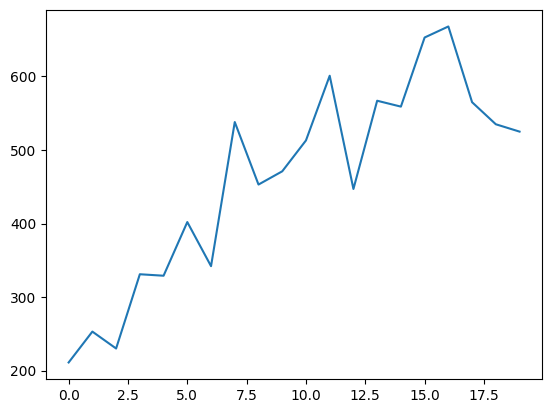

In [9]:
import matplotlib.pyplot as plt

plt.plot(episode_lengths)

In [6]:
agent.training_error

[49.0,
 53.65499999999997,
 54.097225000000094,
 49.0,
 49.0,
 53.65499999999997,
 54.097225000000094,
 48.729513875000066,
 58.76854019312509,
 58.76854019312509,
 52.89168617381256,
 49.0,
 53.65499999999997,
 54.097225000000094,
 49.0,
 49.0,
 49.0,
 49.0,
 53.65499999999997,
 54.097225000000094,
 54.13923637500011,
 54.14322745562504,
 49.0,
 53.65499999999997,
 54.097225000000094,
 49.0,
 49.0,
 53.65499999999997,
 54.097225000000094,
 54.13923637500011,
 49.0,
 53.65499999999997,
 54.097225000000094,
 54.13923637500011,
 49.0,
 53.65499999999997,
 54.097225000000094,
 54.13923637500011,
 54.14322745562504,
 54.14360660828436,
 54.14364262778702,
 54.143646049639756,
 54.1436463747159,
 54.14364640559813,
 54.14364640853182,
 54.14364640881047,
 54.14364640883707,
 54.14364640883957,
 54.1436464088398,
 54.1436464088398,
 54.1436464088398,
 54.1436464088398,
 54.1436464088398,
 54.1436464088398,
 54.1436464088398,
 48.72928176798666,
 58.772928176769256,
 58.772928176769256,
 49.0